In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from IPython.display import Image
import cv2 as cv
import os
import pydot
from tensorflow.keras.layers import Dropout
from skimage.metrics import peak_signal_noise_ratio ,structural_similarity

2024-08-18 16:10:42.683437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 16:10:42.683593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 16:10:42.813662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Model Architecture

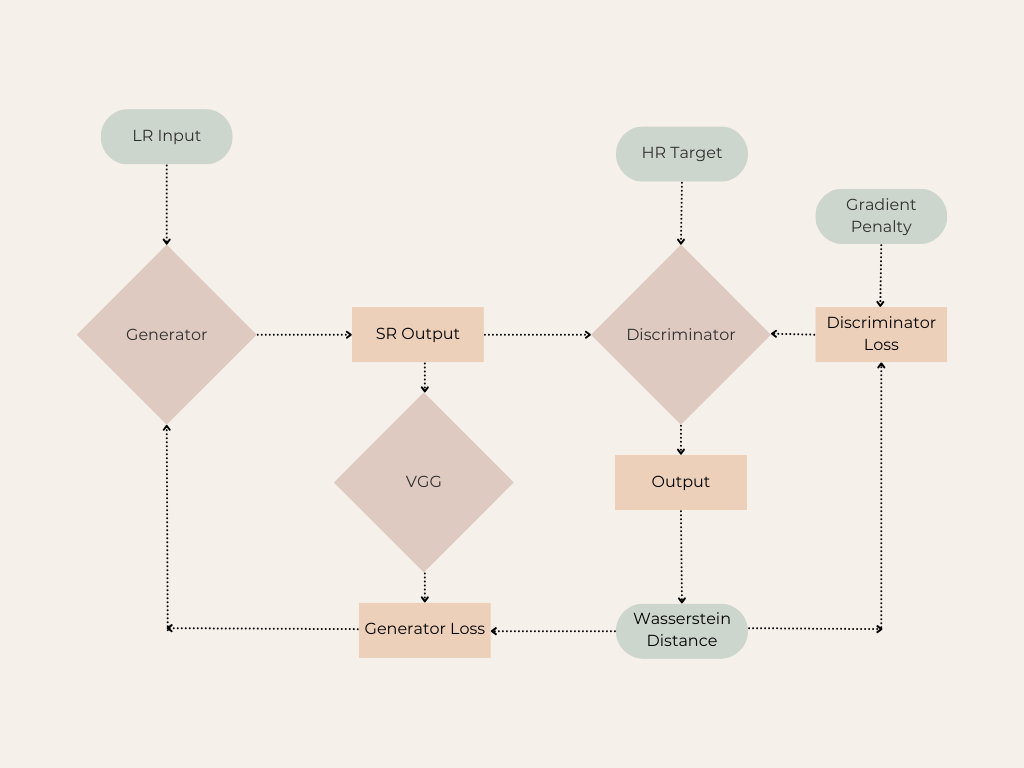

In [2]:
Image(filename='/kaggle/input/imd-architecture/Architecture_IMD.png')

# Data Loading and Processing

In [3]:
import pickle
SR_file_path = '/kaggle/input/imd-final-dataset/SR_Data_final/SR_Data_final.pkl'
LR_file_path = '/kaggle/input/imd-final-dataset/LR_Data_final/LR_Data_final.pkl'
with open(SR_file_path, 'rb') as file:
    SR_data = pickle.load(file)
with open(LR_file_path, 'rb') as file:
    LR_data = pickle.load(file)

In [4]:
import pickle
SR_pic_file_path = '/kaggle/input/imd-lr-sr/data/data.pkl'
LR_pic_file_path = '/kaggle/input/imd-lr-sr/LR_data/LR_data.pkl'
with open(SR_pic_file_path, 'rb') as file:
    SR_pic_data = pickle.load(file)
with open(LR_pic_file_path, 'rb') as file:
    LR_pic_data = pickle.load(file)

In [5]:
for key in SR_data:
    rainfall_array_final = [] 
    for j in range(SR_data[key].shape[0]):
        k = SR_data[key][j, 1:]
        nan_column = np.full((k.shape[0], 1), -1)
        modified_row = np.hstack((k, nan_column))
        rainfall_array_final.append(modified_row)
    rainfall_array_final = np.array(rainfall_array_final)
    SR_data[key] = rainfall_array_final
for key in SR_pic_data:
    rainfall_array_final = [] 
    for j in range(SR_pic_data[key].shape[0]):
        k = SR_pic_data[key][j, 1:]
        nan_column = np.full((k.shape[0], 1), -1)
        modified_row = np.hstack((k, nan_column))
        rainfall_array_final.append(modified_row)
    rainfall_array_final = np.array(rainfall_array_final)
    SR_pic_data[key] = rainfall_array_final


In [6]:
print(SR_data[1901][0].shape)
print(SR_pic_data[1901][0].shape)

(128, 136)
(128, 136)


128 136


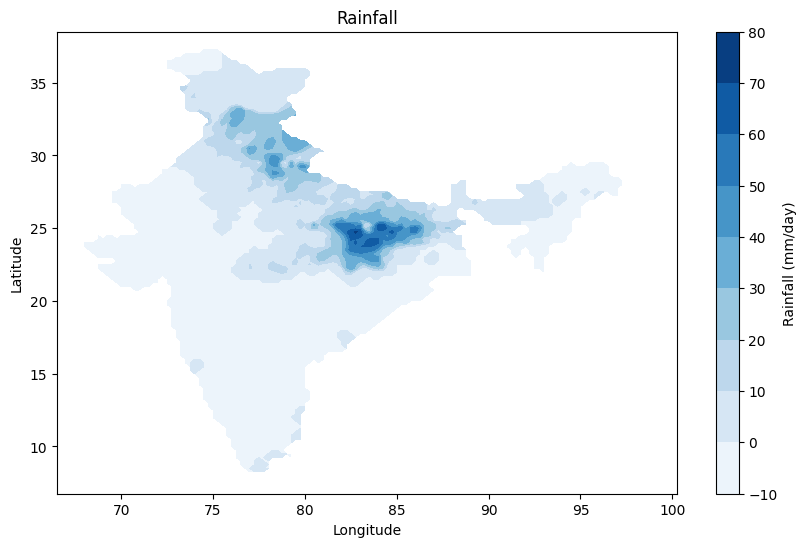

In [7]:
SR_rainfall = SR_pic_data[1901][0]
lat25 = np.load('/kaggle/input/coordinates-imd/0.25lat.npy')
lon25 = np.load('/kaggle/input/coordinates-imd/0.25lon.npy')
print(len(lat25),len(lon25))
plt.figure(figsize=(10, 6))
X_SR, Y_SR = np.meshgrid(lon25, lat25)
plt.contourf(X_SR, Y_SR, SR_rainfall, cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title(f'Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
for key in LR_data:
    final_rainfall_array = []
    for j in range(LR_data[key].shape[0]):
        k = LR_data[key][j][1:][:]
        k = np.delete(k,0,1)
        final_rainfall_array.append(k)
    LR_data[key] = final_rainfall_array
for key in LR_pic_data:
    final_rainfall_array = []
    for j in range(LR_pic_data[key].shape[0]):
        k = LR_pic_data[key][j][1:][:]
        k = np.delete(k, 0, 1)
        final_rainfall_array.append(k)
    LR_pic_data[key] = final_rainfall_array

In [9]:
print(LR_data[1901][0].shape)

(32, 34)


32 34
(32, 34)


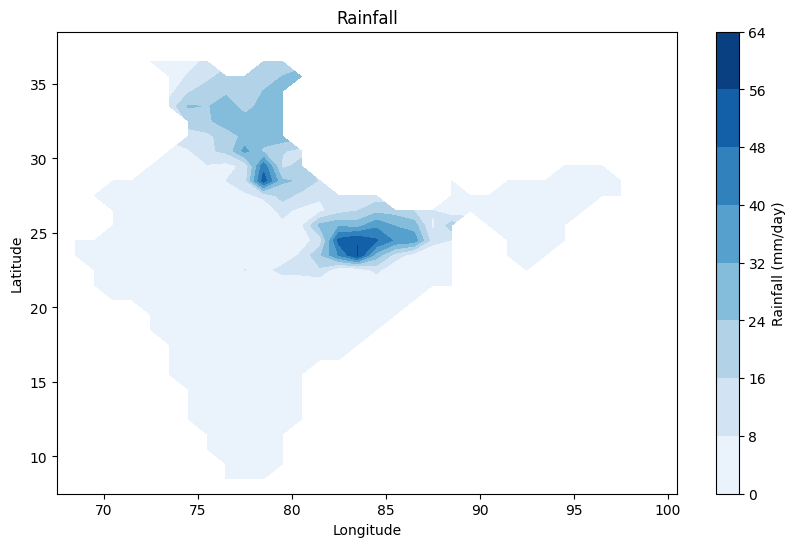

In [10]:
LR_rainfall = LR_pic_data[1901][0]
lat1 = np.load('/kaggle/input/coordinates-imd/1lat.npy')
lon1 = np.load('/kaggle/input/coordinates-imd/1lon.npy')
print(len(lat1),len(lon1))
print(LR_rainfall.shape)
plt.figure(figsize=(10, 6))
X_LR, Y_LR = np.meshgrid(lon1, lat1)
plt.contourf(X_LR, Y_LR, LR_rainfall, cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title(f'Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Cleaning Data

In [11]:
del SR_data[2002]
del SR_data[2003]
del SR_data[2023]
del LR_data[2002]
del LR_data[2003]
del LR_data[2023]

# Generator

In [12]:
class DepthToSpaceLayer(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(DepthToSpaceLayer, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.block_size)
def residual_block_gen(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
    ])
    return model
def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same')(x)
    x = DepthToSpaceLayer(block_size=2)(x)  
    x = tf.keras.layers.LeakyReLU()(x)
    return x
input_lr = tf.keras.layers.Input(shape=(None, None, 1))
input_conv = tf.keras.layers.Conv2D(64, 3, padding='same')(input_lr)
input_conv = tf.keras.layers.LeakyReLU()(input_conv)
Generator = input_conv
for _ in range(10):
    res_output = residual_block_gen()(Generator)
    Generator = tf.keras.layers.Add()([Generator, res_output])
Generator = tf.keras.layers.Conv2D(64, 3, padding='same')(Generator)
Generator = tf.keras.layers.BatchNormalization()(Generator)

Generator = tf.keras.layers.Add()([Generator, input_conv])

Generator = Upsample_block(Generator)  
Generator = Upsample_block(Generator) 
output_sr = tf.keras.layers.Conv2D(1, 3, activation='linear', padding='same')(Generator)

Generator = tf.keras.models.Model(input_lr, output_sr)


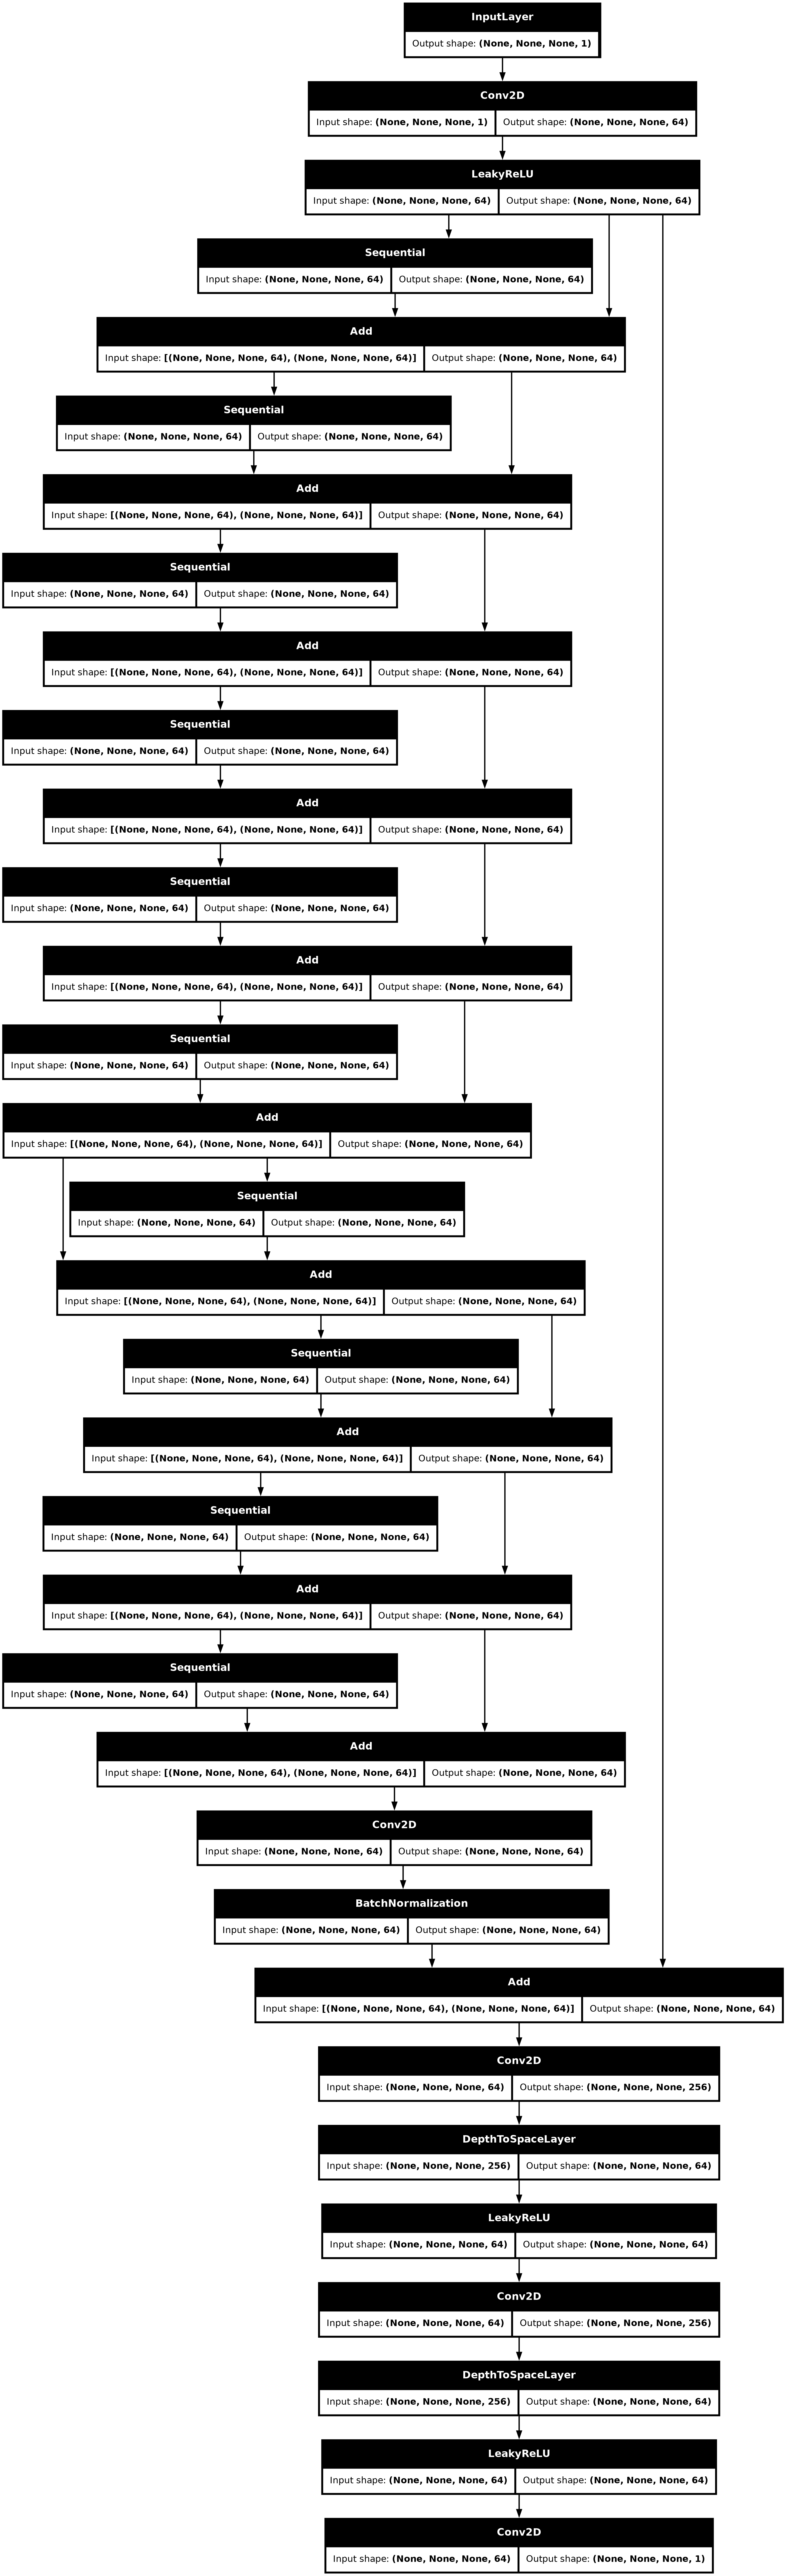

In [13]:
tf.keras.utils.plot_model(Generator, show_shapes=True)

In [14]:
Generator.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        640 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, None,      │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │     74,368 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ leaky_re_lu[0][0… │
│                     │ None, 64)         │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None,      │     74,368 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ add[0][0],        │
│                     │ None, 64)         │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │     74,368 │ add_1[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None,      │          0 │ add_1[0][0],      │
│                     │ None, 64)         │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │     74,368 │ add_2[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None,      │          0 │ add_2[0][0],      │
│                     │ None, 64)         │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None,      │     74,368 │ add_3[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None,      │          0 │ add_3[0][0],      │
│                     │ None, 64)         │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │     74,368 │ add_4[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None,      │          0 │ add_4[0][0],      │
│                     │ None, 64)         │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, None,      │     74,368 │ add_5[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, None,      │          0 │ add_5[0][0],    

 Total params: 1,077,505 (4.11 MB)

 Trainable params: 1,074,817 (4.10 MB)

 Non-trainable params: 2,688 (10.50 KB)

# Discriminator (Critic)

In [15]:
def residual_block_disc(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same',
                               kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        # Optional: Move BatchNormalization after activation or remove
        # tf.keras.layers.BatchNormalization(),
    ])
    return model

input_lr = tf.keras.layers.Input(shape=(128, 136, 1))
input_conv = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(input_lr)
input_conv = tf.keras.layers.LeakyReLU(alpha=0.2)(input_conv)

channel_nums = [64, 128, 128, 256, 256, 512, 512]
stride_sizes = [2, 1, 2, 1, 2, 1, 2]

disc = input_conv
for x in range(7):
    disc = residual_block_disc(ch=channel_nums[x], st=stride_sizes[x])(disc)

disc = tf.keras.layers.Flatten()(disc)
disc = tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.HeNormal())(disc)
disc = tf.keras.layers.LeakyReLU(alpha=0.2)(disc)
disc_output = tf.keras.layers.Dense(1)(disc) 
discriminator = tf.keras.models.Model(input_lr, disc_output)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


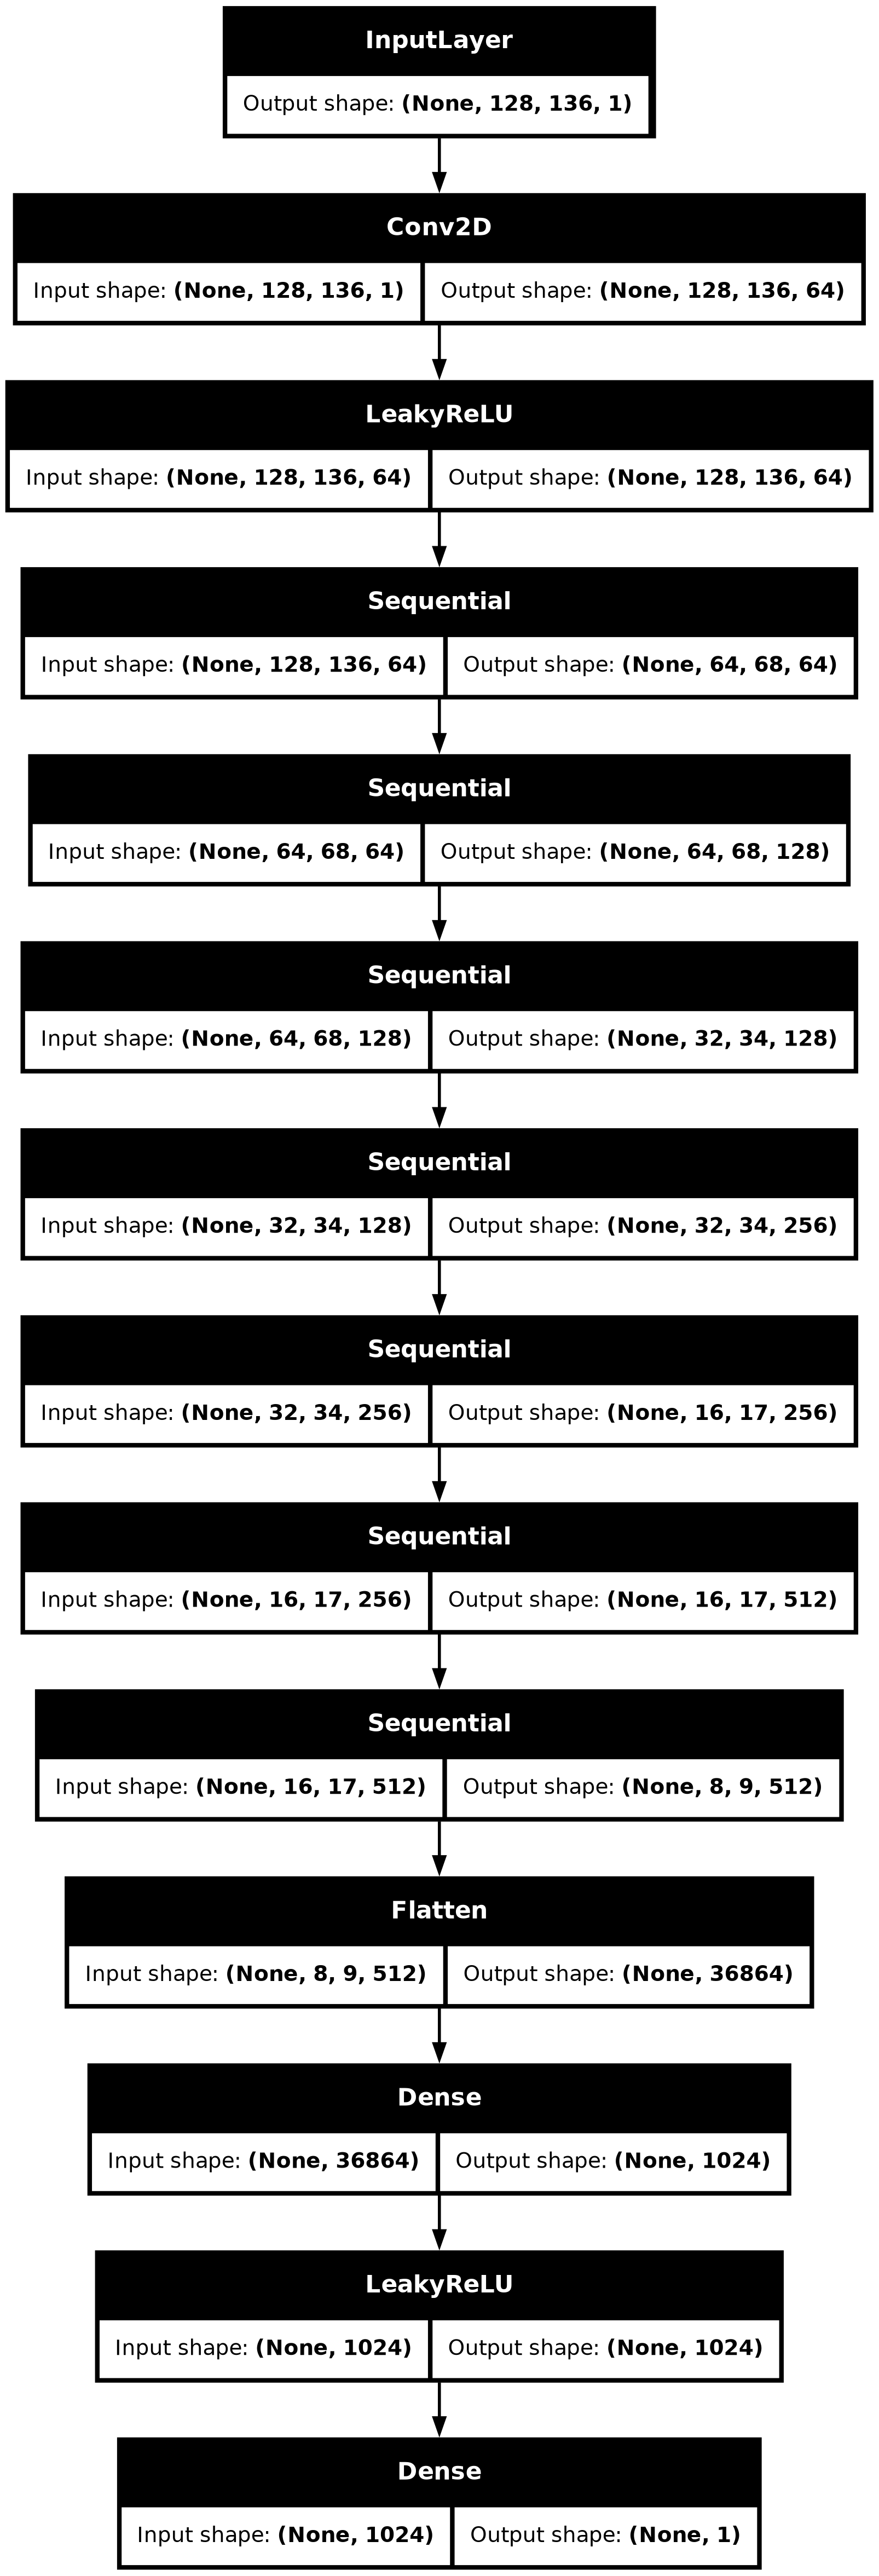

In [16]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

In [17]:
discriminator.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 136, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 136, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 64, 68, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 64, 68, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 32, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 32, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 16, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 16, 17, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 8, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    37,749,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,435,009 (161.88 MB)

 Trainable params: 42,435,009 (161.88 MB)

 Non-trainable params: 0 (0.00 B)

# Feature Extractor


In [18]:
from keras.models import load_model
model = load_model('/kaggle/input/rainfall_feature_extractor/tensorflow2/default/1/final.h5')
layer_names = ['vgg16', 'dense'] 

In [19]:
feature_extractor_fig = Model(inputs=model.input, outputs=model.get_layer('activation_2').output)
feature_extractor_fig.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 136, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 136, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 136, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 136, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 136, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 136, 3)    │         1,731 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 136, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 136, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,823 (155.56 KB)

 Trainable params: 39,561 (154.54 KB)

 Non-trainable params: 262 (1.02 KB)

#### Visualising how feature extractor extracts features before feeding it to the VGG. We can see the images of india inverted

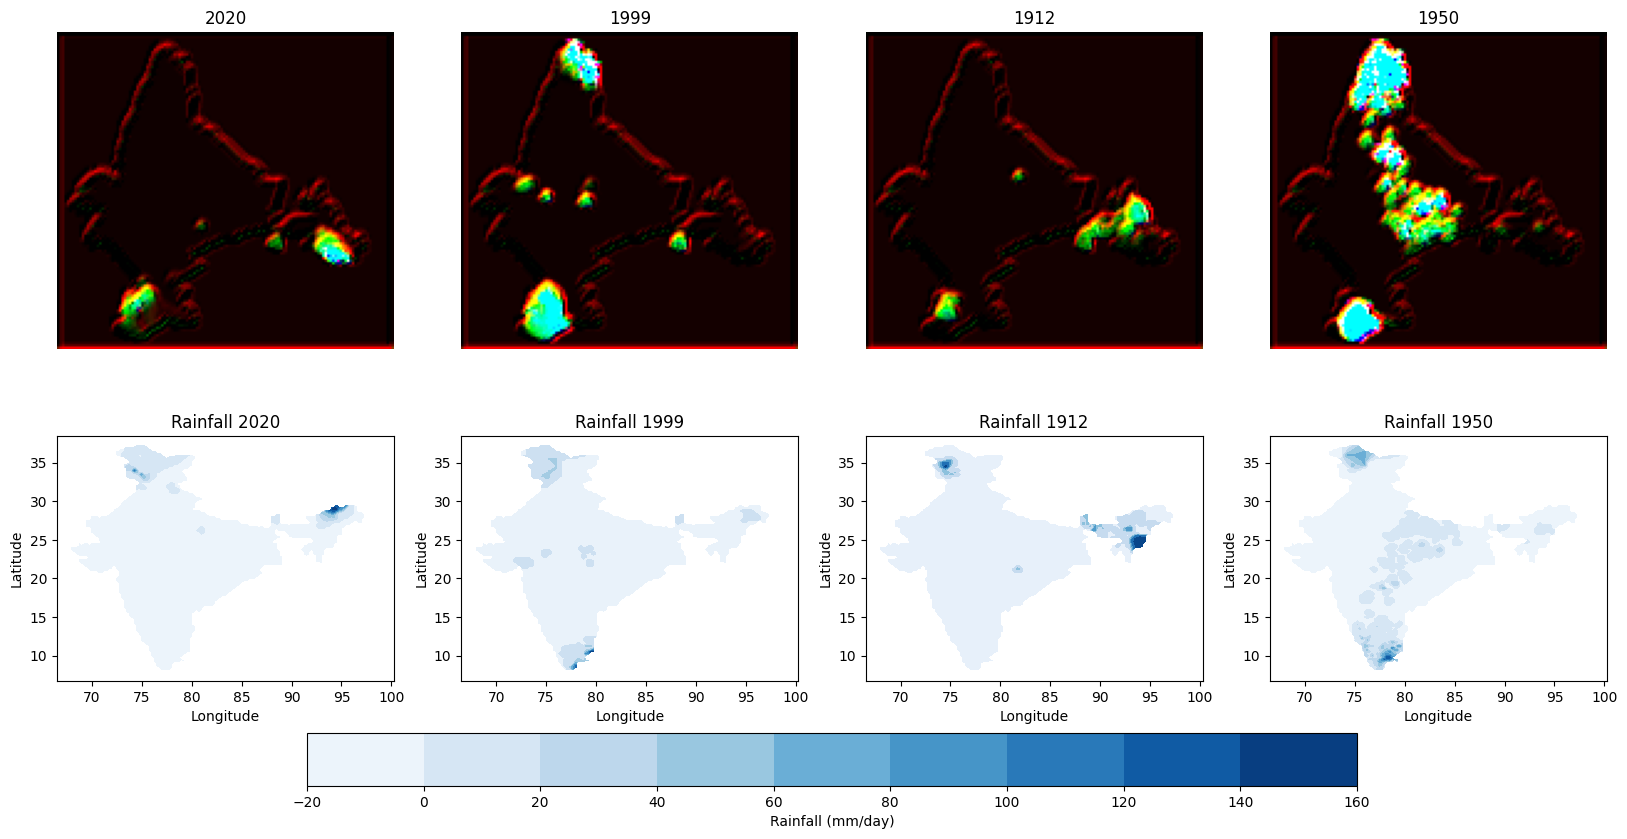

In [20]:
image1 = feature_extractor_fig(SR_data[2020][50].reshape(1, 128, 136, 1))
image2 = feature_extractor_fig(SR_data[1999][50].reshape(1, 128, 136, 1))
image3 = feature_extractor_fig(SR_data[1912][50].reshape(1, 128, 136, 1))
image4 = feature_extractor_fig(SR_data[1950][50].reshape(1, 128, 136, 1))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].imshow(image1[0], cmap='gray')
axes[0, 0].set_title('2020')

axes[0, 1].imshow(image2[0], cmap='gray')
axes[0, 1].set_title('1999')

axes[0, 2].imshow(image3[0], cmap='gray')
axes[0, 2].set_title('1912')

axes[0, 3].imshow(image4[0], cmap='gray')
axes[0, 3].set_title('1950')
for ax in axes[0, :]:
    ax.axis('off')
for i, year in enumerate([2020, 1999, 1912, 1950]):
    X_SR, Y_SR = np.meshgrid(lon25, lat25)
    SR_rainfall = SR_pic_data[year][50]  # Assuming SR_rainfall is a 2D array for each year
    
    contour = axes[1, i].contourf(X_SR, Y_SR, SR_rainfall, cmap='Blues')
    axes[1, i].set_title(f'Rainfall {year}')
    axes[1, i].set_xlabel('Longitude')
    axes[1, i].set_ylabel('Latitude')
fig.colorbar(contour, ax=axes[1, :], orientation='horizontal', label='Rainfall (mm/day)')

plt.show()


In [21]:
layer_outputs = [model.get_layer(name).output for name in layer_names]
feature_extractor_1 = Model(inputs=model.input, outputs=model.get_layer('flatten').output)
# feature_extractor_2 = Model(inputs=model.input, outputs=model.get_layer('dense').output)
feature_extractor_1.summary()
# feature_extractor_2.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 136, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 136, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 136, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 136, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 136, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 136, 3)    │         1,731 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 136, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 136, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,754,511 (56.28 MB)

 Trainable params: 39,561 (154.54 KB)

 Non-trainable params: 14,714,950 (56.13 MB)

# Training

In [22]:
def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated_images = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = discriminator(interpolated_images)

    gradients = tape.gradient(predictions, interpolated_images)
    gradients_sqr_sum = tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3])
    gradient_l2_norm = tf.sqrt(gradients_sqr_sum + 1e-8)
    gradient_penalty = tf.reduce_mean((gradient_l2_norm - 1.0) ** 2)

    return gradient_penalty

In [23]:
def discriminator_loss(real_output, fake_output, gp, lambda_gp=10):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp


In [24]:
def generator_loss(fake_output, real_images, fake_images, feature_extractor_1):
    adv_loss = -tf.reduce_mean(fake_output)
    feature_loss = 0
    real_feature_1 = feature_extractor_1(real_images)
    fake_feature_1 = feature_extractor_1(fake_images)
#     real_feature_2 = feature_extractor_2(real_images)
#     fake_feature_2 = feature_extractor_2(fake_images)
    for real, fake in zip(real_feature_1, fake_feature_1):
        feature_loss += tf.reduce_mean(tf.abs(real - fake))
#     for real, fake in zip(real_feature_2, fake_feature_2):
#         feature_loss += tf.reduce_mean(tf.abs(real - fake))
#     feature_loss/=2
    total_loss =  adv_loss + feature_loss
    return total_loss

In [25]:
def plot_hr():
    sr = np.array(SR_data[2000][0]).reshape((1, 128, 136, 1))
    sr = sr.astype(np.float16)
    generated = np.array(Generator(sr))

    # Create a copy and process it
    array = np.copy(generated[0].reshape(512, 544))
    m = generated.min()
    array[array < 0] = np.nan
    if m<0:
        array = array - m

    # Longitude and Latitude for the grid
    lon = np.arange(len(lon25) * 4)
    lat = np.arange(len(lat25) * 4)
    X_SR, Y_SR = np.meshgrid(lon, lat)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the original generated image
    im1 = axes[0].contourf(X_SR, Y_SR, generated[0].reshape(512, 544), cmap='Blues')
    axes[0].set_title('Higher Resolution Rainfall')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    fig.colorbar(im1, ax=axes[0], label='Rainfall (mm/day)')

    # Plot the processed image
    im2 = axes[1].contourf(X_SR, Y_SR, array, cmap='Blues')
    axes[1].set_title('Processed Higher Resolution Rainfall')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    fig.colorbar(im2, ax=axes[1], label='Rainfall (mm/day)')

    plt.show()

In [26]:
def calculate_metrics(Generator, SR_data, LR_data):
    PSNR = []
    SSIM = []
    def generate_data():
        for year in range(1901, 2024):
            if year in [2002, 2003, 2023]:
                continue
            for i in range(len(SR_data[year])):
                yield LR_data[year][i], SR_data[year][i]

    dataset = tf.data.Dataset.from_generator(
        generate_data,
        output_signature=(
            tf.TensorSpec(shape=(32, 34), dtype=tf.float32),
            tf.TensorSpec(shape=(128, 136), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(64) 

    for lr_batch, sr_batch in dataset:
        sr_images = Generator(lr_batch)
        sr_images_np = sr_images.numpy()
        for i in range(sr_images_np.shape[0]):
            data_range = sr_batch[i].numpy().max() - sr_batch[i].numpy().min()
            psnr_value = peak_signal_noise_ratio(sr_batch[i].numpy(), sr_images_np[i].reshape(128, 136), data_range=data_range)
            ssim_value = structural_similarity(sr_batch[i].numpy(), sr_images_np[i].reshape(128, 136), multichannel=False, data_range=data_range)
            PSNR.append(psnr_value)
            SSIM.append(ssim_value)
    return np.mean(PSNR), np.mean(SSIM)

In [27]:
PSNR = []
SSIM  = []

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.0, beta_2=0.9)

def train_step(SR_images, LR_images, batch_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = Generator(LR_images, training=True)
        real_output = discriminator(SR_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        gp = gradient_penalty(discriminator, SR_images, fake_images)
        gen_loss = generator_loss(fake_output, SR_images, fake_images, feature_extractor_1)
        disc_loss = discriminator_loss(real_output, fake_output, gp)
    
    # Compute gradients for the generator, discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, Generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients to update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, Generator.trainable_variables ))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(SR_data, LR_data,PSNR,SSIM, epochs, batch_size):
    for epoch in range(epochs):
        for year in range(1901, 2024):
            if year in [2002, 2003, 2023]:
                continue
            days_in_year = len(LR_data[year])
            indices = np.arange(days_in_year)
            np.random.shuffle(indices)
            batches = [indices[i:i+batch_size] for i in range(0, days_in_year, batch_size)]

            for batch_indices in batches:
                lr = np.array([LR_data[year][j] for j in batch_indices]).reshape((len(batch_indices), 32, 34, 1))
                sr = np.array([SR_data[year][j] for j in batch_indices]).reshape((len(batch_indices), 128, 136, 1))
                gen_loss, disc_loss = train_step(sr, lr, len(batch_indices))
                
            if year % 10 == 0:
                print(f'Epoch {epoch+1}, Year {year}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
                # Visualization code (unchanged)
                sr_pic = np.array(SR_pic_data[2000][0])
                lr_pic = np.array(LR_data[2000][:32]).reshape((32, 32, 34, 1))
                generated = np.array(Generator(lr_pic))
                plt.figure(figsize=(21, 6))
                plt.subplot(1, 3, 1)
                X_SR, Y_SR = np.meshgrid(lon25, lat25)
                array = np.copy(generated[0].reshape(128, 136))
                array[array < 0] = np.nan
                plt.contourf(X_SR, Y_SR, generated[0].reshape(128, 136), cmap='Blues')
                plt.colorbar(label='Rainfall (mm/day)')
                plt.title('Generated Rainfall data')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.subplot(1, 3, 2)
                X_SR, Y_SR = np.meshgrid(lon25, lat25)
                array = generated[0].reshape(128, 136)
                array[array < 0] = np.nan
                plt.contourf(X_SR, Y_SR, array, cmap='Blues')
                plt.colorbar(label='Rainfall (mm/day)')
                plt.title('Processed Generated Rainfall data')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.subplot(1, 3, 3)
                plt.contourf(X_SR, Y_SR, sr_pic, cmap='Blues')
                plt.colorbar(label='Rainfall (mm/day)')
                plt.title('Actual Rainfall data')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.show()
                plot_hr()
        psnr,ssim = calculate_metrics(Generator, SR_data, LR_data)
        PSNR.append(psnr)
        SSIM.append(ssim)
        print(f'PSNR:{psnr},SSIM:{ssim}')
        Generator.save(f'generator_epoch_{epoch+1}.h5')
        discriminator.save(f'discriminator_epoch_{epoch+1}.h5')
        print(f'Models saved after epoch {epoch+1}')

Epoch 1, Year 1910, Generator Loss: -2216.0078125, Discriminator Loss: -3833.541748046875


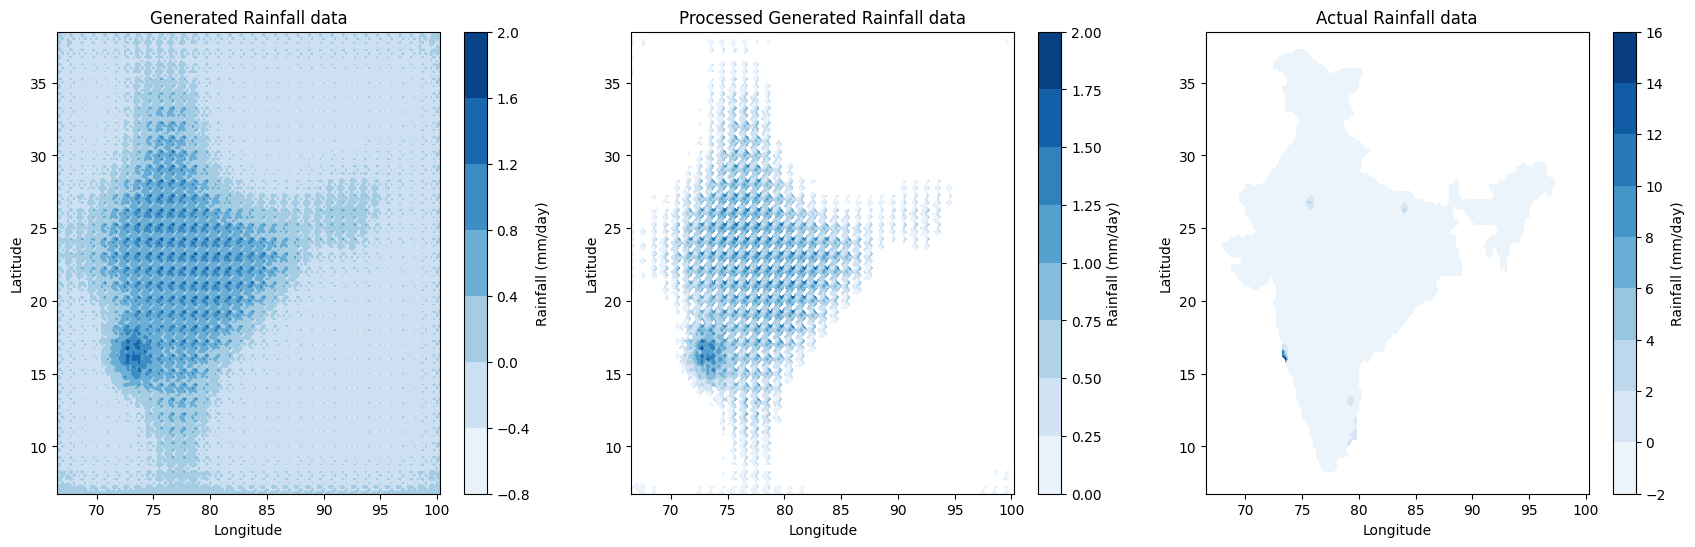

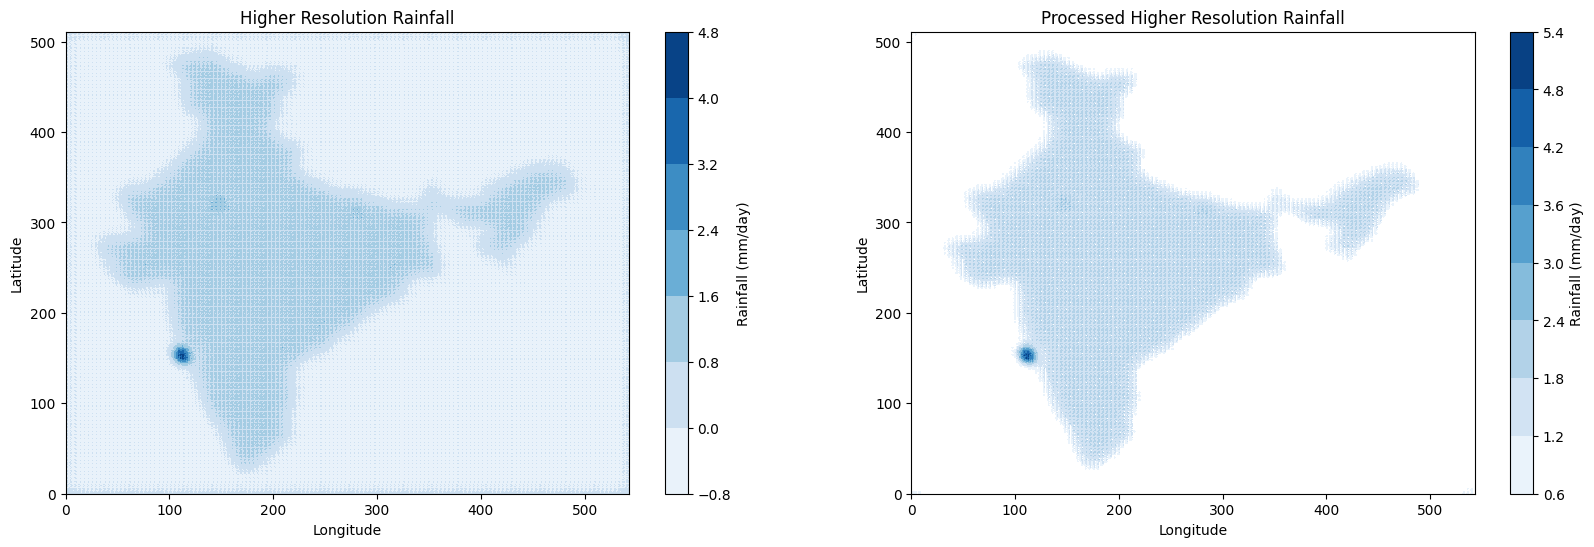

Epoch 1, Year 1930, Generator Loss: -1102.527587890625, Discriminator Loss: -2525.11181640625


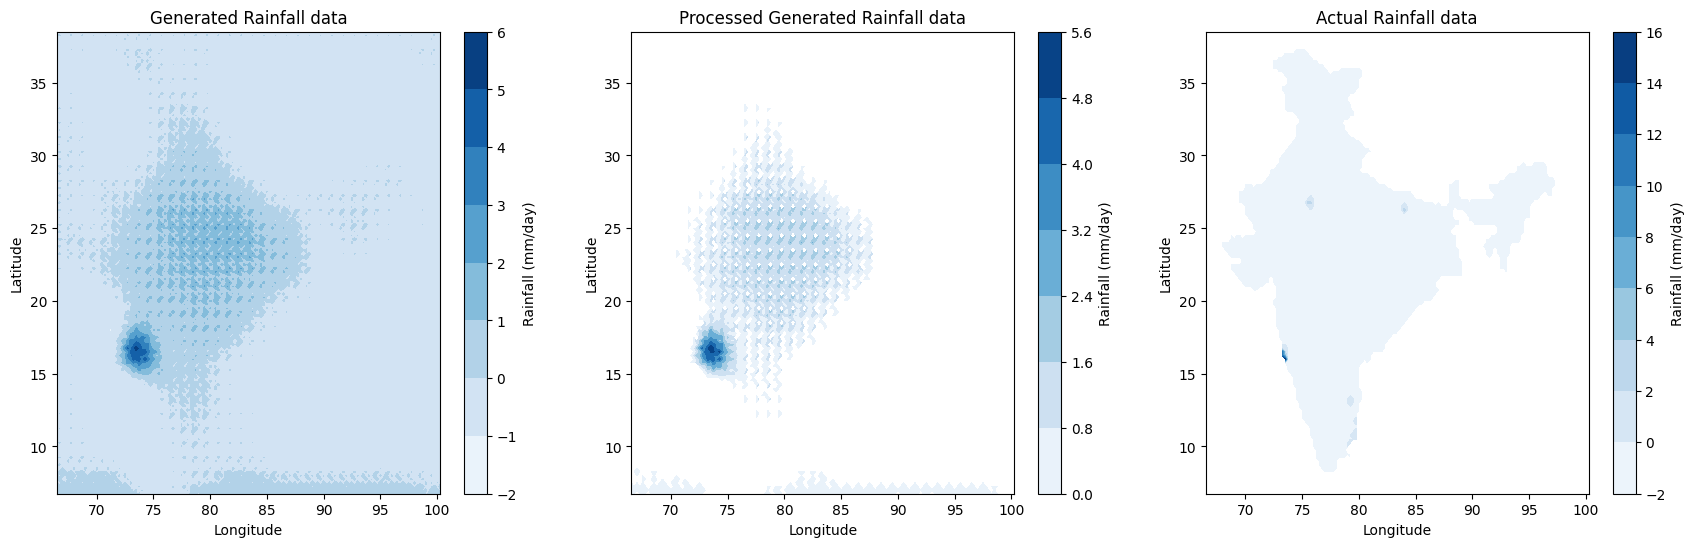

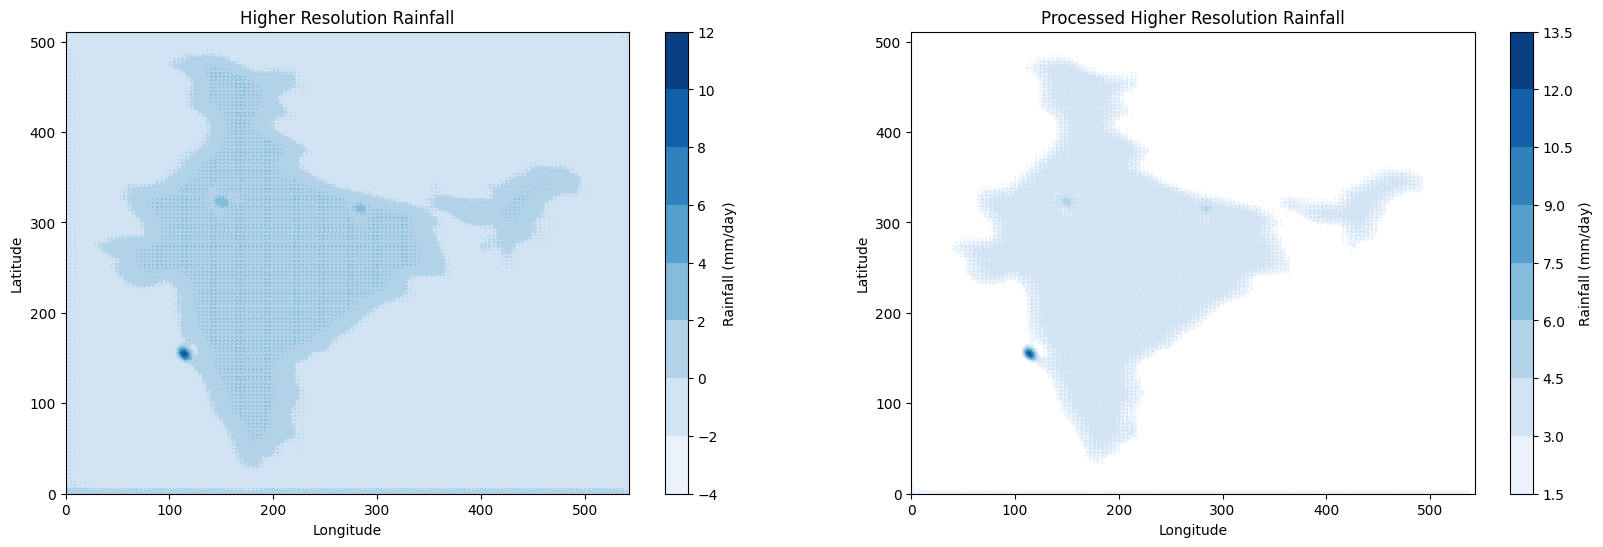

Epoch 1, Year 1940, Generator Loss: -990.6276245117188, Discriminator Loss: -2143.311767578125


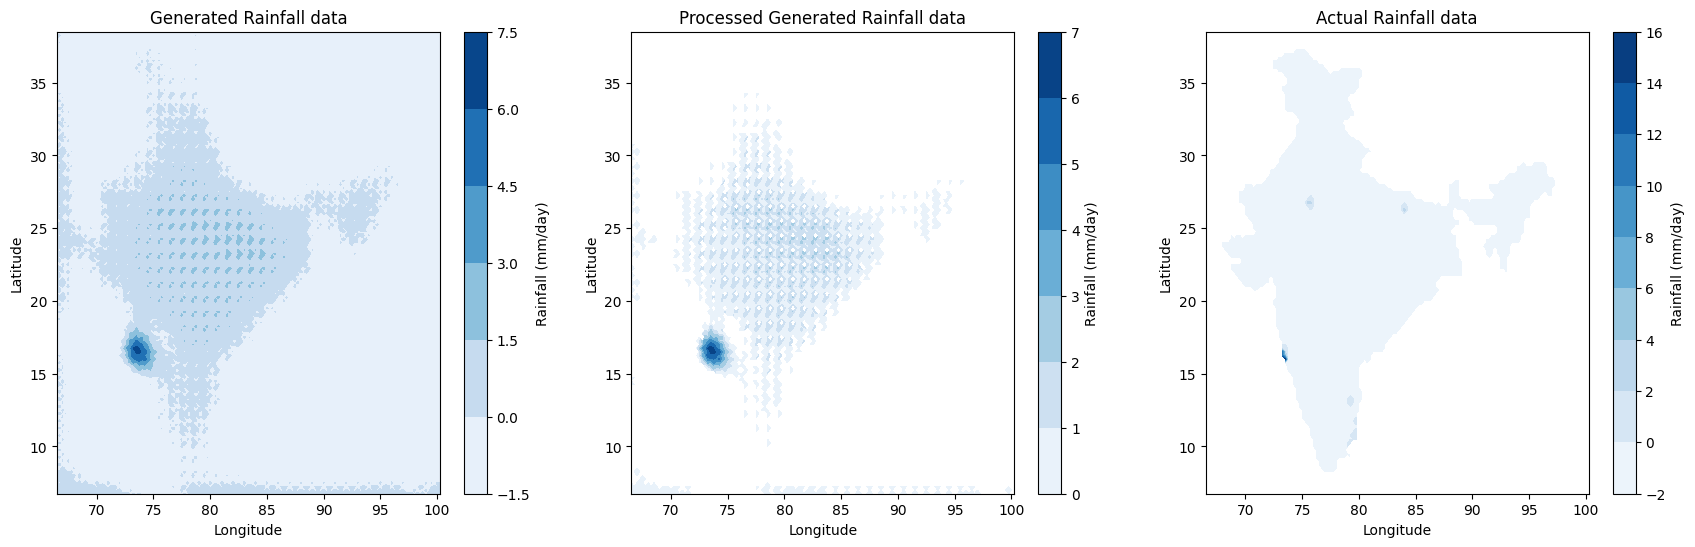

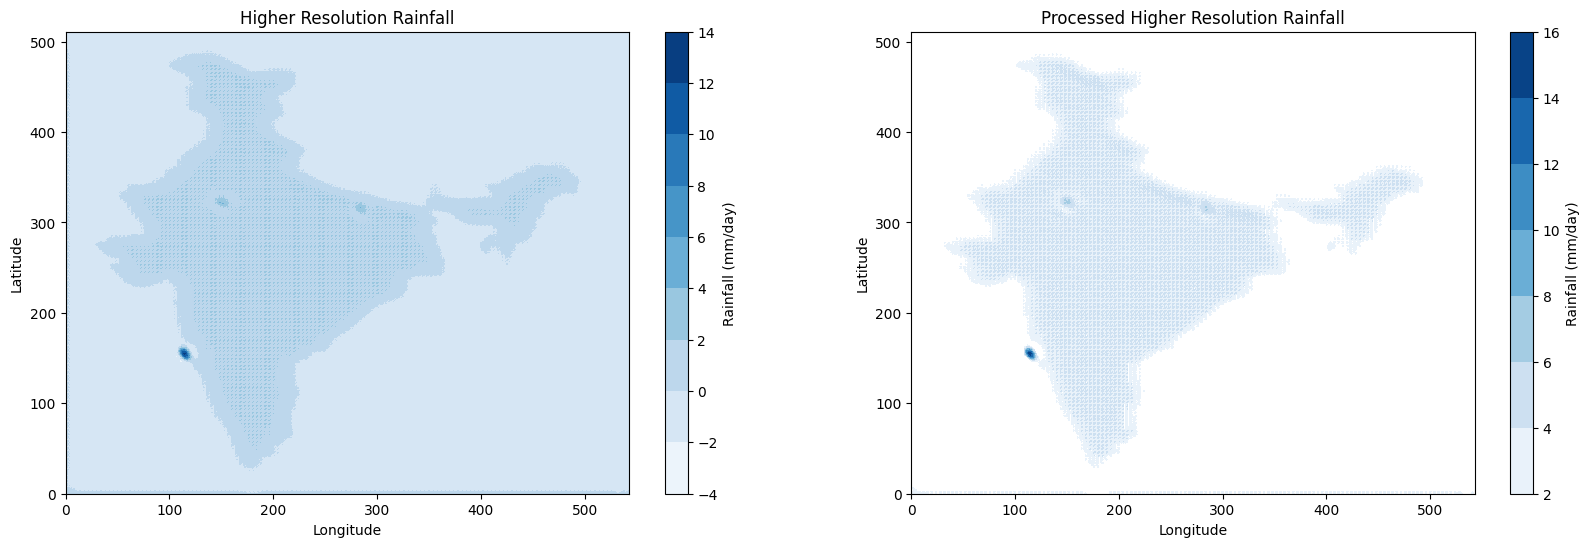

Epoch 1, Year 1950, Generator Loss: 118.76001739501953, Discriminator Loss: -1839.3504638671875


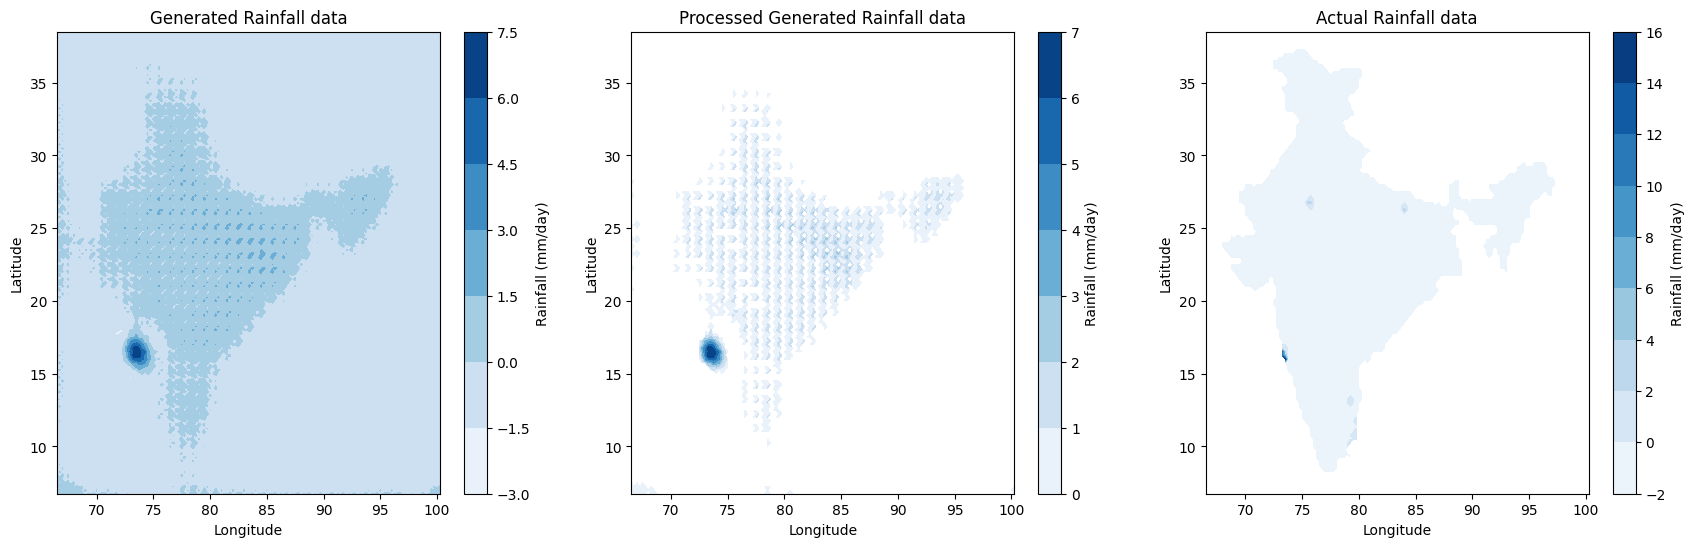

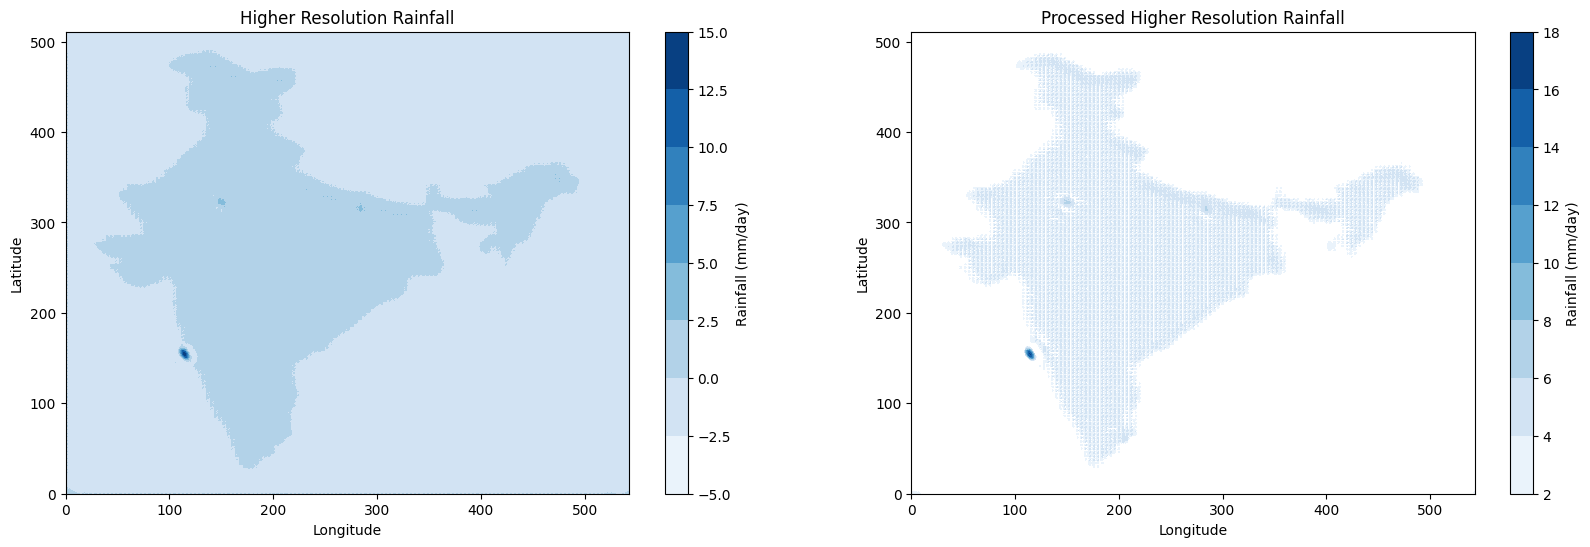

Epoch 1, Year 1960, Generator Loss: 981.0667114257812, Discriminator Loss: -1336.2042236328125


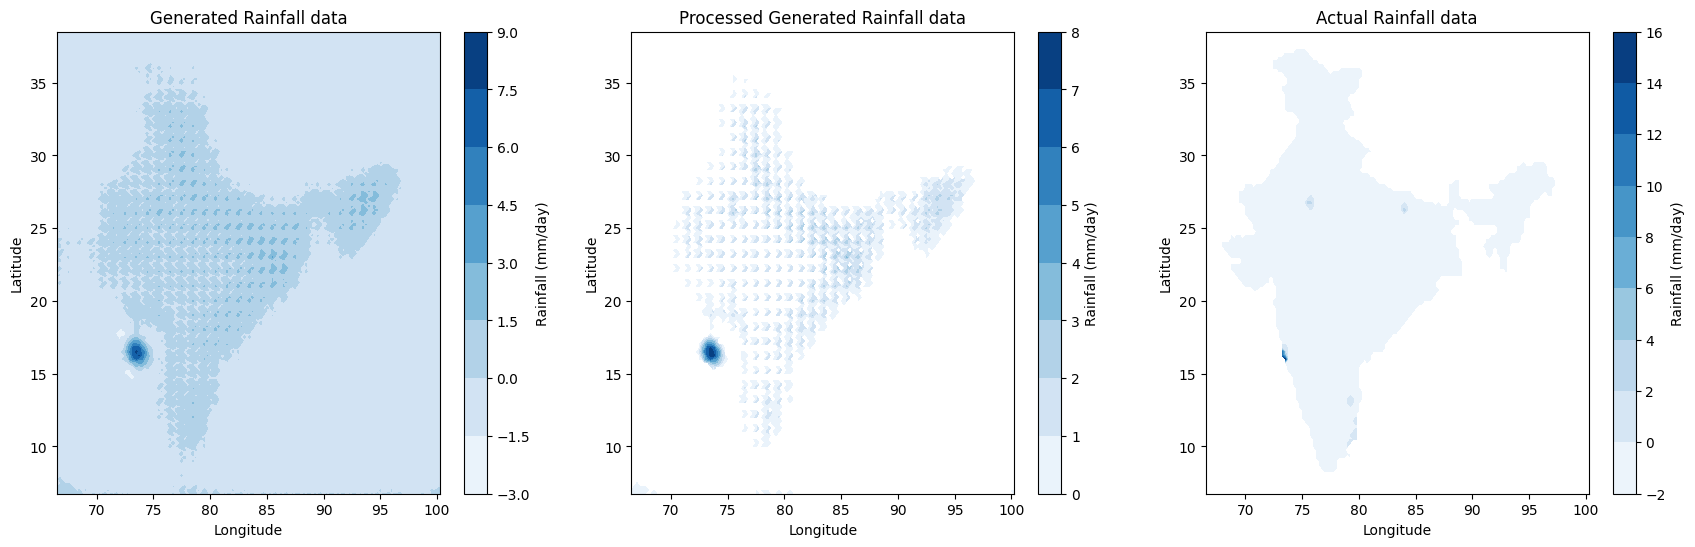

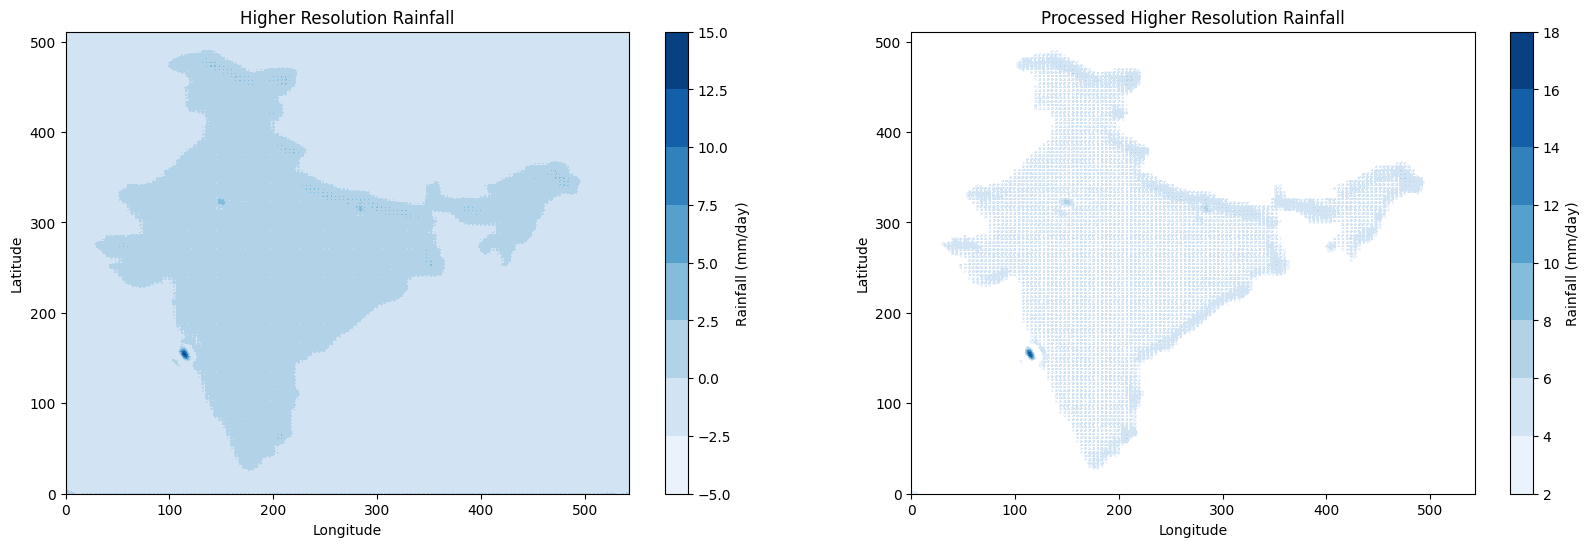

Epoch 1, Year 1970, Generator Loss: 1283.006591796875, Discriminator Loss: -474.1480712890625


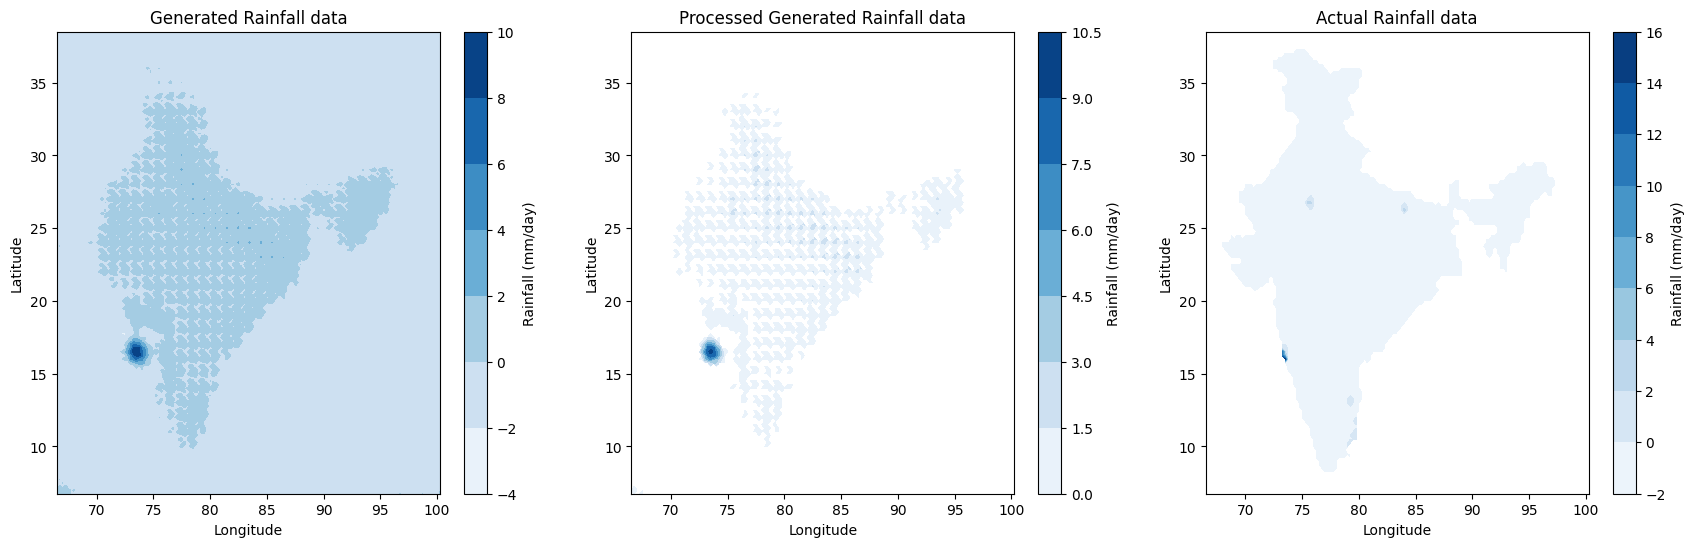

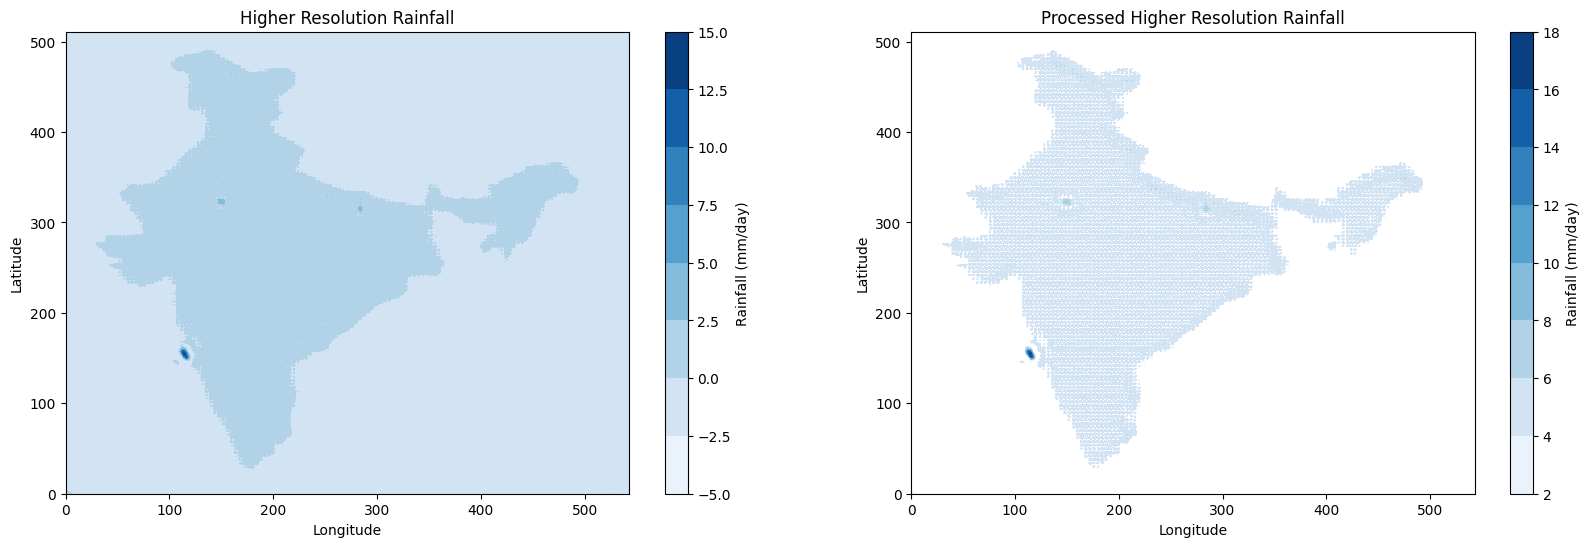

Epoch 1, Year 1980, Generator Loss: -372.57037353515625, Discriminator Loss: -1632.250244140625


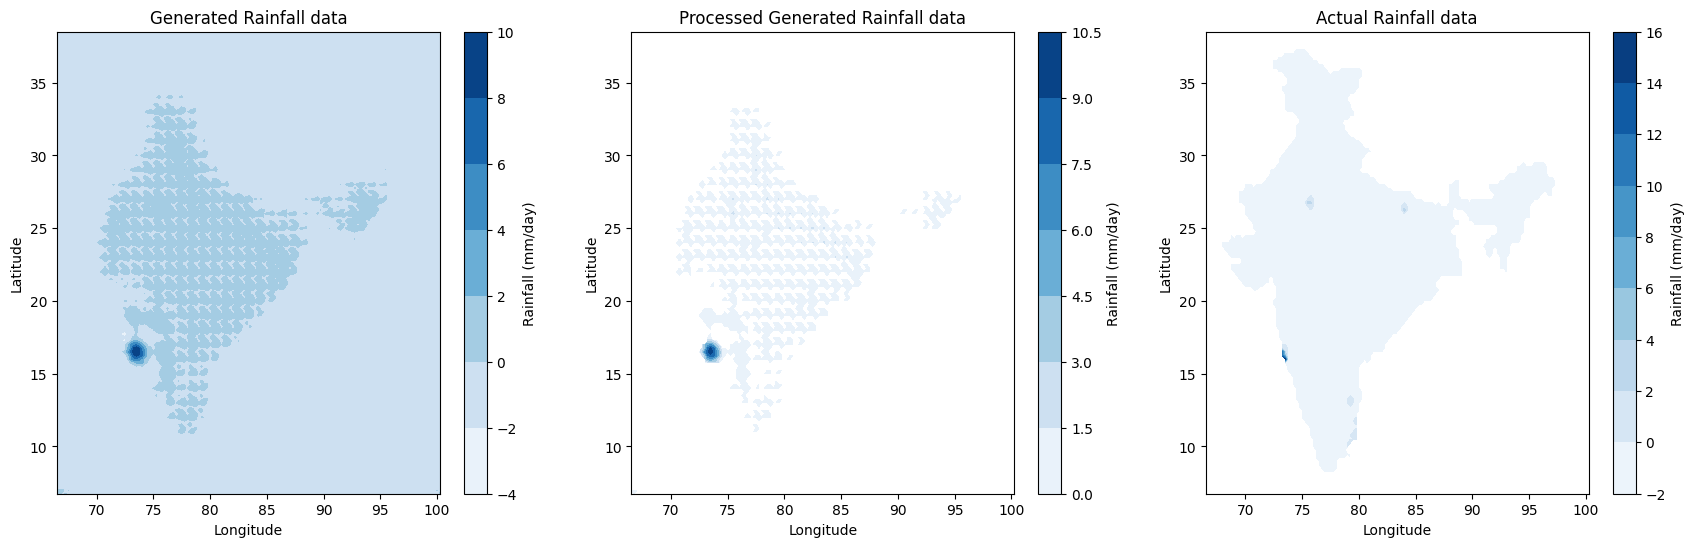

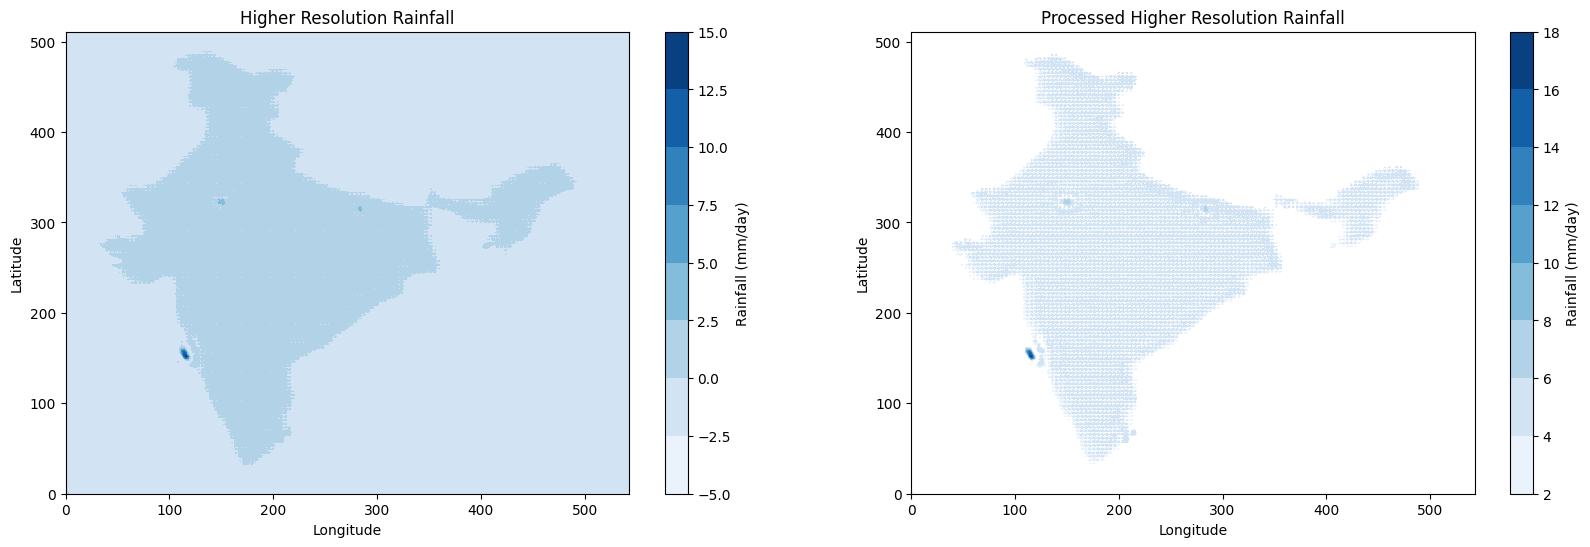

Epoch 1, Year 1990, Generator Loss: -684.1489868164062, Discriminator Loss: -1705.638427734375


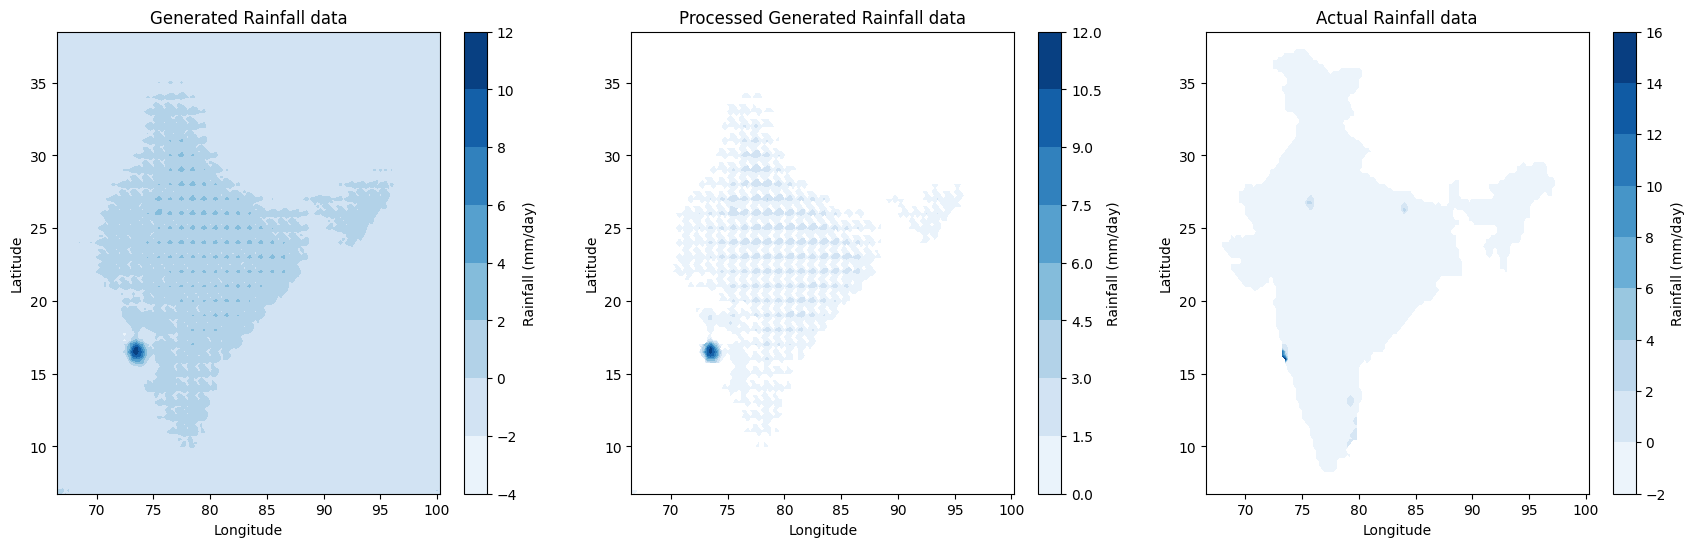

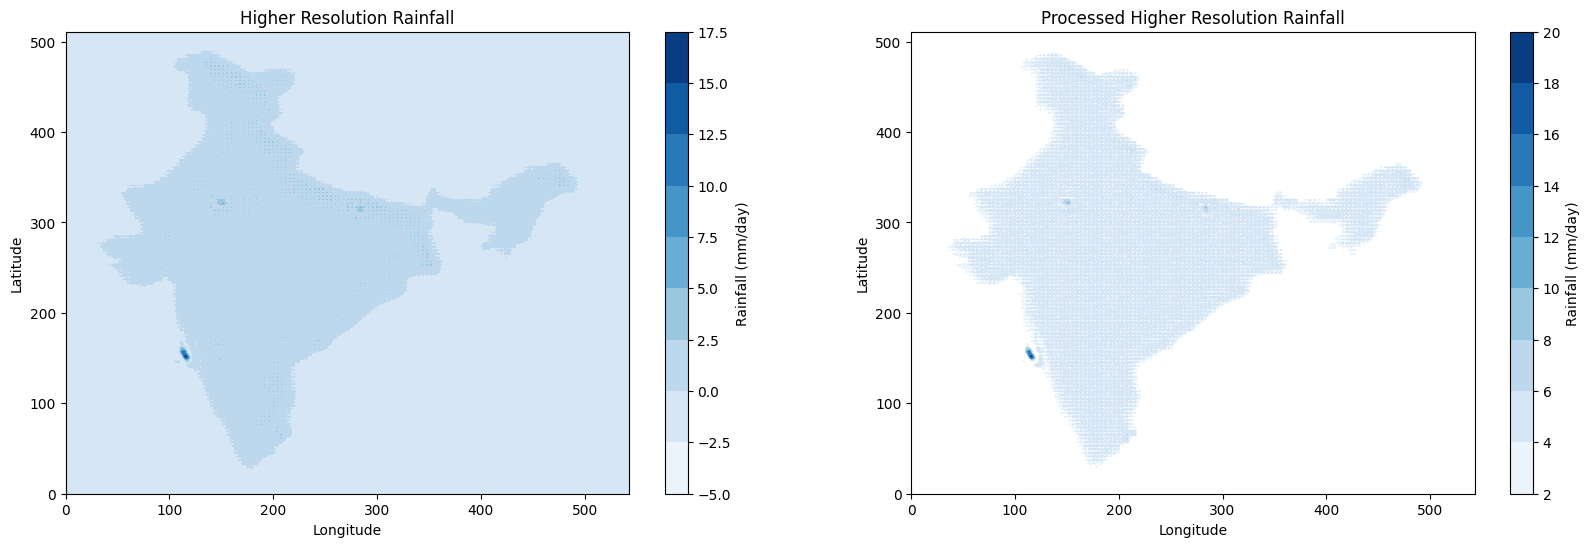

Epoch 1, Year 2000, Generator Loss: 431.2908630371094, Discriminator Loss: -670.2471923828125


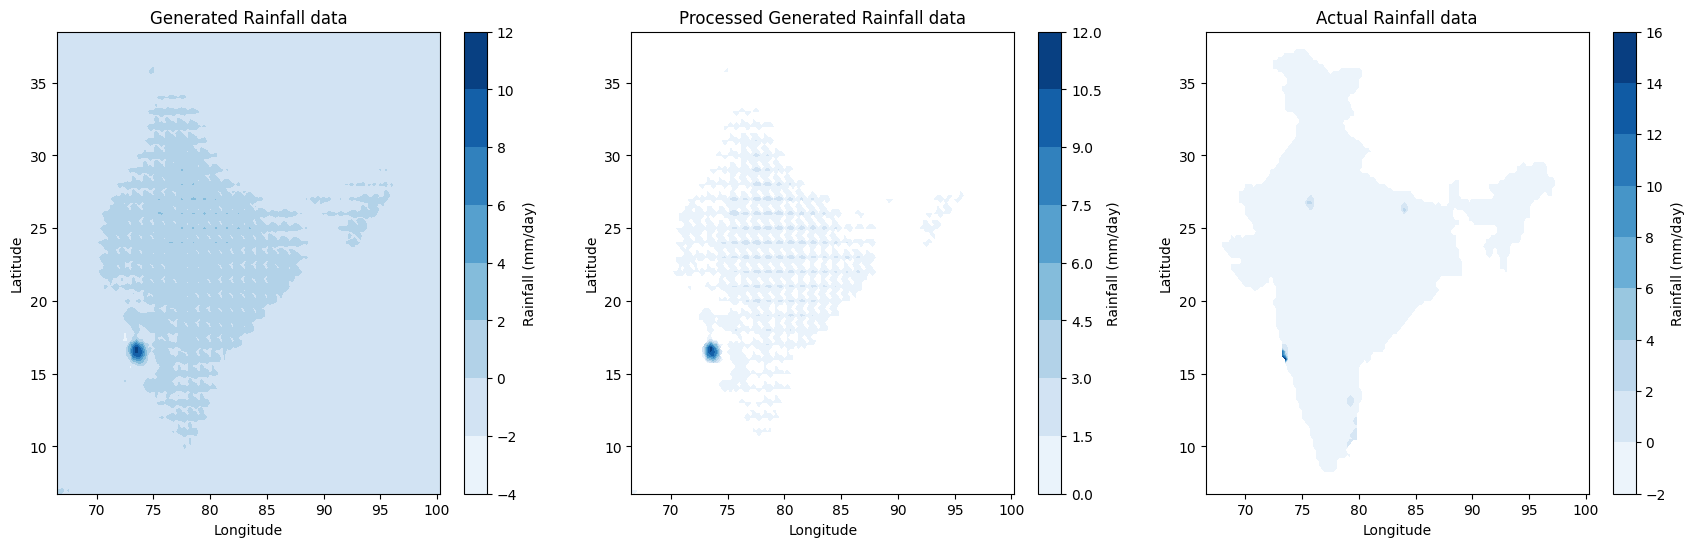

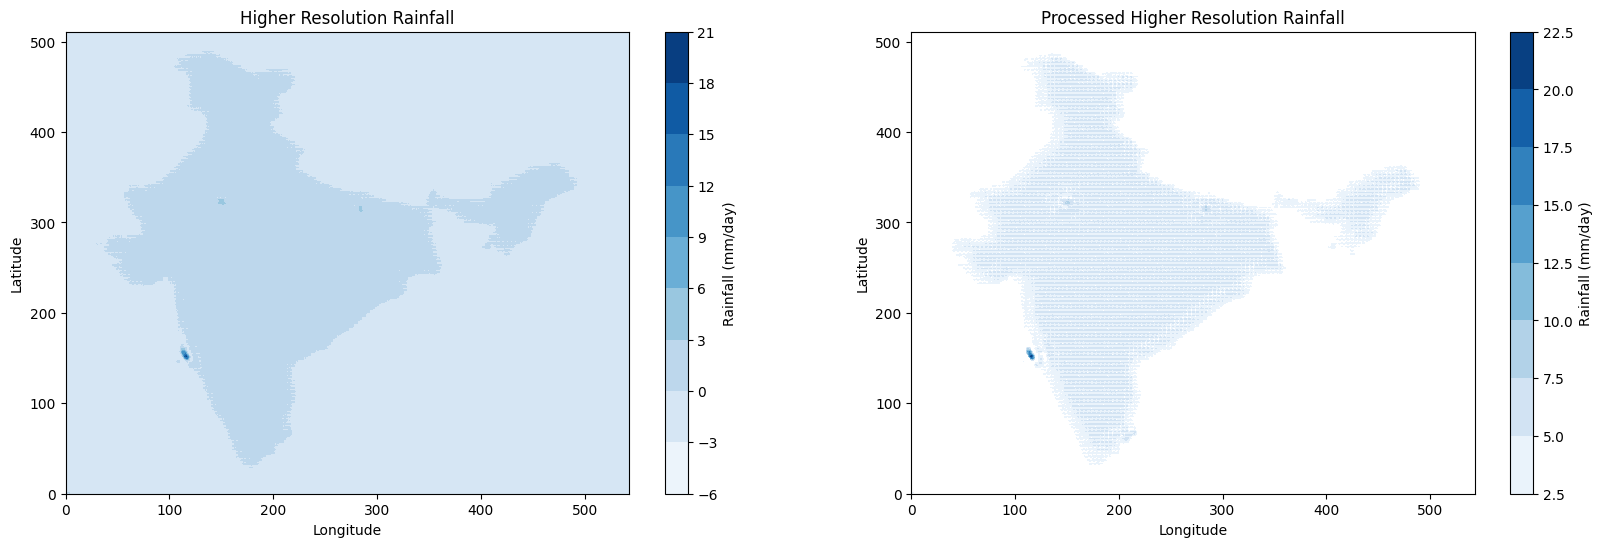

Epoch 1, Year 2010, Generator Loss: -32.161197662353516, Discriminator Loss: -3079.430908203125


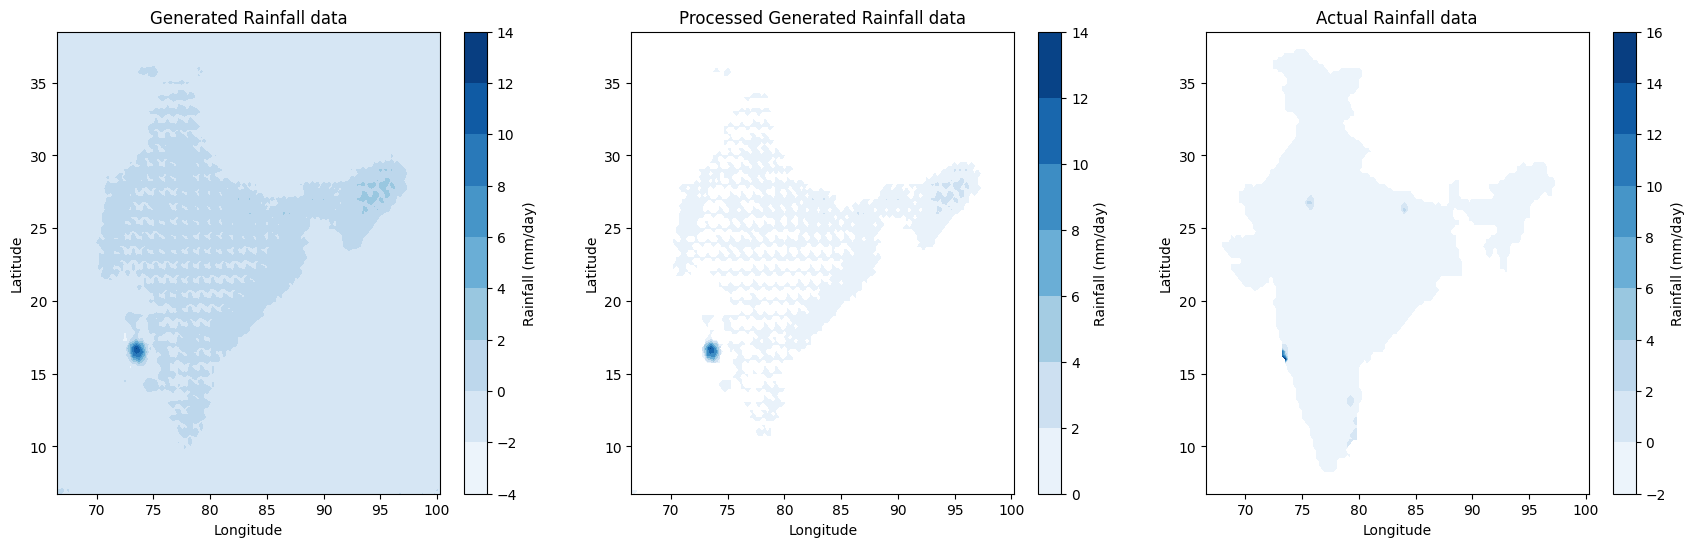

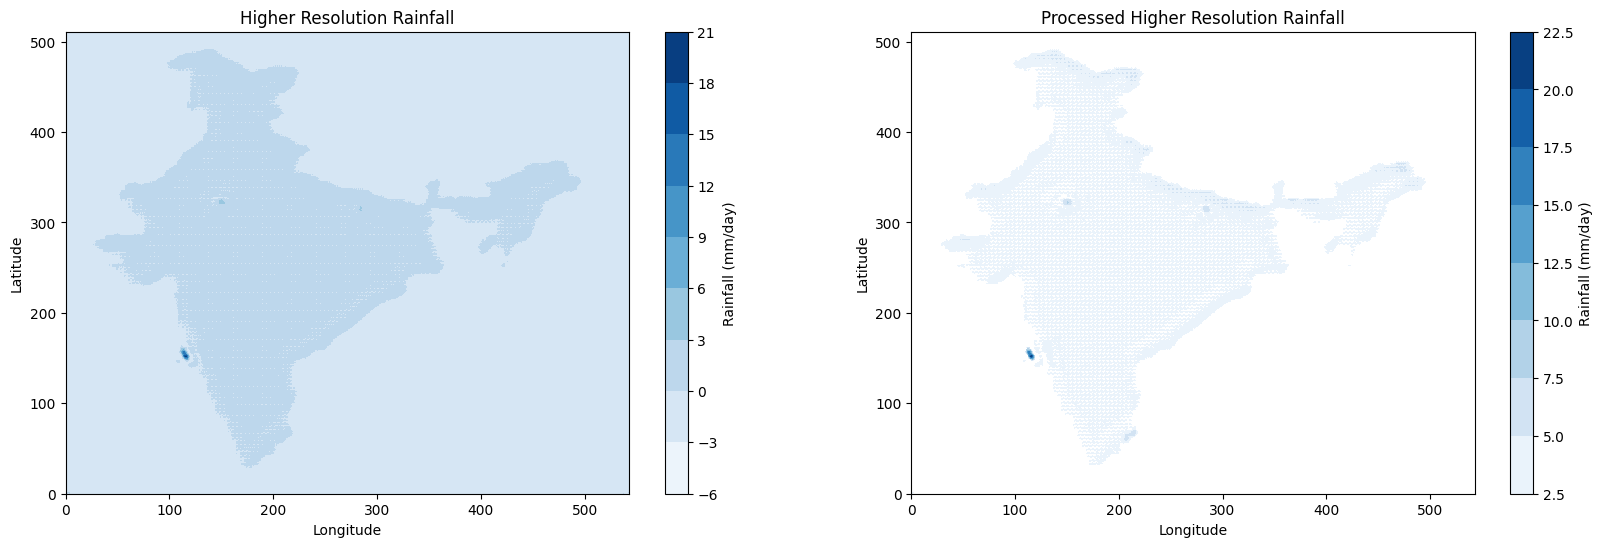

Epoch 1, Year 2020, Generator Loss: -583.5322265625, Discriminator Loss: -1267.689453125


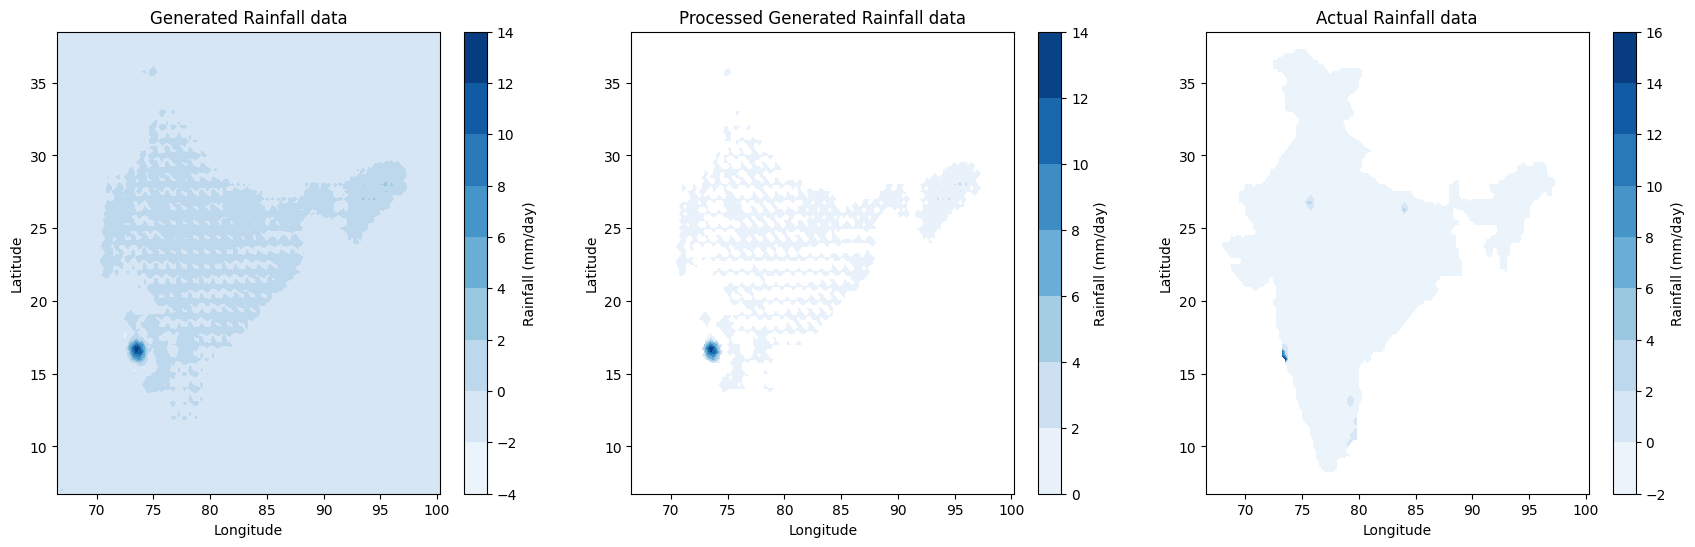

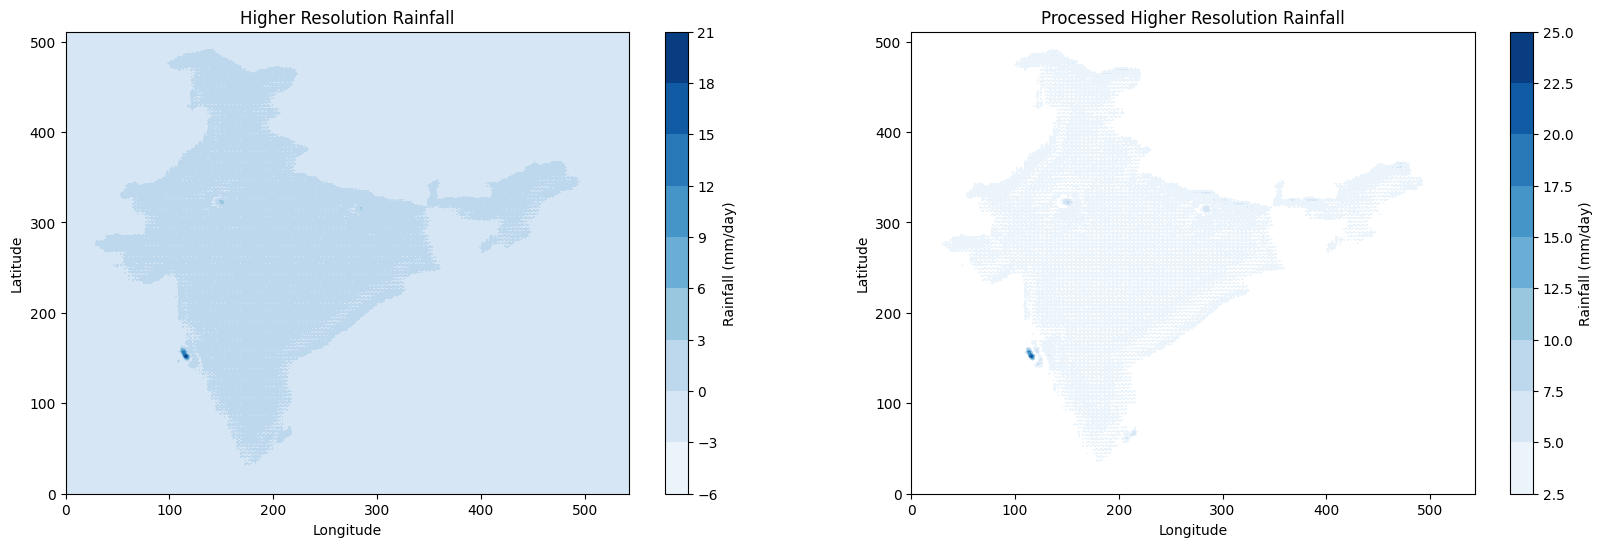

PSNR:27.72152204524736,SSIM:0.7959781492722119
Models saved after epoch 1
Epoch 2, Year 1910, Generator Loss: 542.9818115234375, Discriminator Loss: -1548.562744140625


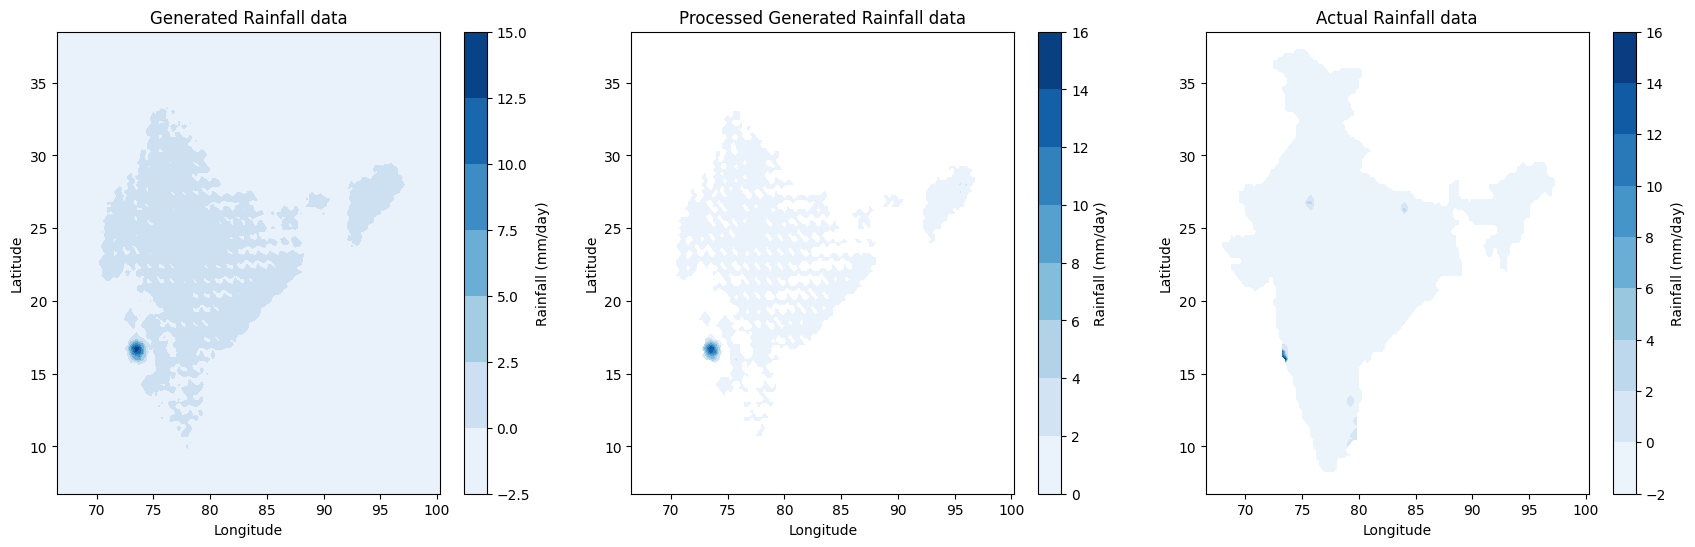

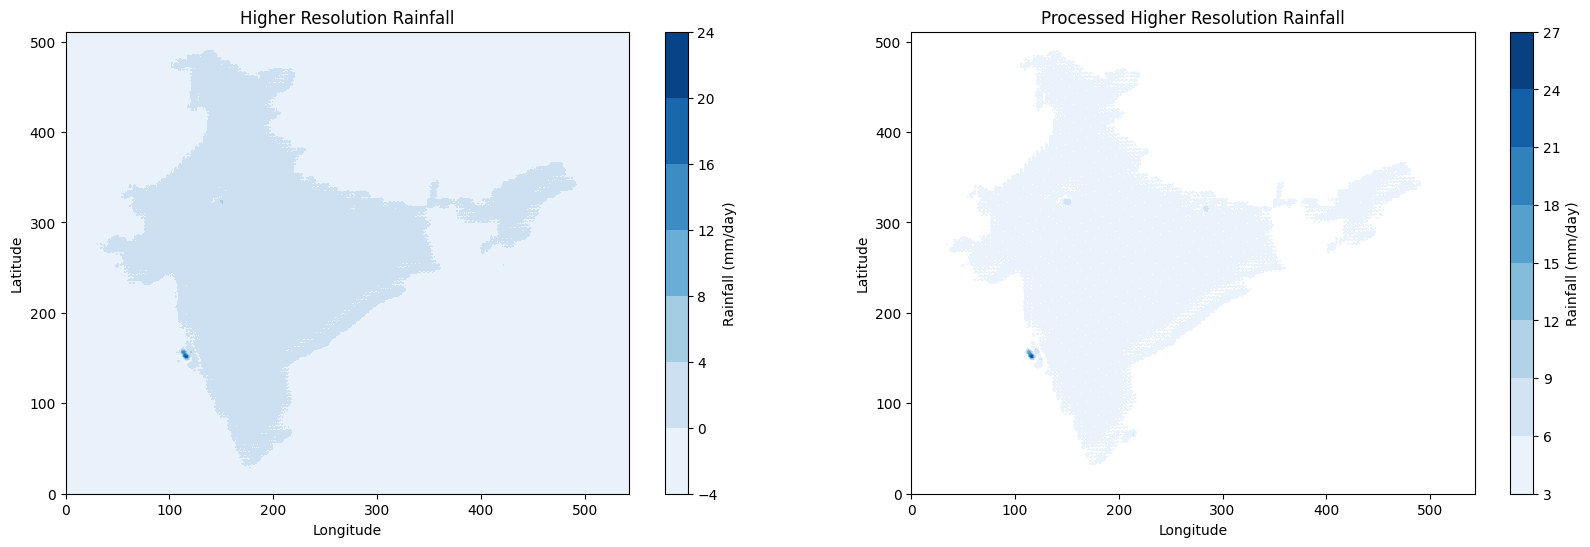

Epoch 2, Year 1920, Generator Loss: -1994.7911376953125, Discriminator Loss: -248.51171875


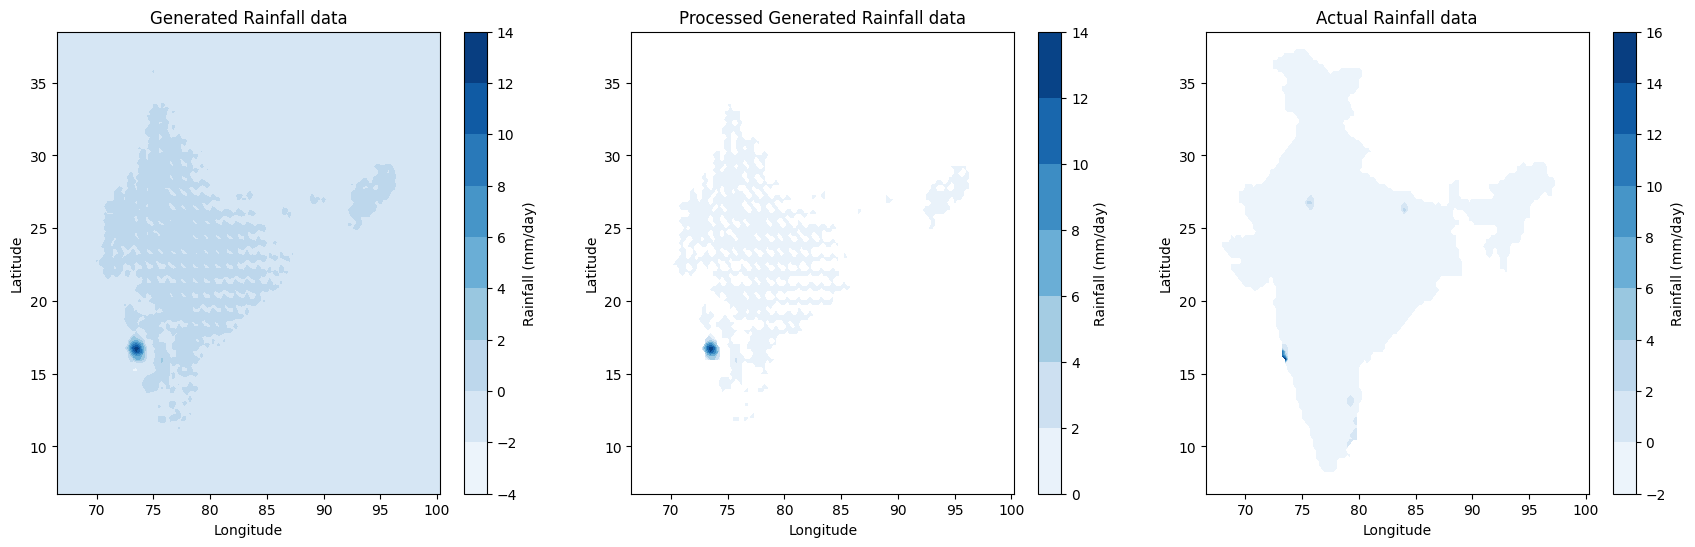

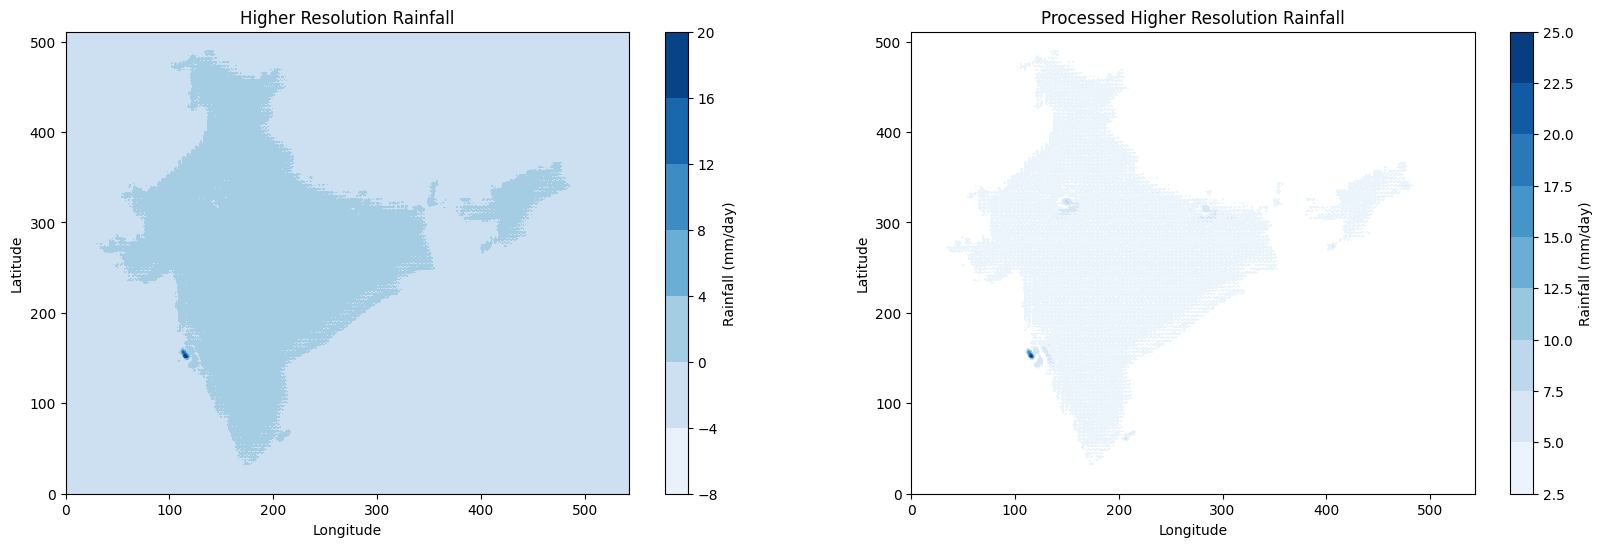

Epoch 2, Year 1930, Generator Loss: -1855.7047119140625, Discriminator Loss: -1809.9453125


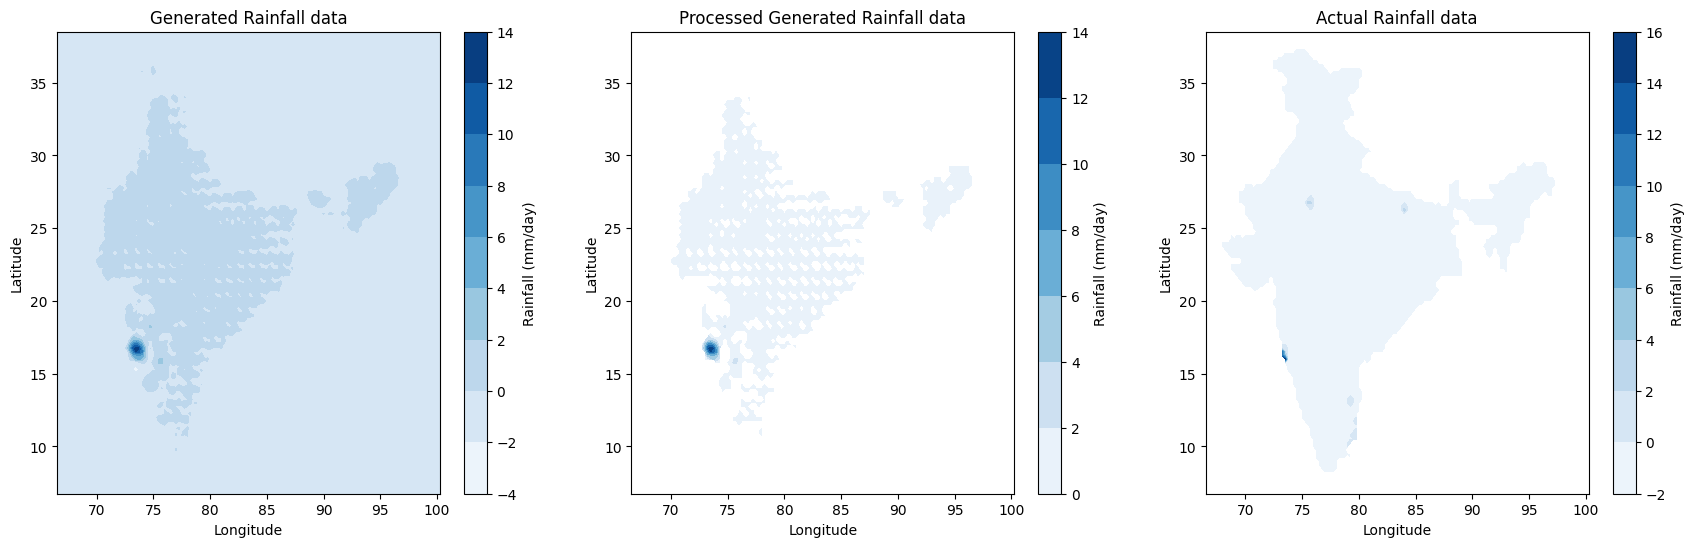

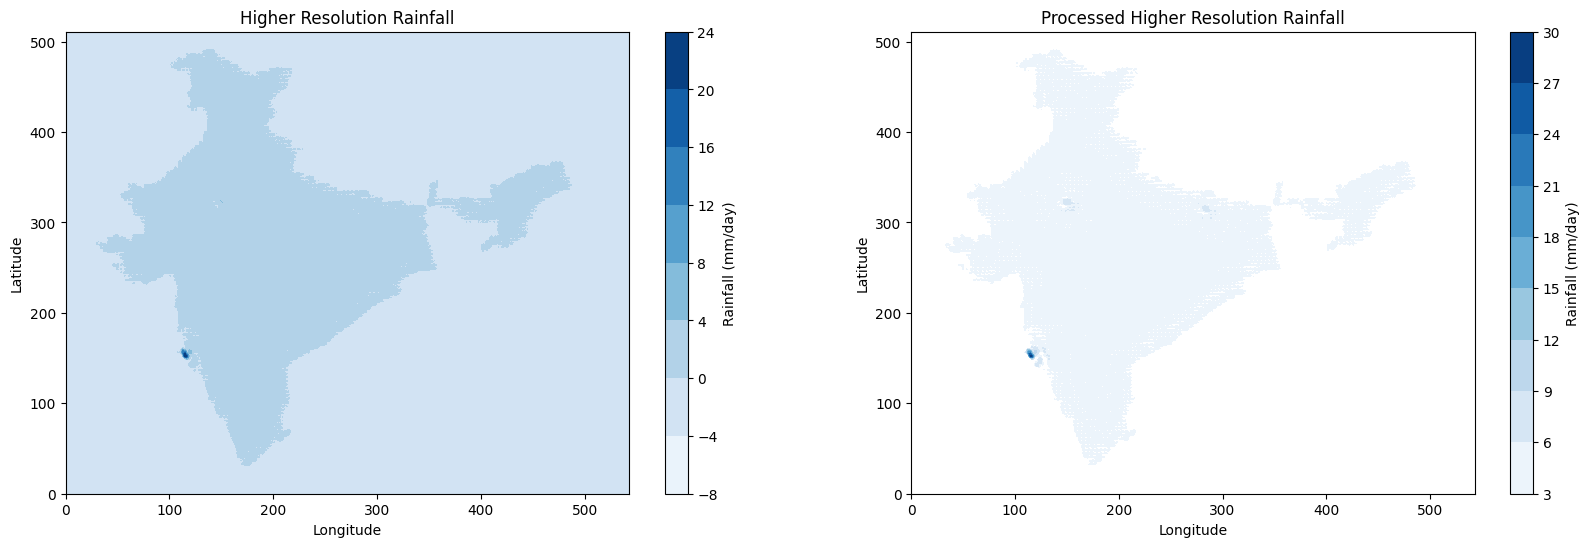

Epoch 2, Year 1940, Generator Loss: 683.7567749023438, Discriminator Loss: -898.2611083984375


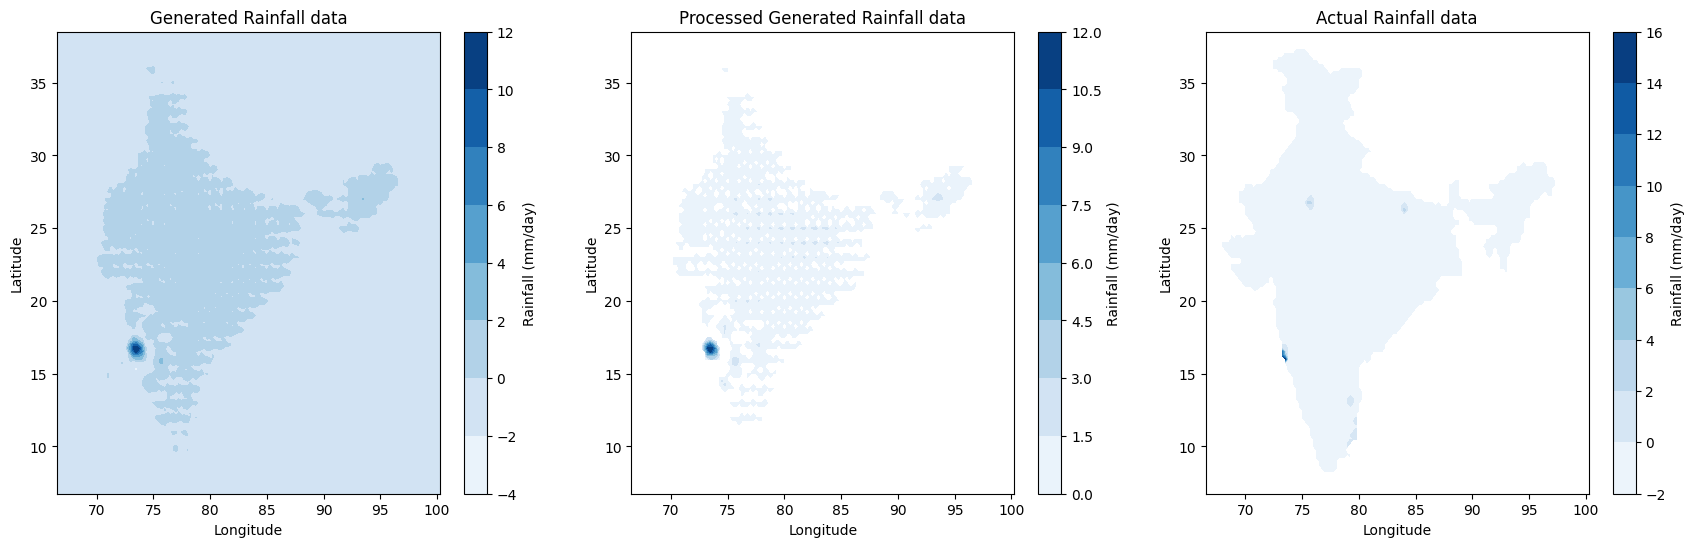

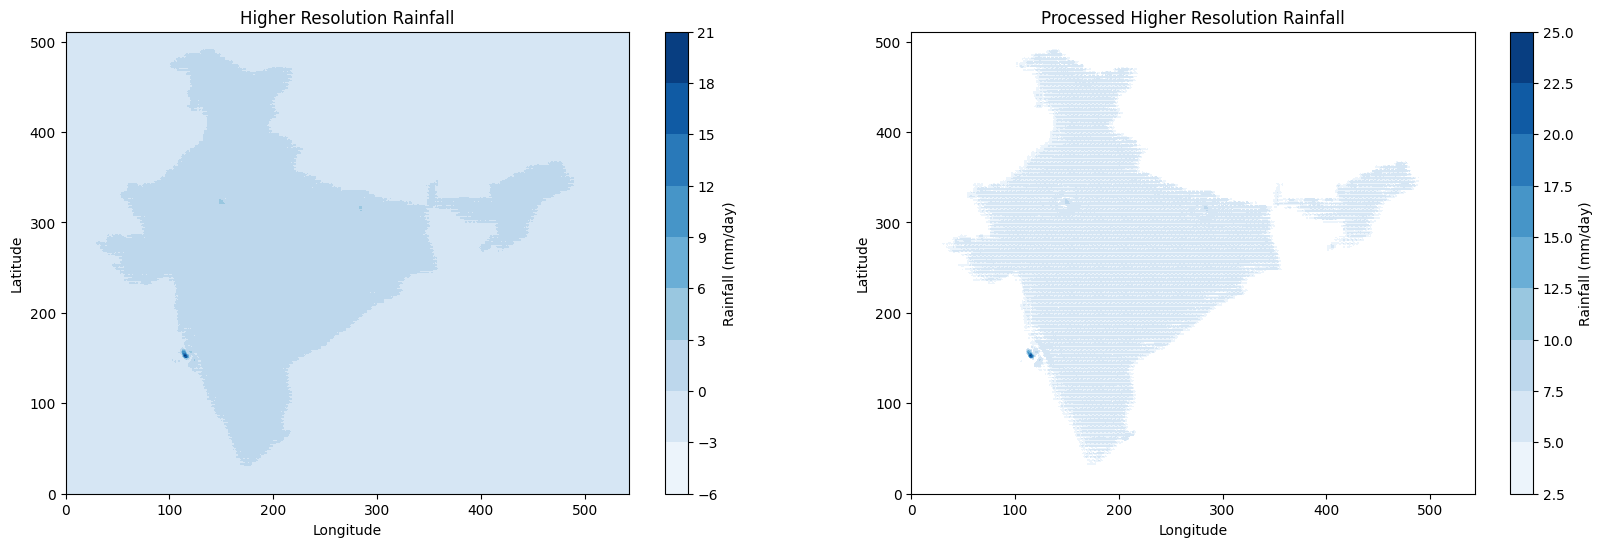

Epoch 2, Year 1950, Generator Loss: -1617.0528564453125, Discriminator Loss: -414.962158203125


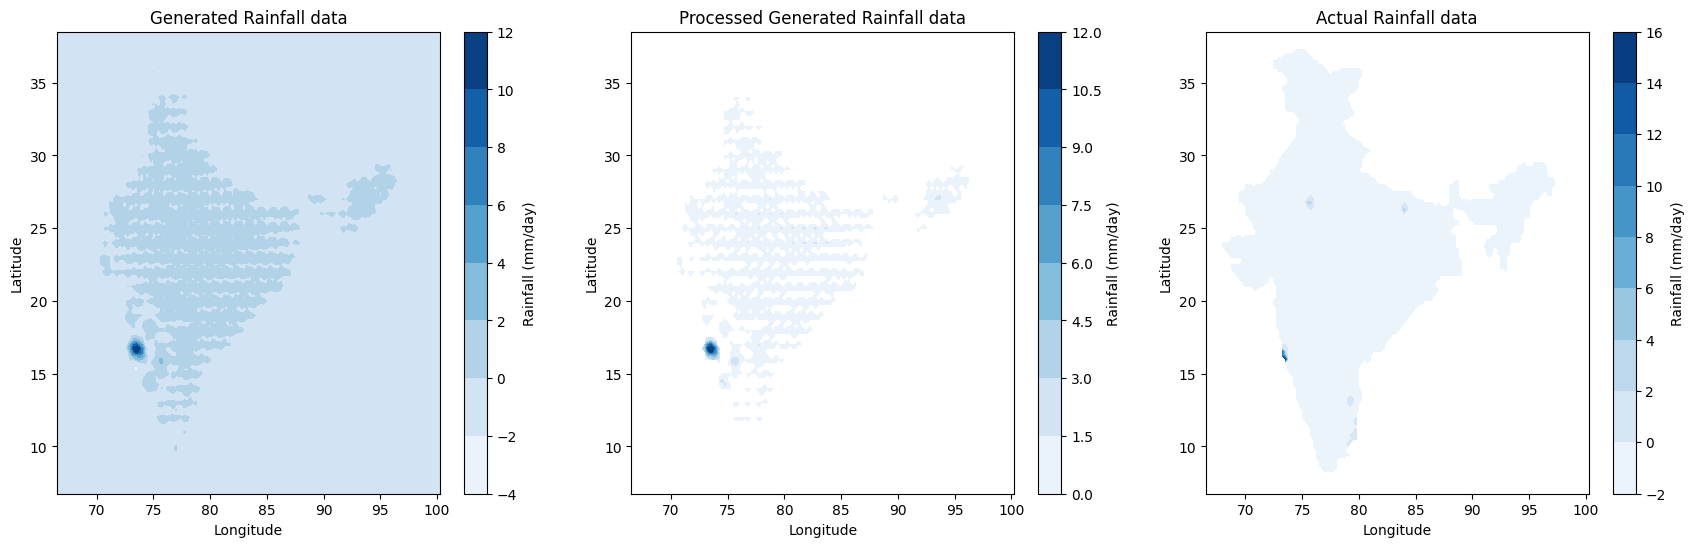

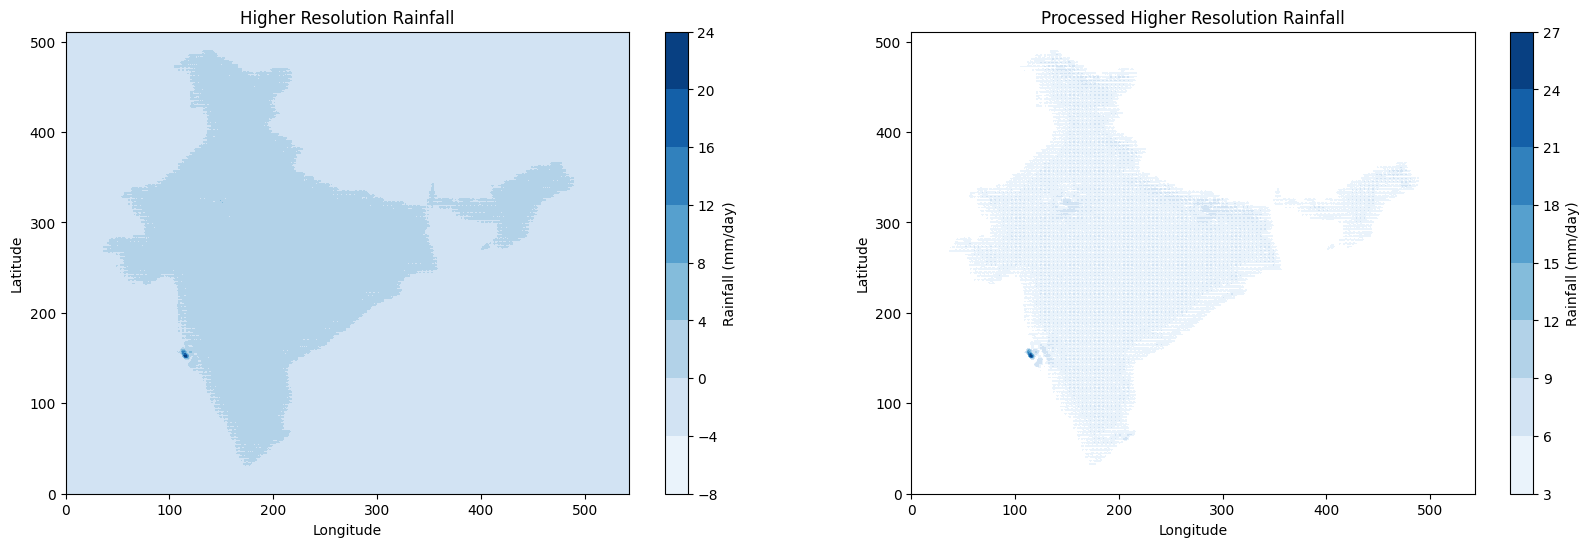

Epoch 2, Year 1960, Generator Loss: 362.73883056640625, Discriminator Loss: -805.9636840820312


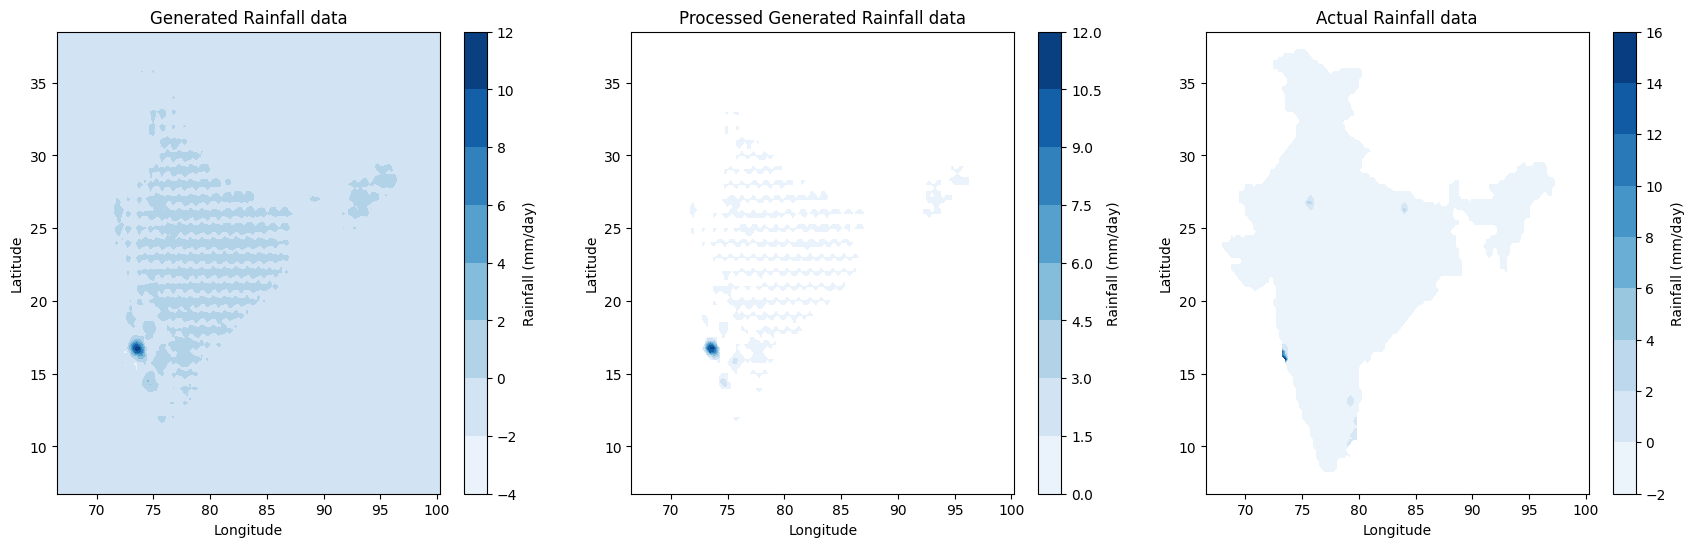

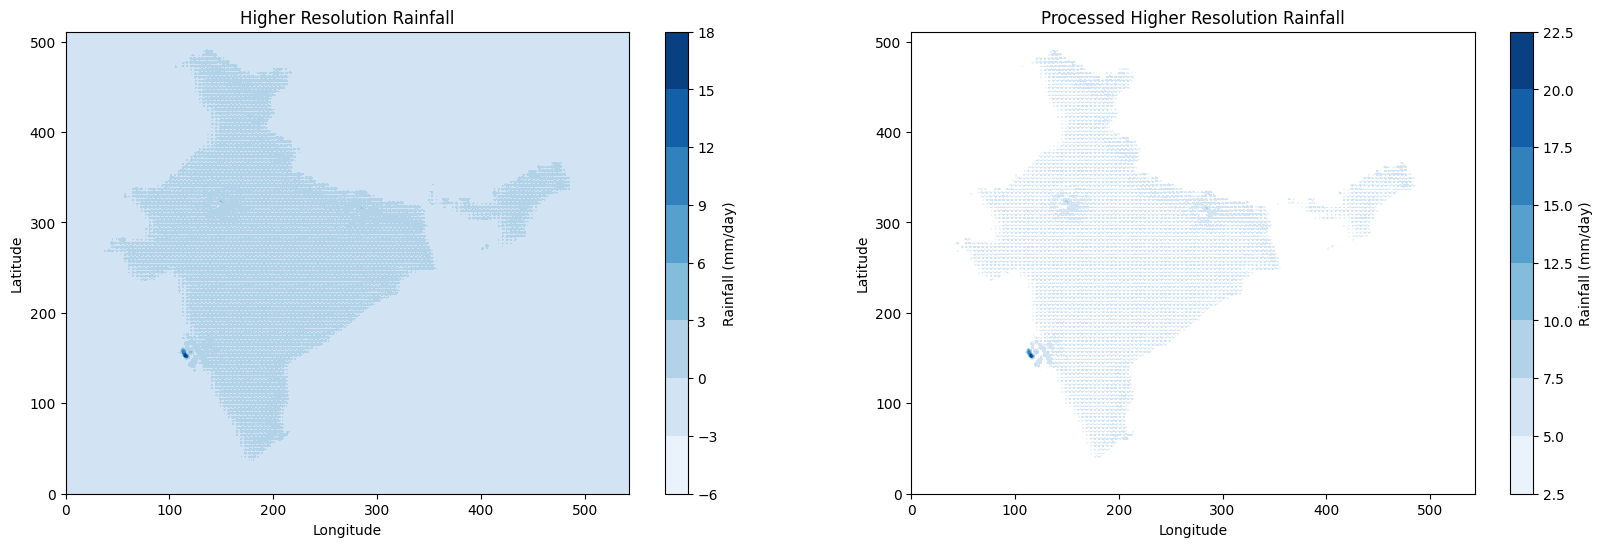

Epoch 2, Year 1990, Generator Loss: -188.8247833251953, Discriminator Loss: -1966.7130126953125


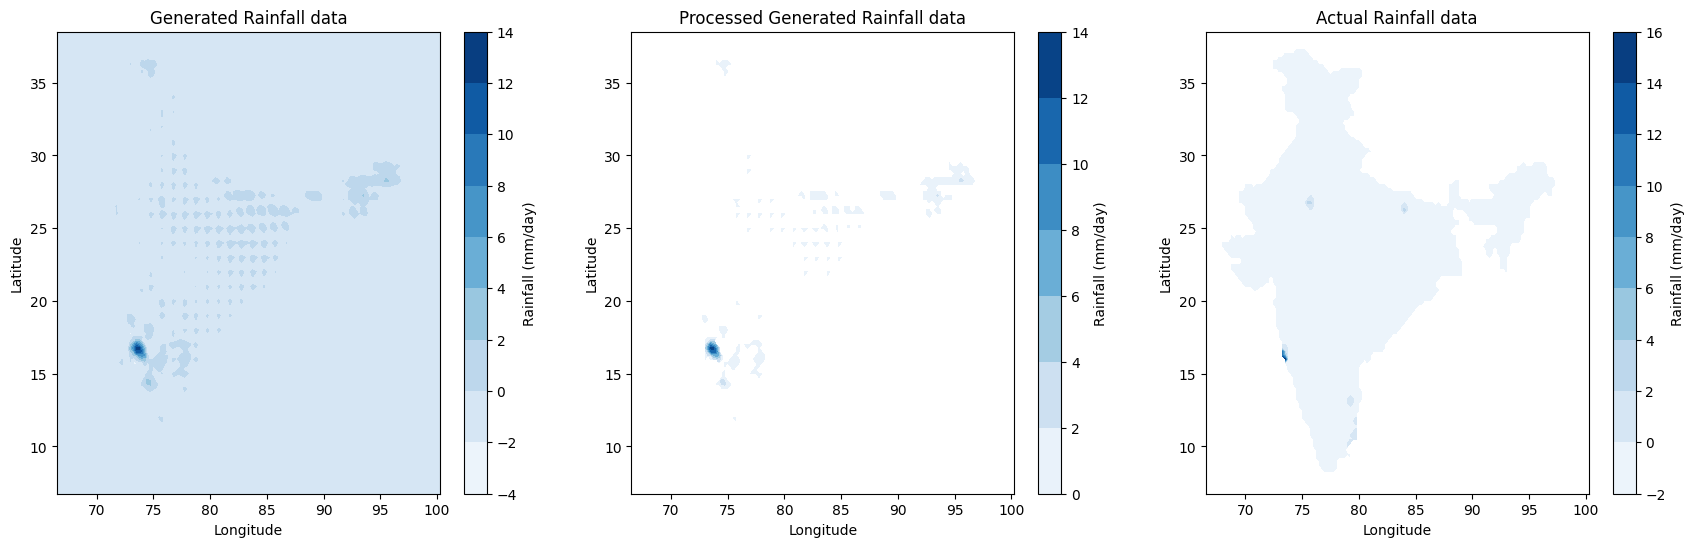

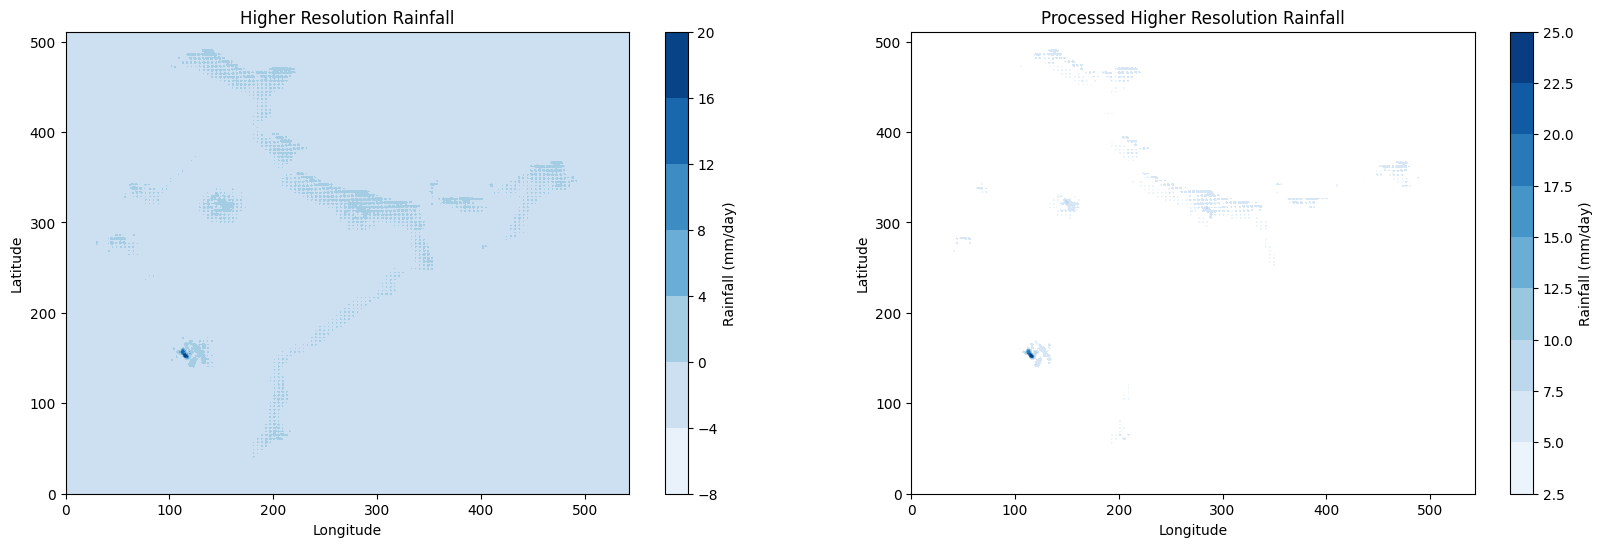

Epoch 2, Year 2000, Generator Loss: -343.34295654296875, Discriminator Loss: -1428.5672607421875


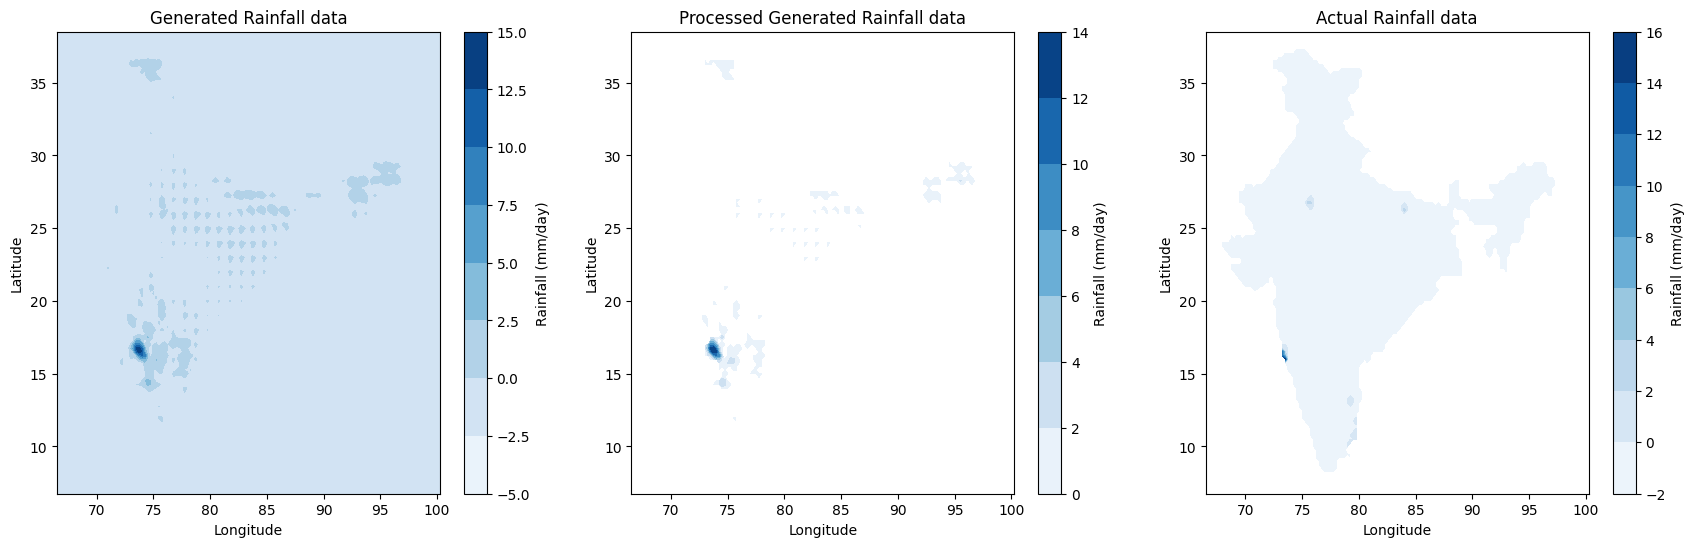

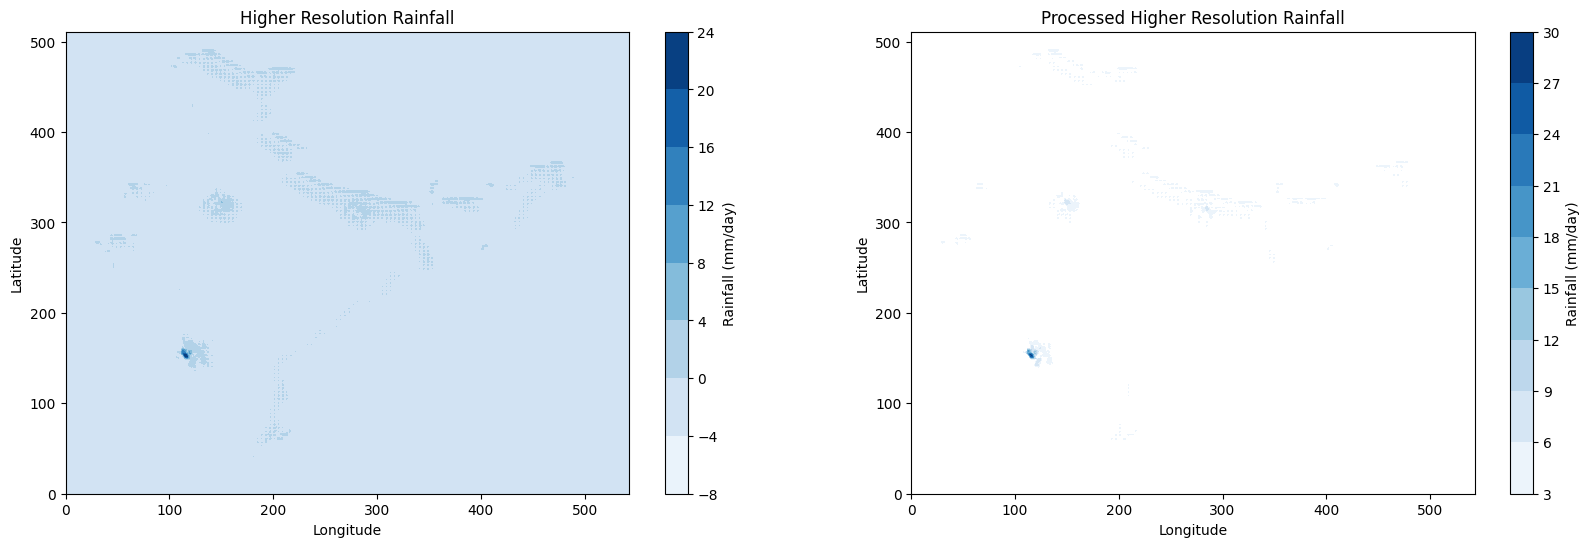

Epoch 2, Year 2010, Generator Loss: -479.7662353515625, Discriminator Loss: -1796.538330078125


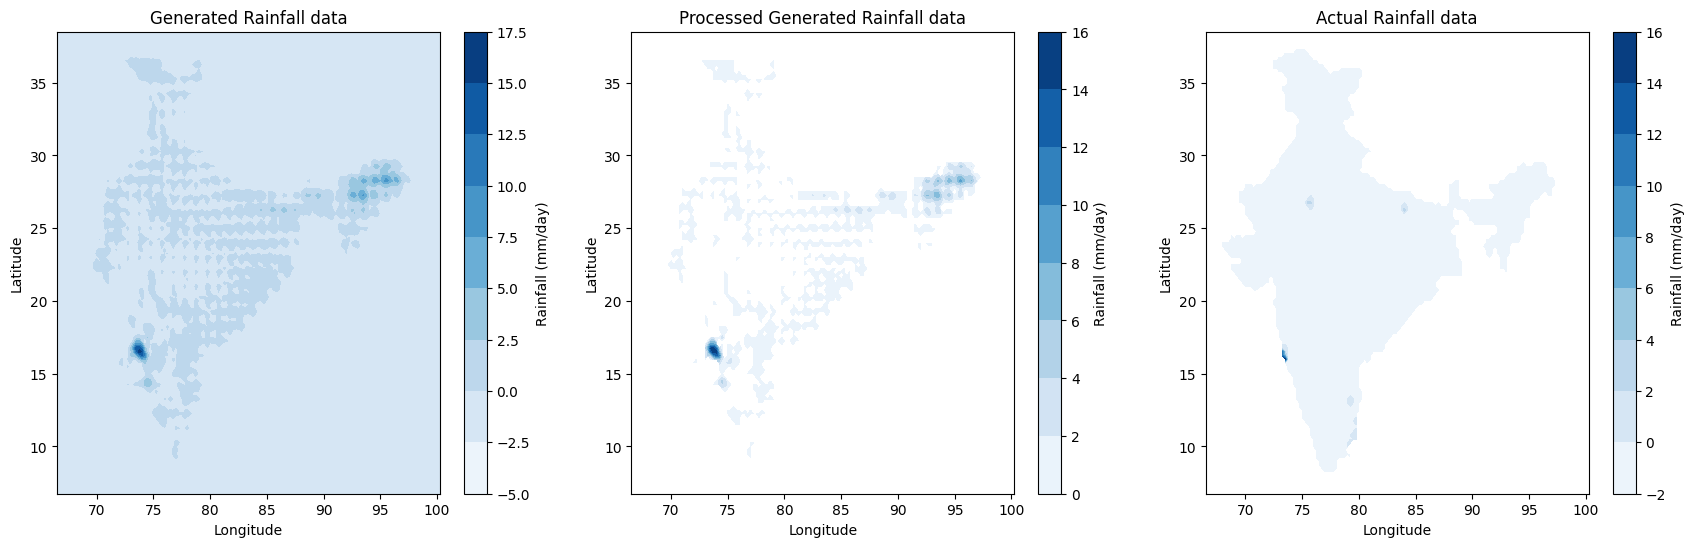

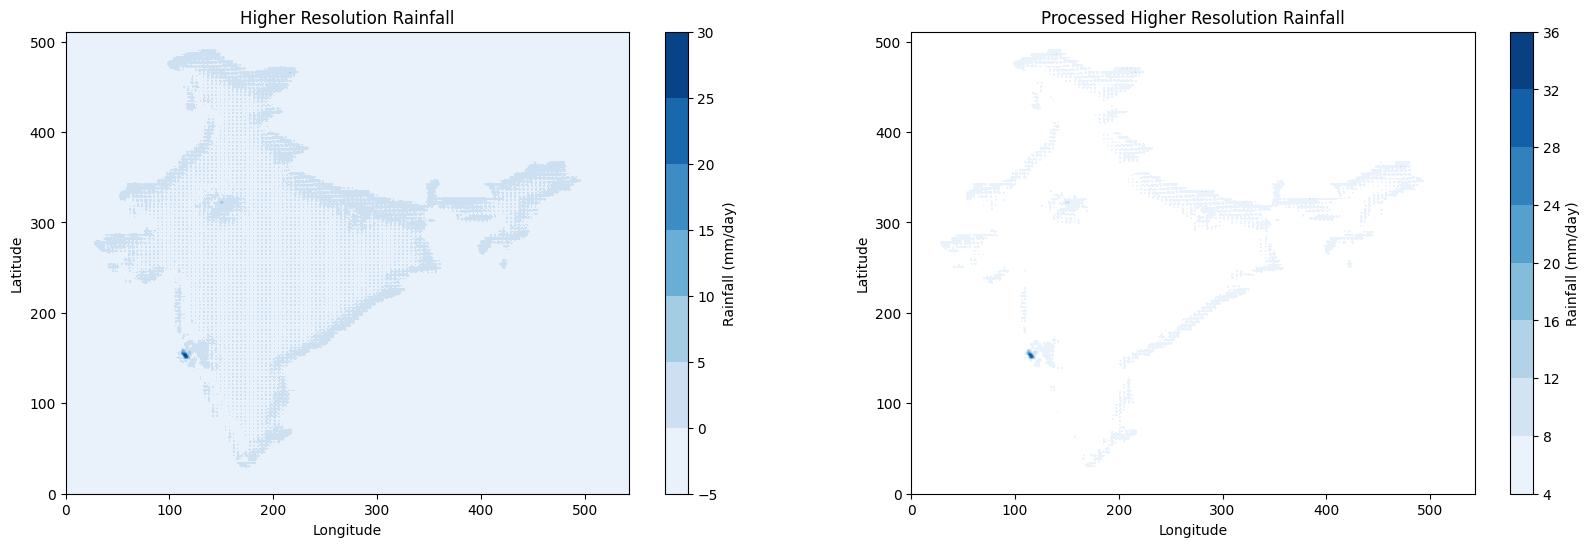

Epoch 2, Year 2020, Generator Loss: 841.5457153320312, Discriminator Loss: -1660.58935546875


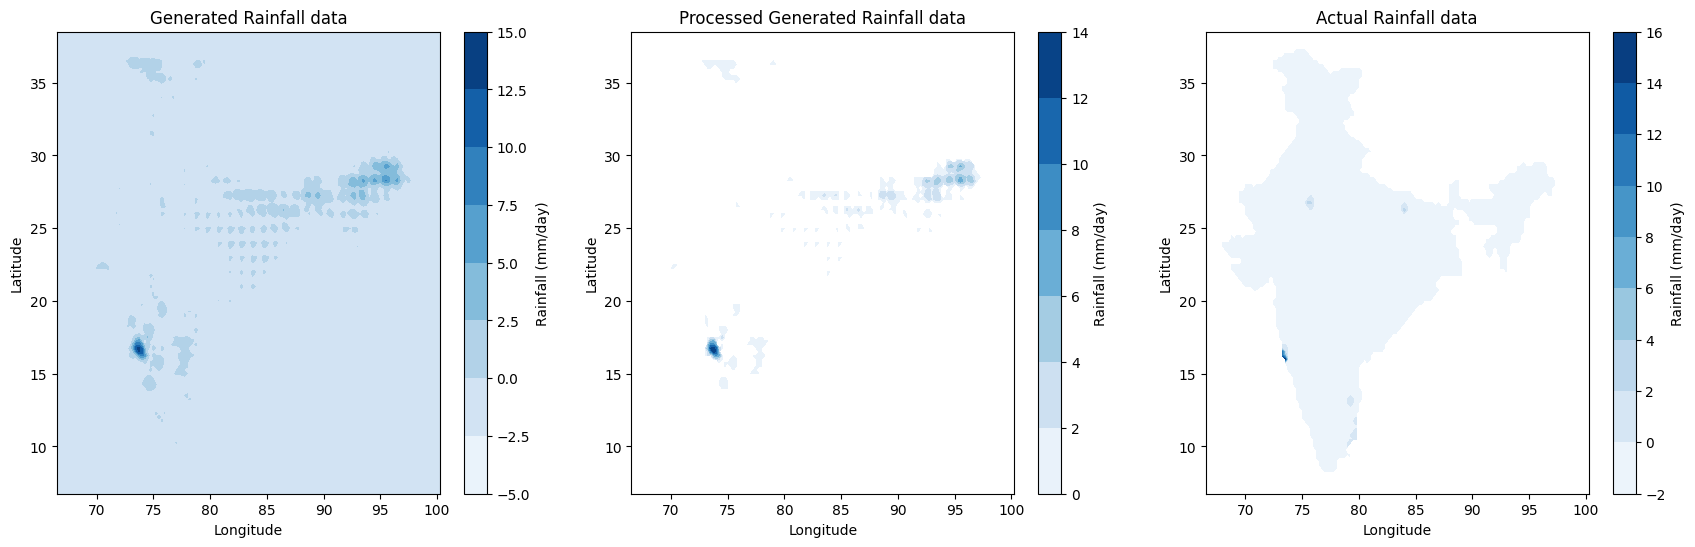

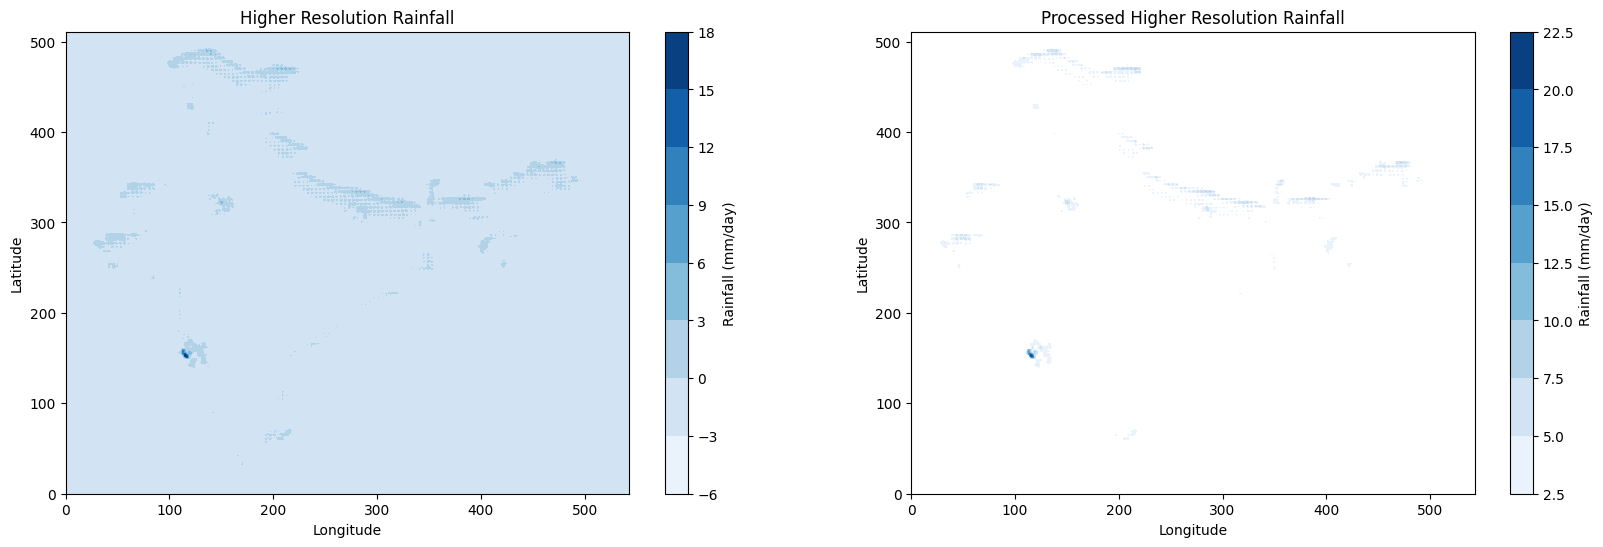

PSNR:27.57864087113823,SSIM:0.790689758960067
Models saved after epoch 2
Epoch 3, Year 1910, Generator Loss: 2506.837646484375, Discriminator Loss: -1069.6767578125


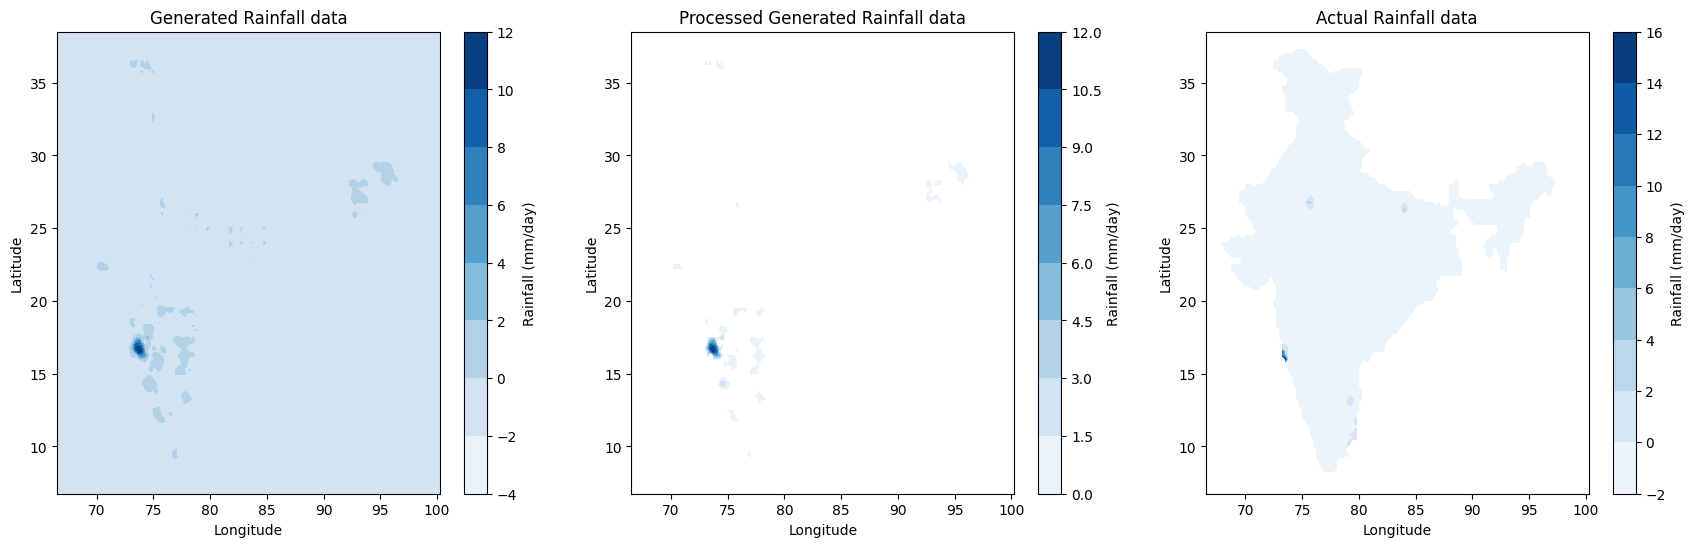

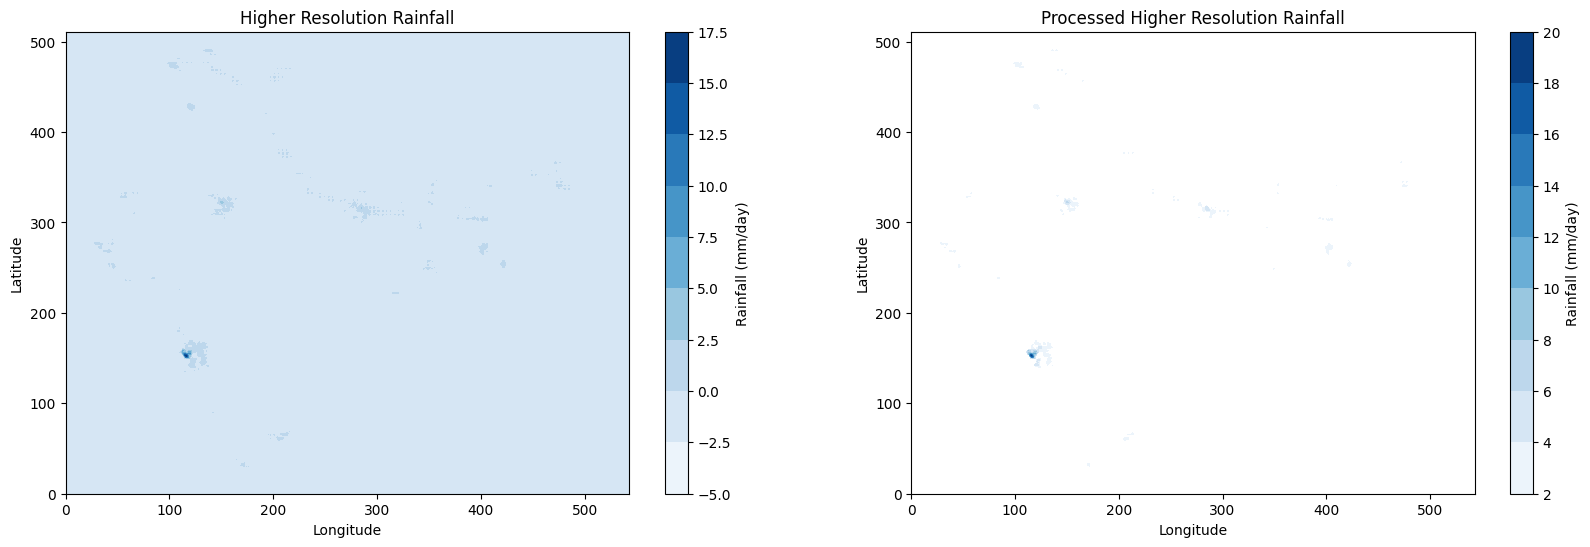

Epoch 3, Year 1920, Generator Loss: 1074.556884765625, Discriminator Loss: -1044.4639892578125


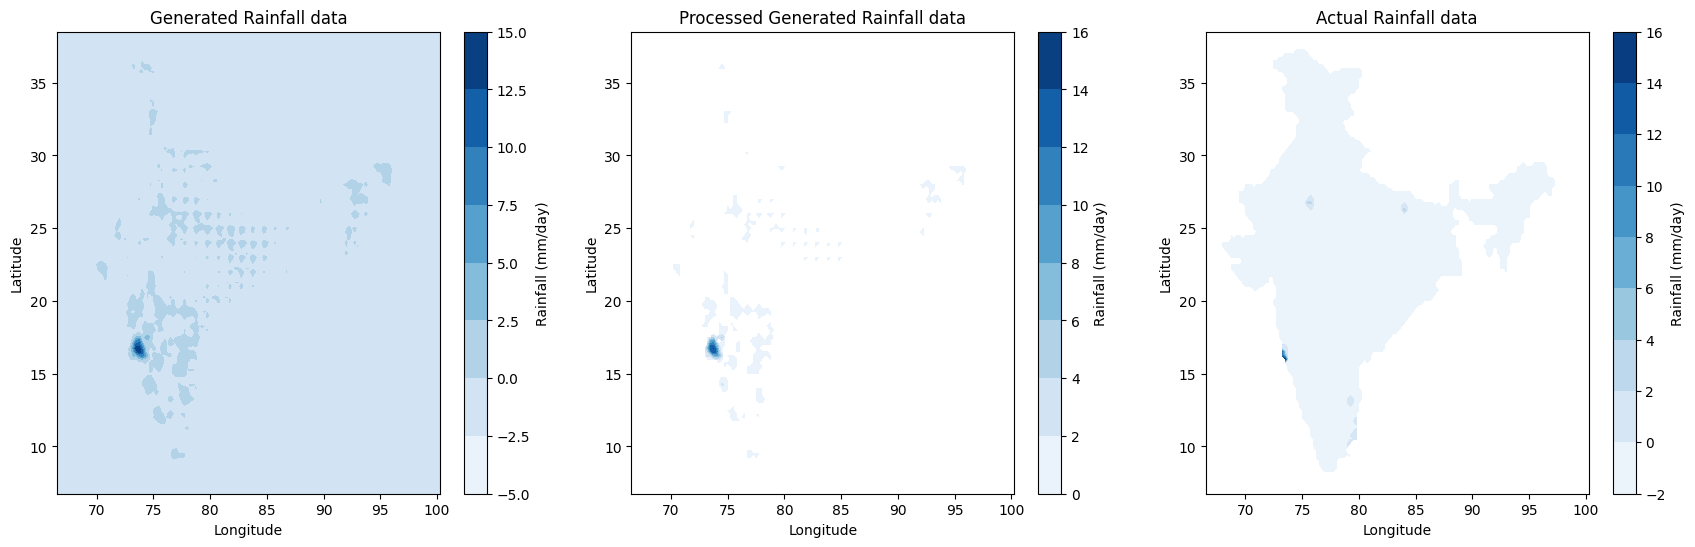

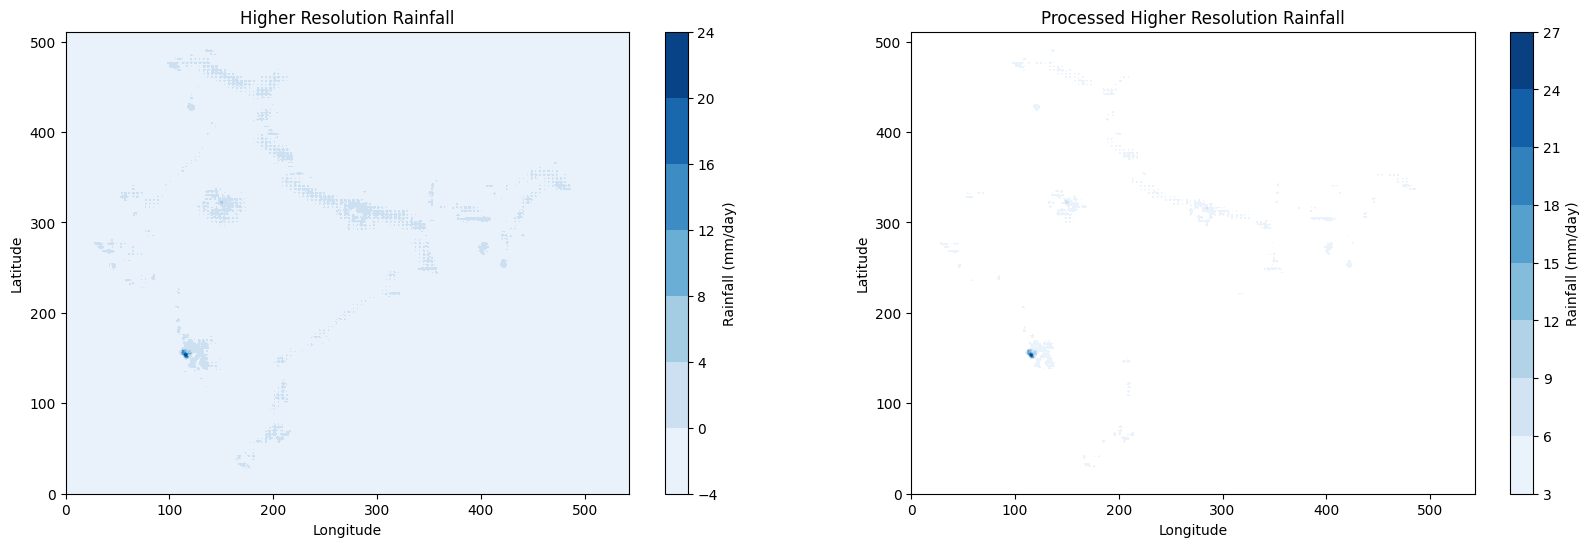

Epoch 3, Year 1930, Generator Loss: 414.2435302734375, Discriminator Loss: -1100.876953125
Epoch 3, Year 1940, Generator Loss: -983.8296508789062, Discriminator Loss: -1197.6728515625


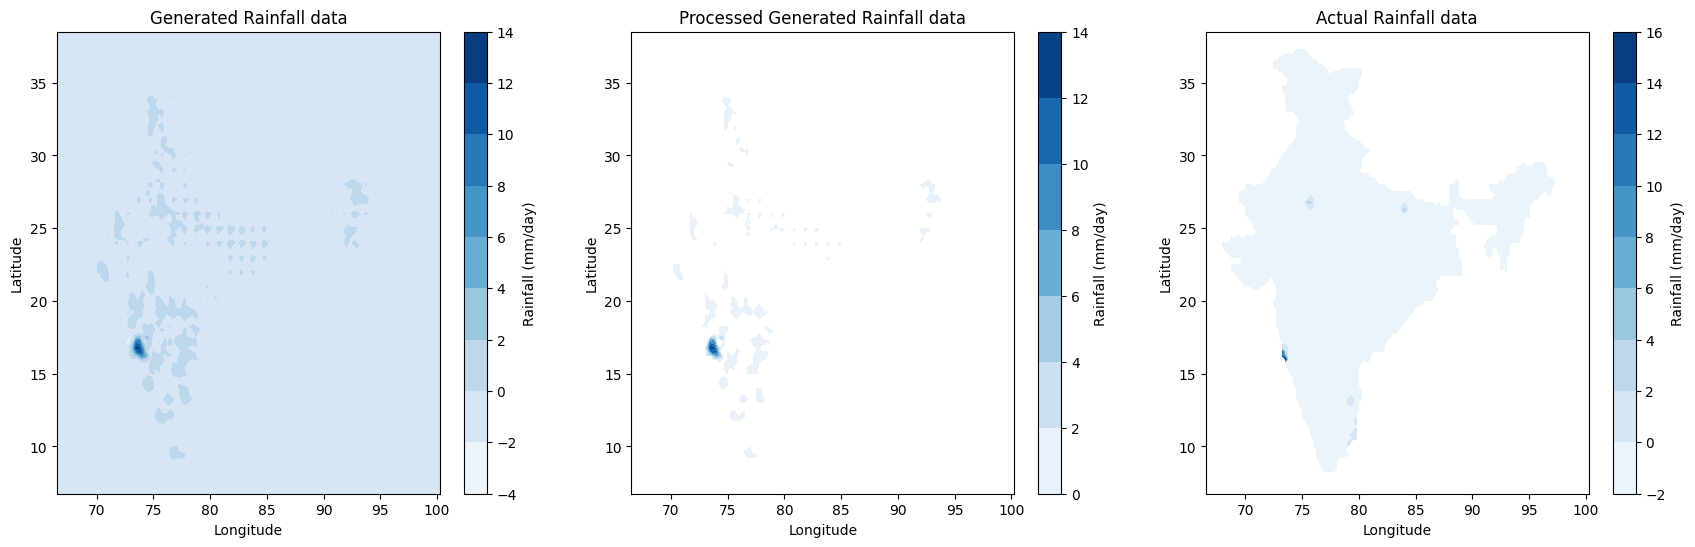

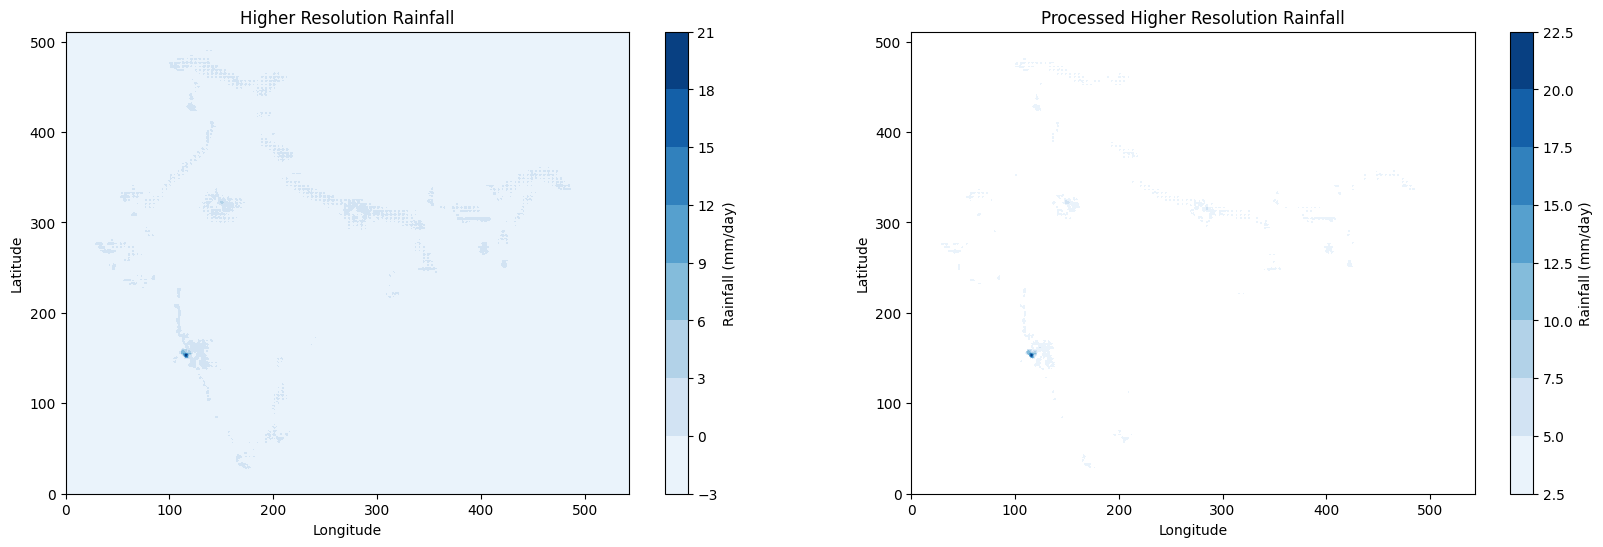

Epoch 3, Year 1950, Generator Loss: -1329.4361572265625, Discriminator Loss: -960.2410888671875


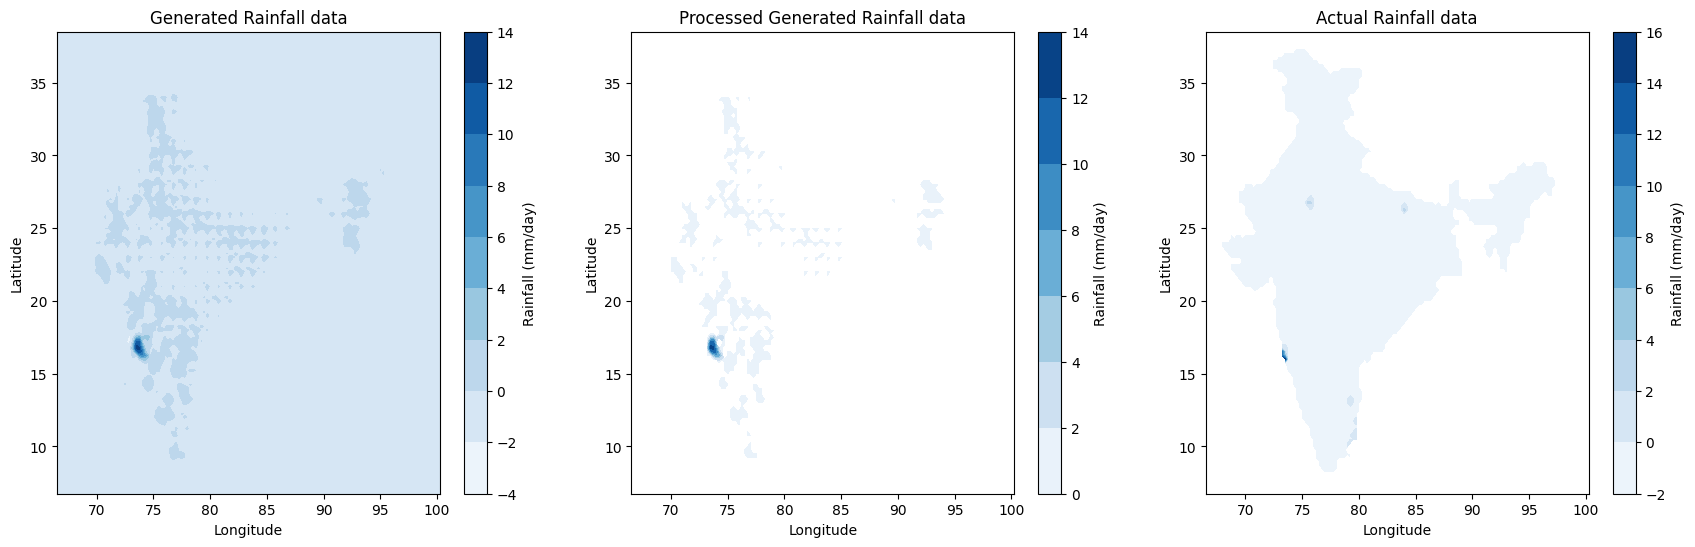

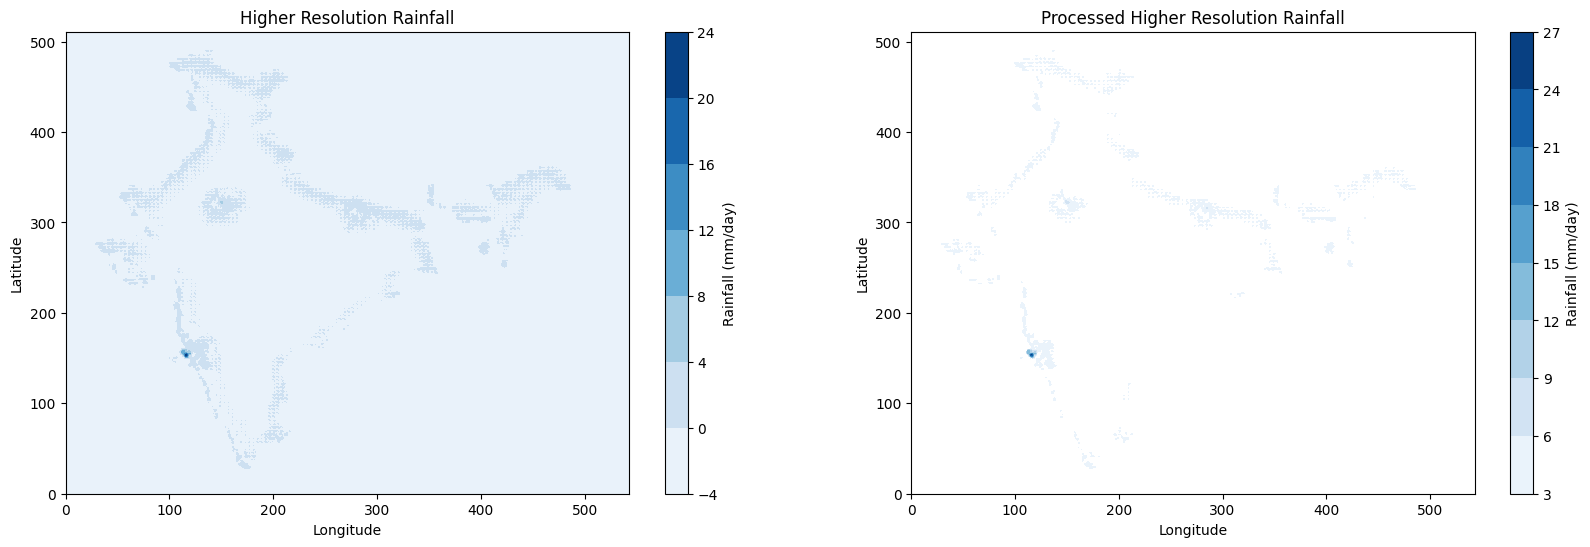

Epoch 3, Year 1960, Generator Loss: 375.5736389160156, Discriminator Loss: -1250.2821044921875


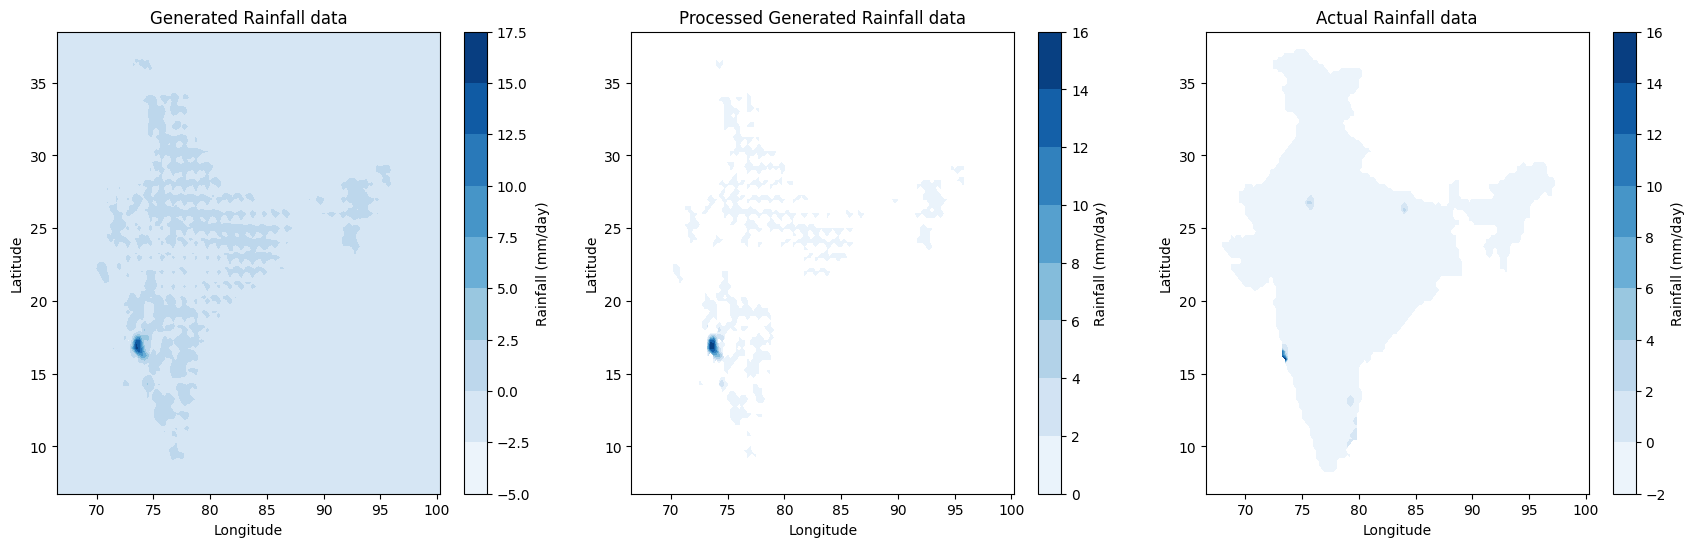

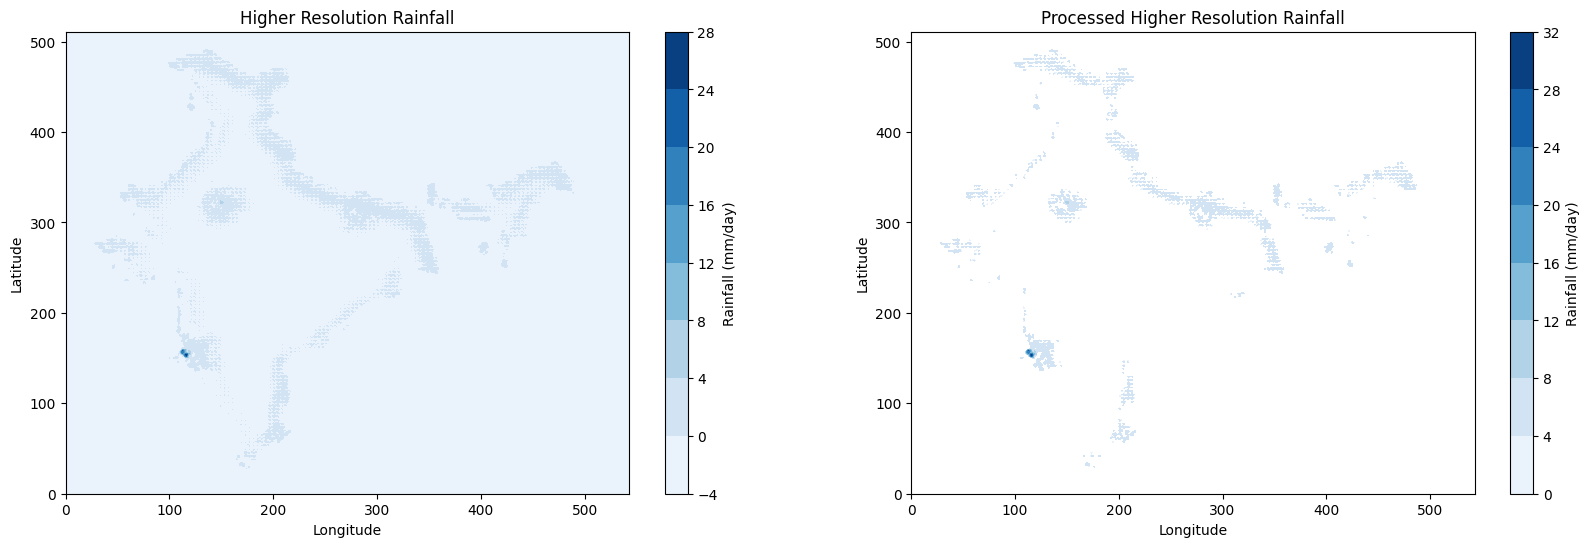

Epoch 3, Year 1970, Generator Loss: 187.29946899414062, Discriminator Loss: -834.3554077148438


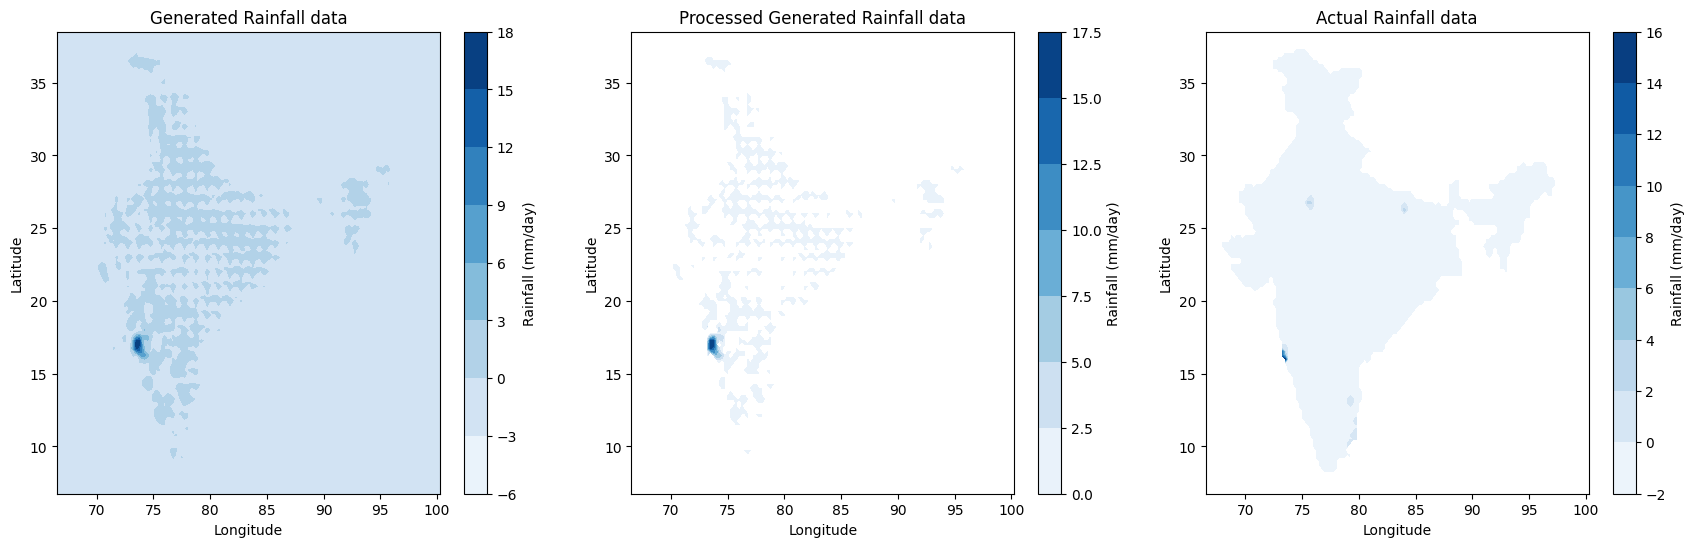

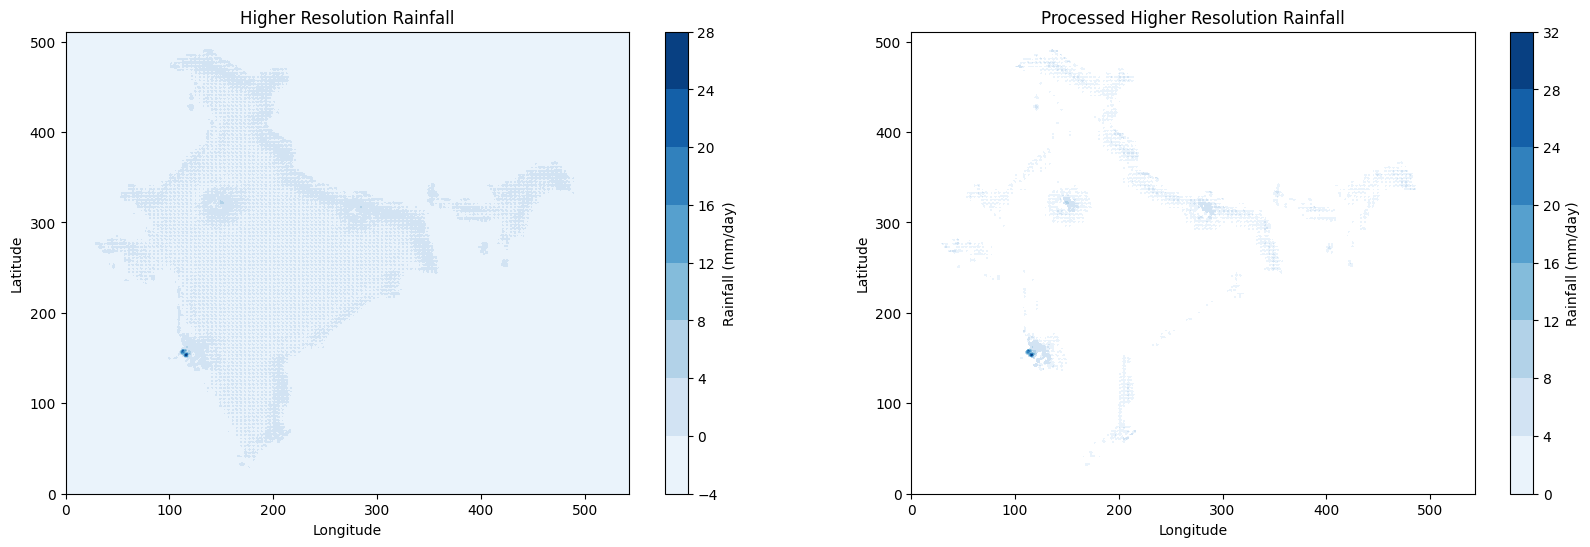

Epoch 3, Year 1980, Generator Loss: 557.4682006835938, Discriminator Loss: -1283.7574462890625


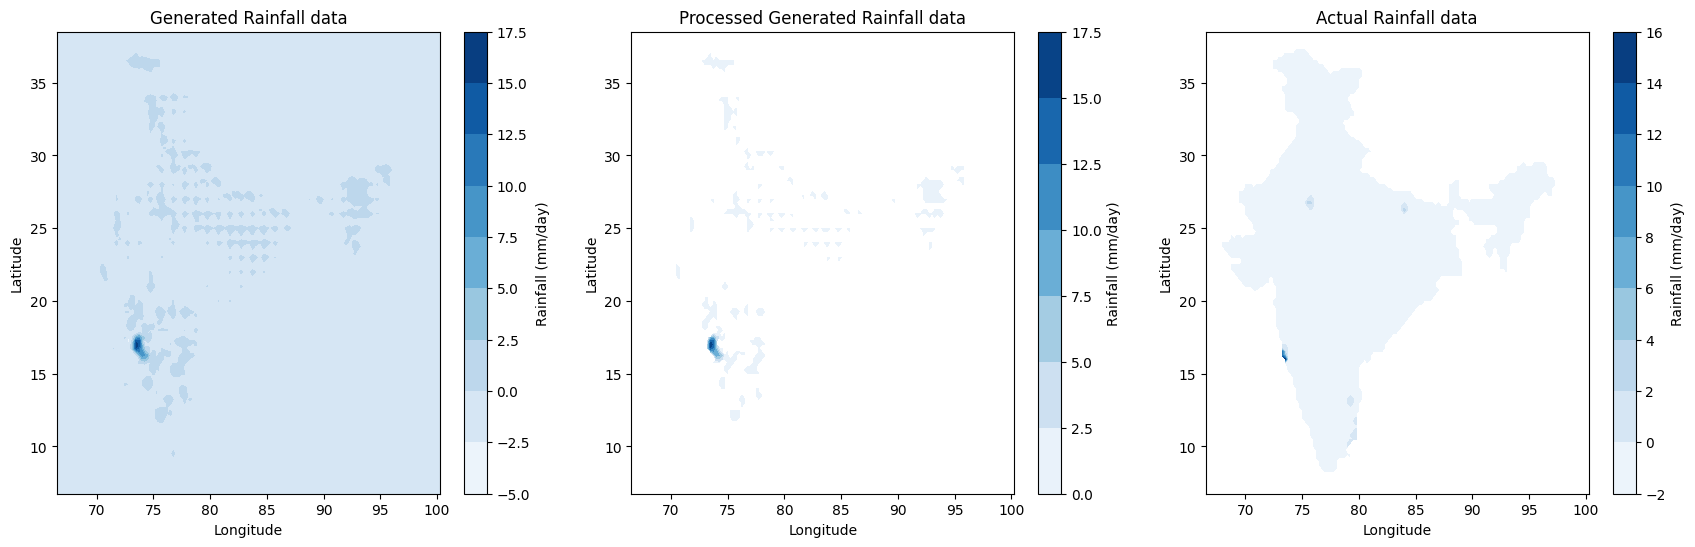

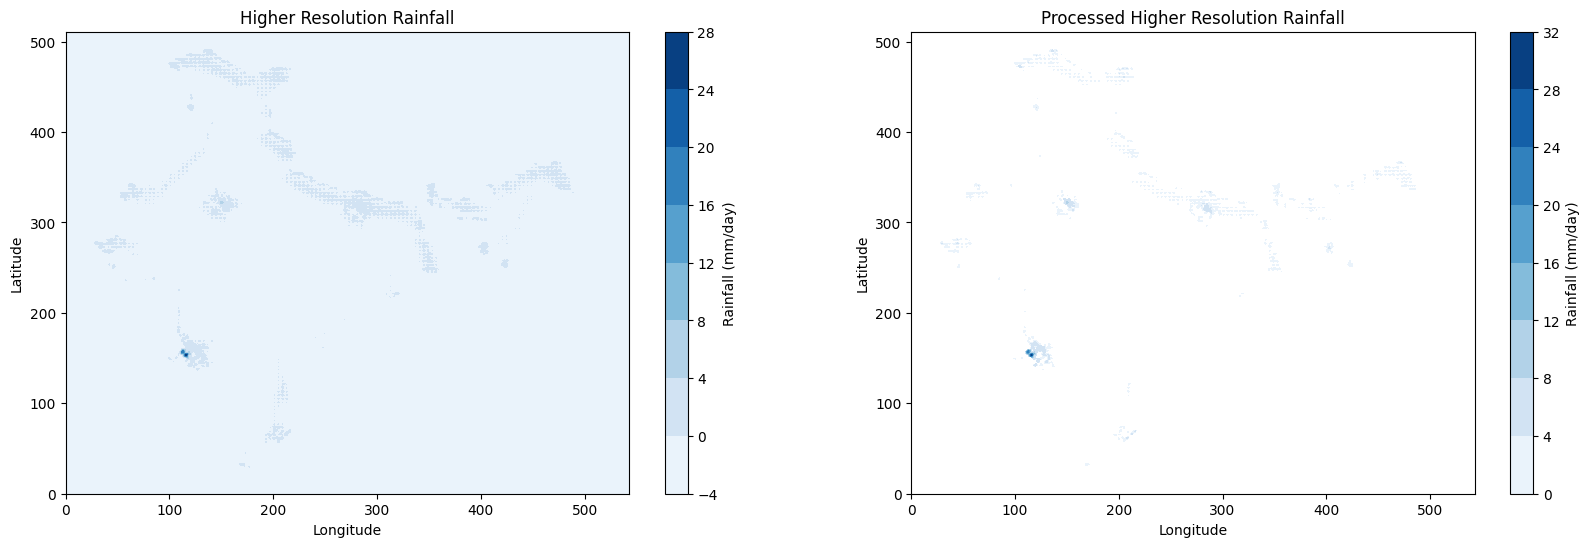

Epoch 3, Year 1990, Generator Loss: 370.0570373535156, Discriminator Loss: -1451.38818359375


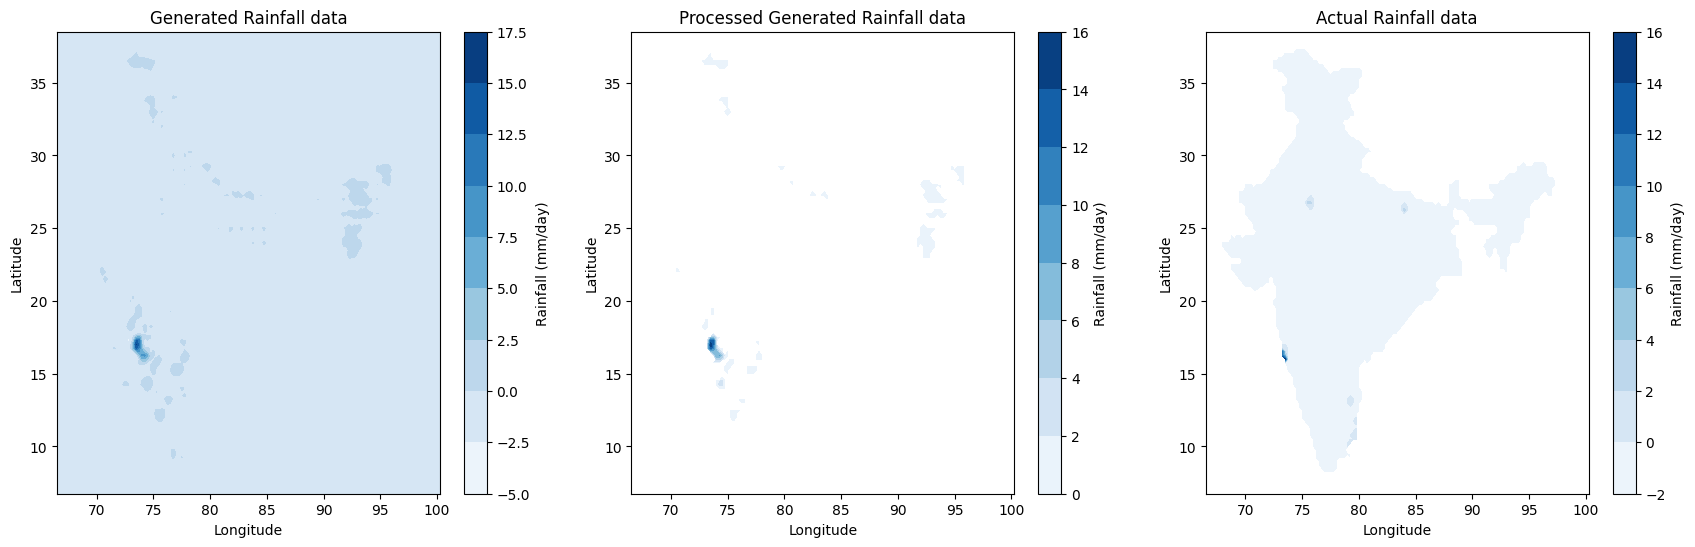

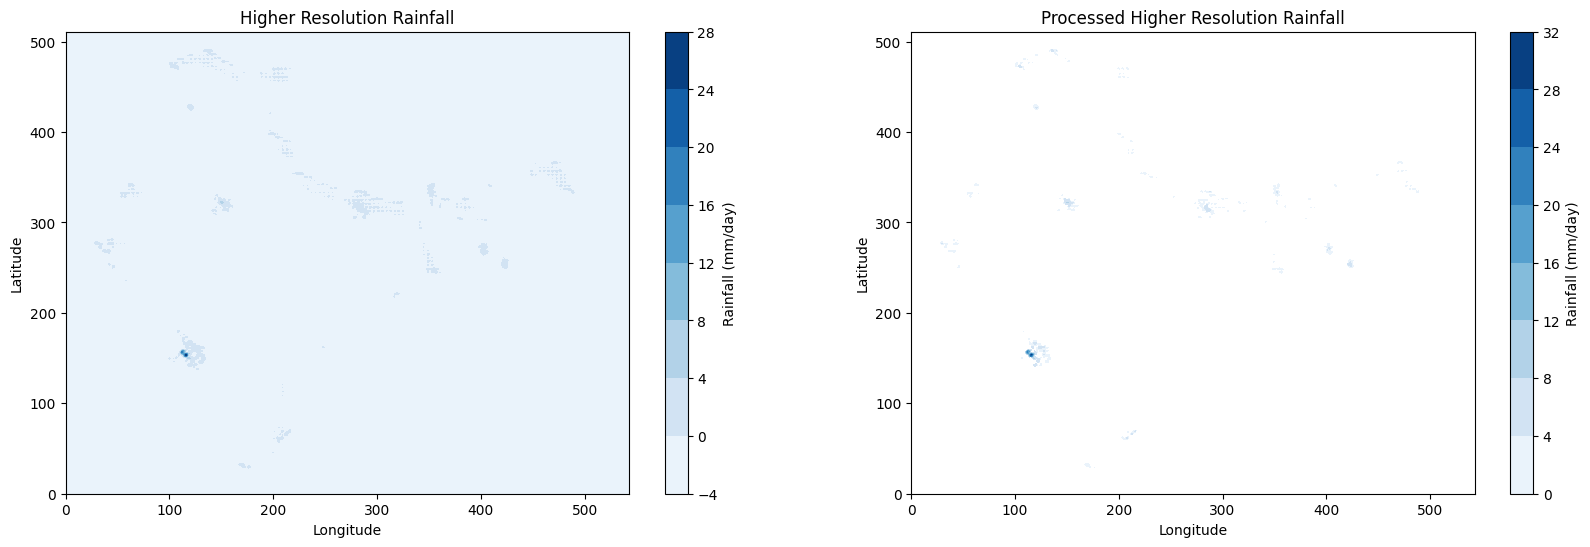

Epoch 3, Year 2000, Generator Loss: -395.24468994140625, Discriminator Loss: -1355.9676513671875


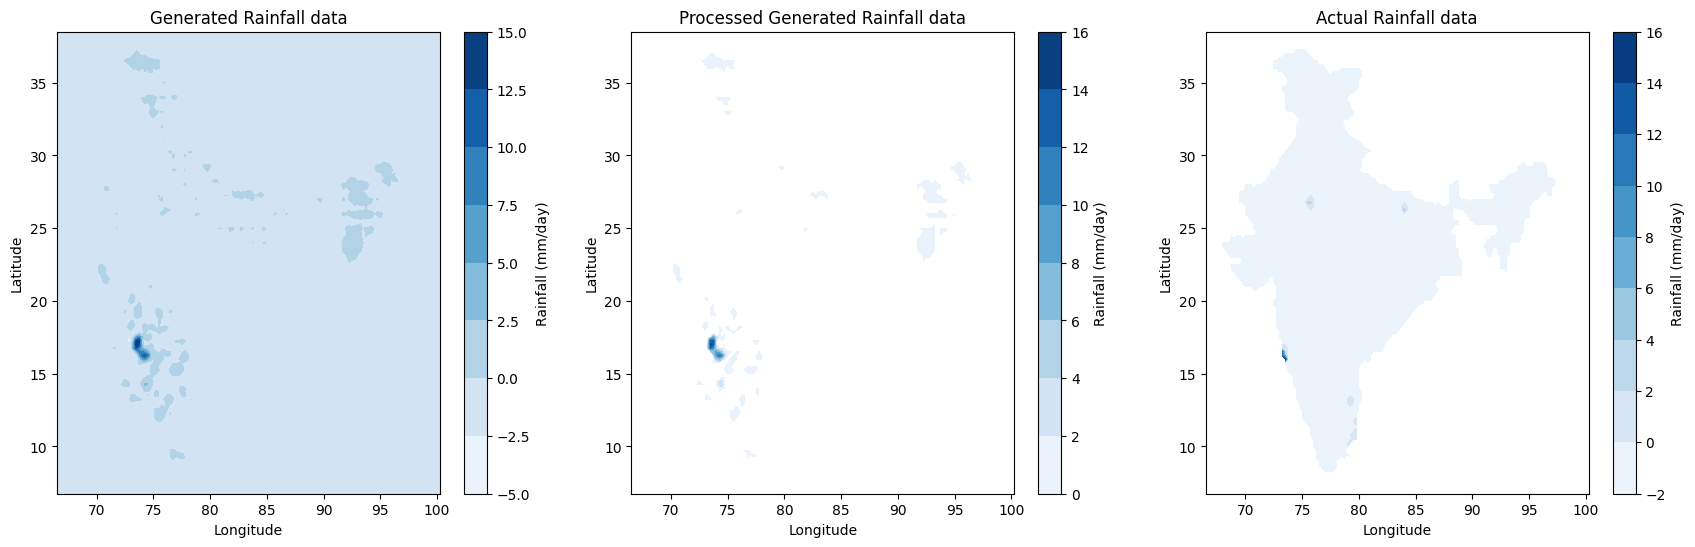

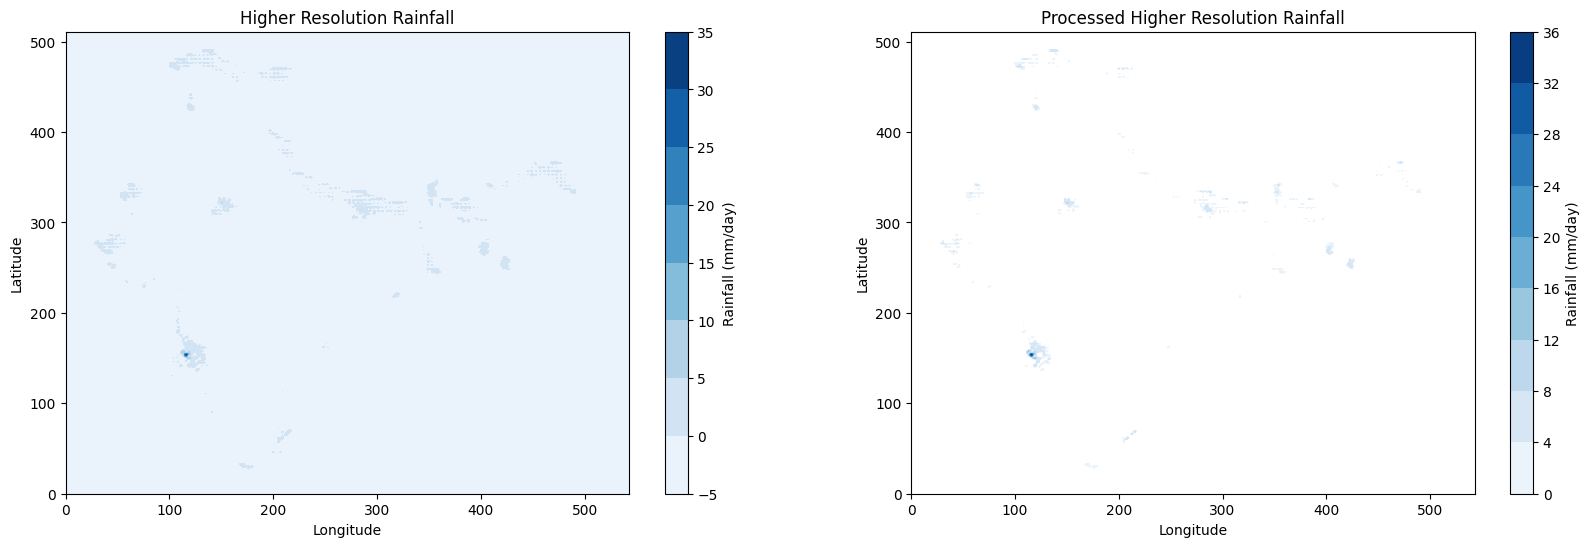

Epoch 3, Year 2010, Generator Loss: -883.5903930664062, Discriminator Loss: -3662.2509765625


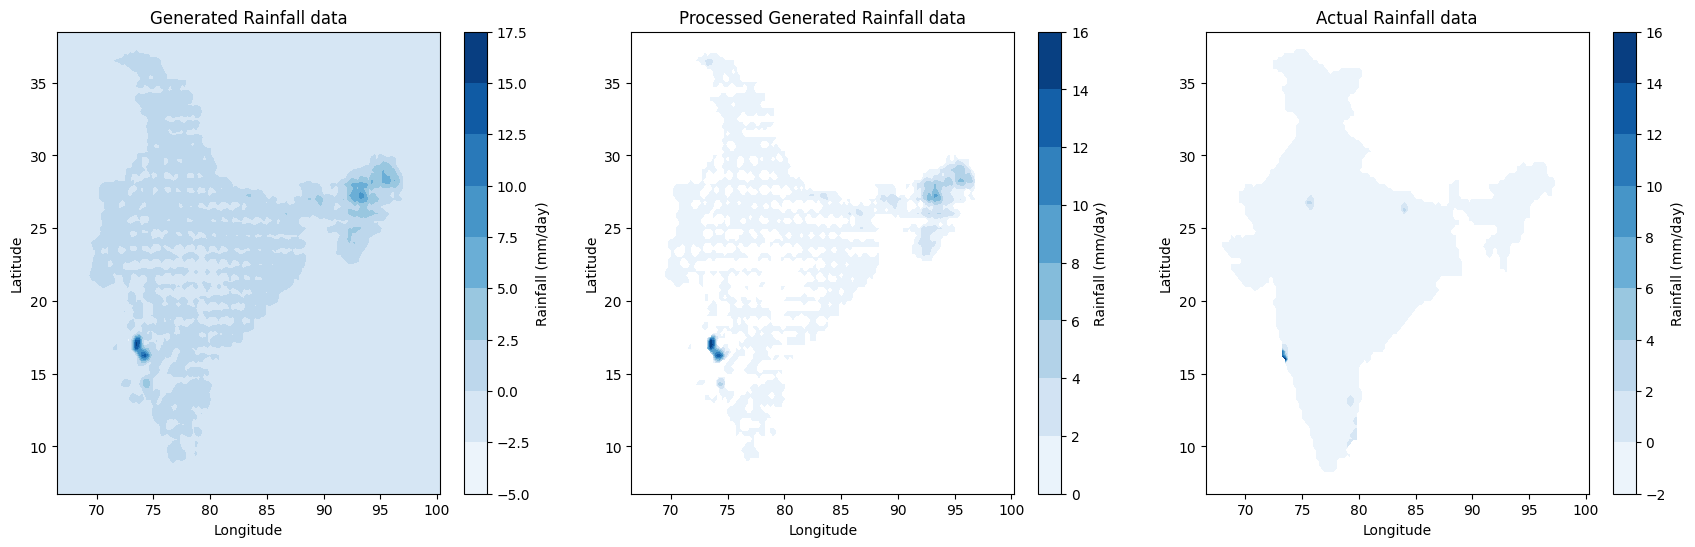

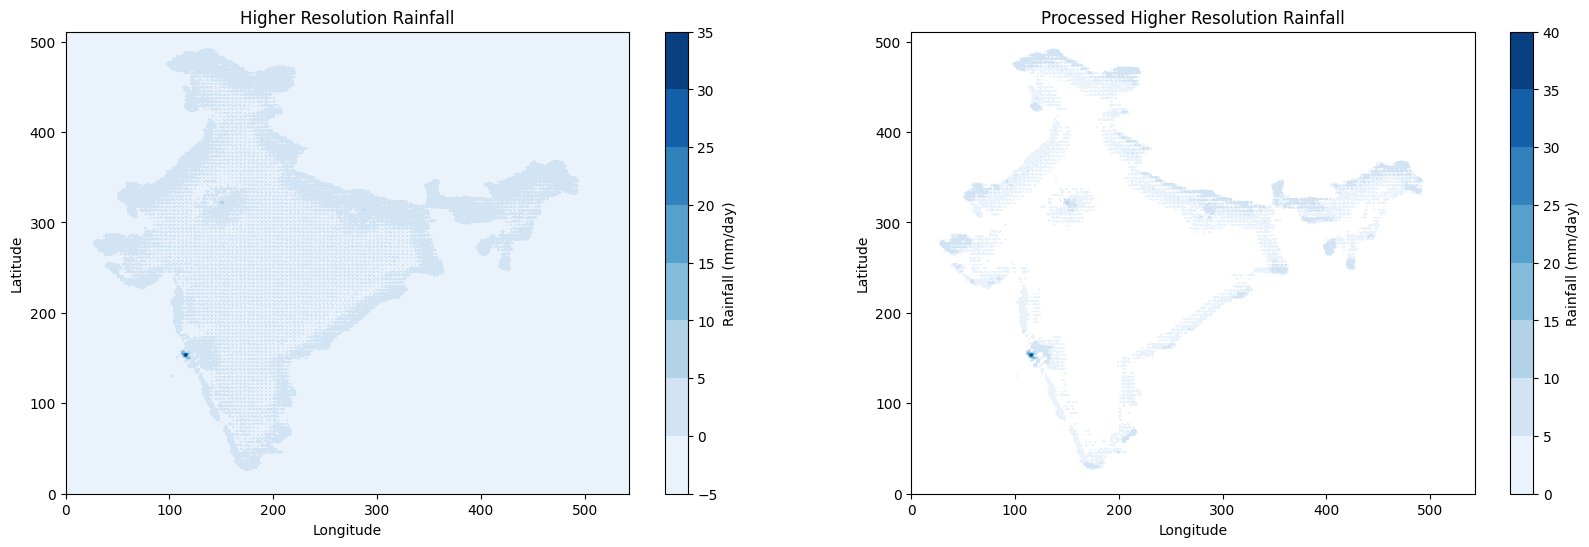

Epoch 3, Year 2020, Generator Loss: -1231.804931640625, Discriminator Loss: 290.0030517578125


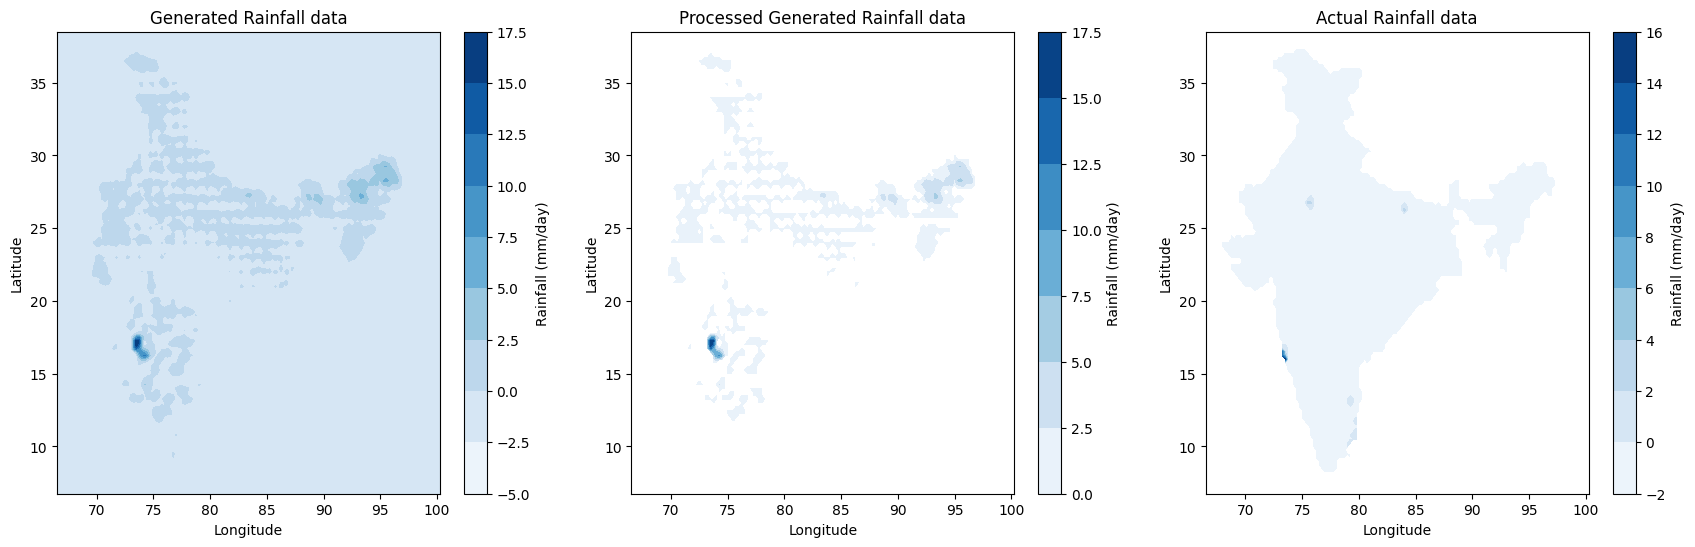

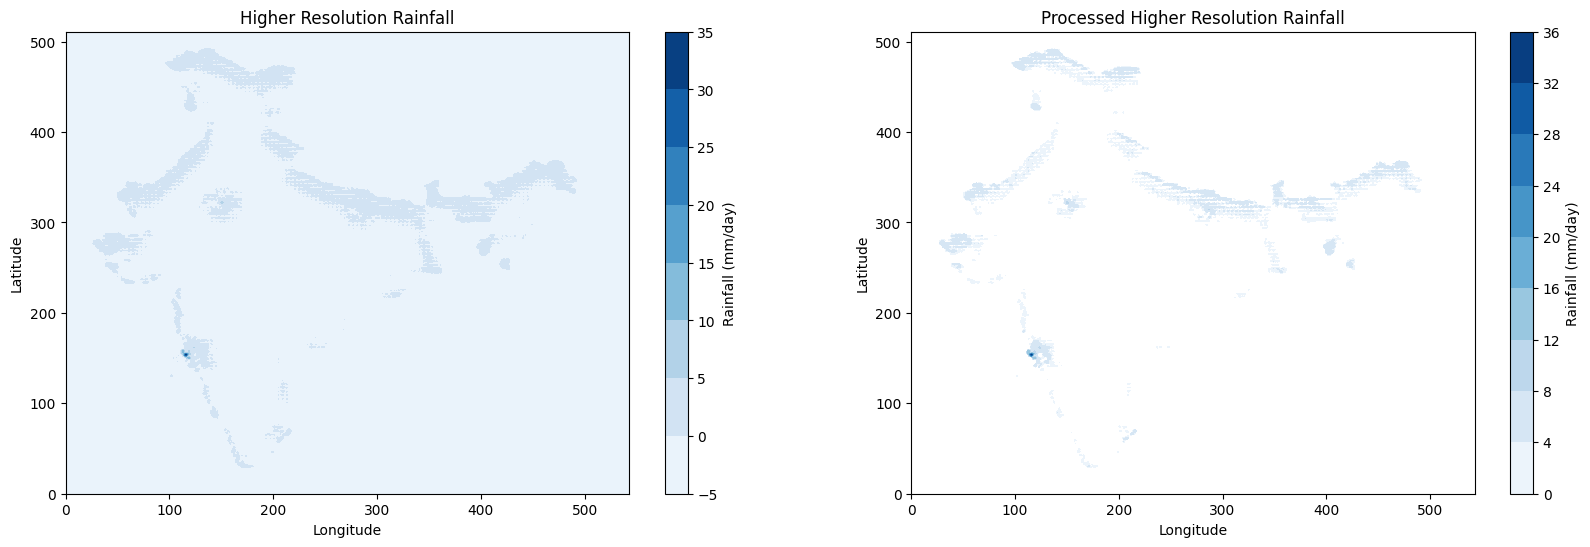

PSNR:27.17870203906817,SSIM:0.7945908364773937
Models saved after epoch 3


In [ ]:
train(SR_data,LR_data,PSNR,SSIM,epochs=5, batch_size=32)

# Evaluation

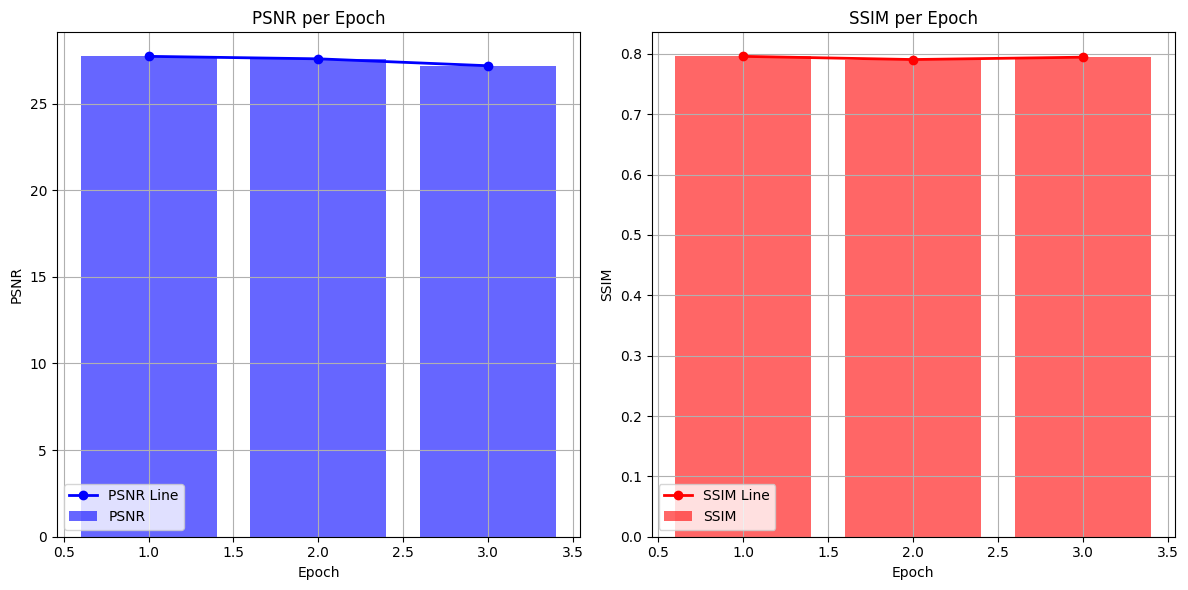

In [30]:
epochs = np.arange(1, len(PSNR) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(epochs, PSNR, color='b', alpha=0.6, label='PSNR')
plt.plot(epochs, PSNR, color='b', marker='o', linestyle='-', linewidth=2, label='PSNR Line')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR per Epoch')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.bar(epochs, SSIM, color='r', alpha=0.6, label='SSIM')
plt.plot(epochs, SSIM, color='r', marker='o', linestyle='-', linewidth=2, label='SSIM Line')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# sr = np.array(SR_data[2000][0]).reshape((1, 128, 136, 1))
# sr = sr.astype(np.float16)
# generated = np.array(Generator(sr))
# print(generated[0].shape)

In [ ]:
# lon = np.arange(len(lon25)*4)
# lat = np.arange(len(lat25)*4)

In [ ]:
# plt.figure(figsize=(10, 6))
# X_SR, Y_SR = np.meshgrid(lon, lat)
# plt.contourf(X_SR, Y_SR, generated[0].reshape(512, 544), cmap='Blues')
# plt.colorbar(label='Rainfall (mm/day)')
# plt.title(f'Rainfall')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

In [ ]:
# plt.contourf(X_SR, Y_SR, generated[0].reshape(), cmap='Blues')
# plt.colorbar(label='Rainfall (mm/day)')
# plt.title('Actual Rainfall data')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()